In [1]:
%matplotlib inline
import copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from alphamind.api import *
from PyFin.api import *
from PyFin.Math.Accumulators.StatefulAccumulators import MovingAverage
from PyFin.Math.Accumulators.StatefulAccumulators import MovingSharp
from PyFin.Math.Accumulators.StatefulAccumulators import MovingMaxDrawdown

plt.style.use('ggplot')

In [2]:
start_date = '2012-01-01'
end_date = '2018-01-05'
benchmark_code = 300
universe_name = ['zz500', 'hs300']
universe = Universe(universe_name, universe_name)
frequency = '10b'
batch = 16
method = 'risk_neutral'
neutralize_risk = ['SIZE', 'LEVERAGE'] + industry_styles
constraint_risk = ['SIZE', 'LEVERAGE'] + industry_styles

horizon = map_freq(frequency)
hedging_ratio = 0.

executor = NaiveExecutor()

In [3]:
engine = SqlEngine()
#factor_coverage = engine.fetch_factor_coverage()

In [4]:
#res = factor_coverage[(factor_coverage.universe == 'ashare_ex') & (factor_coverage.source != 'risk_exposure')].groupby('factor').mean().sort_values('coverage', ascending=False)
#model_features = sorted(res[res.coverage >= 0.99].index.unique().tolist())

const_features_keys = ['roe_q',
                       'ep_q',
                       'DivP',
                       'cfinc1_q',
                       'EBIT',
                       'EARNYILD',
                       'EPIBS']

model_features = copy.deepcopy(const_features_keys)

const_weights = [0.2,
                 0.2,
                 0.1,
                 0.15,
                 0.10,
                 0.10,
                 0.10]

const_weights = pd.Series(const_weights,
                          index=const_features_keys)

const_model = ConstLinearModel(features=const_features_keys,
                               weights=const_weights)

total_features = sorted(list(set(model_features).union(const_features_keys)))

In [5]:
"""
Data phase
"""

engine = SqlEngine()

model_factor_data = fetch_data_package(engine,
                                       alpha_factors=model_features,
                                       start_date=start_date,
                                       end_date=end_date,
                                       frequency=frequency,
                                       universe=universe,
                                       benchmark=benchmark_code,
                                       batch=batch,
                                       neutralized_risk=neutralize_risk,
                                       pre_process=[winsorize_normal, standardize],
                                       post_process=[winsorize_normal, standardize],
                                       warm_start=batch)

model_features_keys = model_factor_data['x_names']

train_x = model_factor_data['train']['x']
train_y = model_factor_data['train']['y']
train_risk = model_factor_data['train']['risk']
ref_dates = sorted(train_x.keys())

predict_x = model_factor_data['predict']['x']
predict_y = model_factor_data['predict']['y']
predict_risk = model_factor_data['predict']['risk']
predict_code = model_factor_data['predict']['code']
settlement = model_factor_data['settlement']

2018-01-11 15:05:09,014 - ALPHA_MIND - INFO - Starting data package fetching ...
2018-01-11 15:05:12,871 - ALPHA_MIND - INFO - factor data loading finished
2018-01-11 15:05:23,029 - ALPHA_MIND - INFO - return data loading finished
2018-01-11 15:05:23,627 - ALPHA_MIND - INFO - industry data loading finished
2018-01-11 15:05:23,879 - ALPHA_MIND - INFO - benchmark data loading finished
2018-01-11 15:05:28,664 - ALPHA_MIND - INFO - risk data loading finished
2018-01-11 15:05:29,622 - ALPHA_MIND - INFO - data merging finished
2018-01-11 15:05:30,383 - ALPHA_MIND - INFO - Loading data is finished
2018-01-11 15:05:33,452 - ALPHA_MIND - INFO - Data processing is finished


In [6]:
for key, val in train_y.items():
    train_y[key] = np.where(val > 0., 1, 0)
    
for key, val in predict_y.items():
    predict_y[key] = np.where(val > 0., 1, 0)

In [7]:
def cross_product(x, y):
    n, m = x.shape
    res = []
    
    for j in range(m):
        res.append(x[:, [j]] * y)
        
    return np.concatenate(res, axis=1)

In [12]:
%%time

"""
Training phase
"""

models_series = pd.Series()
previous_model = None

for ref_date in ref_dates:
    x = train_x[ref_date]
    y = train_y[ref_date]
    risk = train_risk[ref_date][:, 2:]
    new_x = cross_product(x, risk)
    if len(x) > 5 * len(model_features_keys):
        #model = RandomForestClassifier(n_estimators=2000, max_features='sqrt', max_depth=3, n_jobs=-1, features=model_features_keys)
        model = XGBTrainer(features=model_features_keys,
                           objective='binary:logistic',
                           booster='gbtree',
                           tree_method='hist',
                           n_estimators=2000,
                           learning_rate=0.01,
                           early_stopping_rounds=50,
                           subsample=0.1,
                           colsample_bytree=0.5,
                           eval_sample=0.3)
        model.fit(new_x, y)
        models_series.loc[ref_date] = model
        previous_model = copy.deepcopy(model)
    else:
        models_series.loc[ref_date] = previous_model
    
    alpha_logger.info('trade_date: {0} with {1} obs training finished'.format(ref_date, len(x)))

2018-01-11 15:10:26,060 - ALPHA_MIND - INFO - trade_date: 2012-02-08 00:00:00 with 10700 obs training finished
2018-01-11 15:10:38,428 - ALPHA_MIND - INFO - trade_date: 2012-02-22 00:00:00 with 10702 obs training finished
2018-01-11 15:10:50,892 - ALPHA_MIND - INFO - trade_date: 2012-03-07 00:00:00 with 10694 obs training finished
2018-01-11 15:11:03,208 - ALPHA_MIND - INFO - trade_date: 2012-03-21 00:00:00 with 10678 obs training finished
2018-01-11 15:11:15,533 - ALPHA_MIND - INFO - trade_date: 2012-04-09 00:00:00 with 10661 obs training finished
2018-01-11 15:11:27,905 - ALPHA_MIND - INFO - trade_date: 2012-04-23 00:00:00 with 10655 obs training finished
2018-01-11 15:11:40,638 - ALPHA_MIND - INFO - trade_date: 2012-05-09 00:00:00 with 11102 obs training finished
2018-01-11 15:11:53,381 - ALPHA_MIND - INFO - trade_date: 2012-05-23 00:00:00 with 11087 obs training finished
2018-01-11 15:12:06,059 - ALPHA_MIND - INFO - trade_date: 2012-06-06 00:00:00 with 11070 obs training finished
2

2018-01-11 15:35:22,899 - ALPHA_MIND - INFO - trade_date: 2015-02-27 00:00:00 with 10900 obs training finished
2018-01-11 15:35:38,361 - ALPHA_MIND - INFO - trade_date: 2015-03-13 00:00:00 with 10894 obs training finished
2018-01-11 15:35:53,883 - ALPHA_MIND - INFO - trade_date: 2015-03-27 00:00:00 with 10886 obs training finished
2018-01-11 15:36:09,833 - ALPHA_MIND - INFO - trade_date: 2015-04-13 00:00:00 with 10885 obs training finished
2018-01-11 15:36:26,196 - ALPHA_MIND - INFO - trade_date: 2015-04-27 00:00:00 with 10886 obs training finished
2018-01-11 15:36:42,036 - ALPHA_MIND - INFO - trade_date: 2015-05-12 00:00:00 with 10889 obs training finished
2018-01-11 15:36:58,015 - ALPHA_MIND - INFO - trade_date: 2015-05-26 00:00:00 with 10881 obs training finished
2018-01-11 15:37:14,009 - ALPHA_MIND - INFO - trade_date: 2015-06-09 00:00:00 with 10872 obs training finished
2018-01-11 15:37:30,231 - ALPHA_MIND - INFO - trade_date: 2015-06-24 00:00:00 with 10870 obs training finished
2

Wall time: 46min 48s


In [10]:
const_model_factor_data = engine.fetch_data_range(universe,
                                                  const_features_keys,
                                                  dates=ref_dates,
                                                  benchmark=benchmark_code)['factor']

horizon = map_freq(frequency)

2018-01-11 16:07:38,244 - ALPHA_MIND - INFO - 2012-02-08 00:00:00: 800


start 0.01 weight gap simulation ...
using backbone model and alpha model


2018-01-11 16:07:38,483 - ALPHA_MIND - INFO - 2012-02-08 00:00:00 is finished
2018-01-11 16:07:38,489 - ALPHA_MIND - INFO - 2012-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:38,796 - ALPHA_MIND - INFO - 2012-02-22 00:00:00 is finished
2018-01-11 16:07:38,802 - ALPHA_MIND - INFO - 2012-03-07 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:07:39,320 - ALPHA_MIND - INFO - 2012-03-07 00:00:00 is finished
2018-01-11 16:07:39,326 - ALPHA_MIND - INFO - 2012-03-21 00:00:00: 798


using backbone model and alpha model


2018-01-11 16:07:39,638 - ALPHA_MIND - INFO - 2012-03-21 00:00:00 is finished
2018-01-11 16:07:39,643 - ALPHA_MIND - INFO - 2012-04-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:39,945 - ALPHA_MIND - INFO - 2012-04-09 00:00:00 is finished
2018-01-11 16:07:39,950 - ALPHA_MIND - INFO - 2012-04-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:40,269 - ALPHA_MIND - INFO - 2012-04-23 00:00:00 is finished
2018-01-11 16:07:40,274 - ALPHA_MIND - INFO - 2012-05-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:40,593 - ALPHA_MIND - INFO - 2012-05-09 00:00:00 is finished
2018-01-11 16:07:40,599 - ALPHA_MIND - INFO - 2012-05-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:40,918 - ALPHA_MIND - INFO - 2012-05-23 00:00:00 is finished
2018-01-11 16:07:40,924 - ALPHA_MIND - INFO - 2012-06-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:41,233 - ALPHA_MIND - INFO - 2012-06-06 00:00:00 is finished
2018-01-11 16:07:41,238 - ALPHA_MIND - INFO - 2012-06-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:41,545 - ALPHA_MIND - INFO - 2012-06-20 00:00:00 is finished
2018-01-11 16:07:41,550 - ALPHA_MIND - INFO - 2012-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:41,866 - ALPHA_MIND - INFO - 2012-07-05 00:00:00 is finished
2018-01-11 16:07:41,871 - ALPHA_MIND - INFO - 2012-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:42,169 - ALPHA_MIND - INFO - 2012-07-19 00:00:00 is finished
2018-01-11 16:07:42,174 - ALPHA_MIND - INFO - 2012-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:42,476 - ALPHA_MIND - INFO - 2012-08-02 00:00:00 is finished
2018-01-11 16:07:42,481 - ALPHA_MIND - INFO - 2012-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:42,779 - ALPHA_MIND - INFO - 2012-08-16 00:00:00 is finished
2018-01-11 16:07:42,784 - ALPHA_MIND - INFO - 2012-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:43,106 - ALPHA_MIND - INFO - 2012-08-30 00:00:00 is finished
2018-01-11 16:07:43,111 - ALPHA_MIND - INFO - 2012-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:43,426 - ALPHA_MIND - INFO - 2012-09-13 00:00:00 is finished
2018-01-11 16:07:43,432 - ALPHA_MIND - INFO - 2012-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:43,746 - ALPHA_MIND - INFO - 2012-09-27 00:00:00 is finished
2018-01-11 16:07:43,751 - ALPHA_MIND - INFO - 2012-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:44,168 - ALPHA_MIND - INFO - 2012-10-18 00:00:00 is finished
2018-01-11 16:07:44,172 - ALPHA_MIND - INFO - 2012-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:44,482 - ALPHA_MIND - INFO - 2012-11-01 00:00:00 is finished
2018-01-11 16:07:44,487 - ALPHA_MIND - INFO - 2012-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:44,800 - ALPHA_MIND - INFO - 2012-11-15 00:00:00 is finished
2018-01-11 16:07:44,806 - ALPHA_MIND - INFO - 2012-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:45,111 - ALPHA_MIND - INFO - 2012-11-29 00:00:00 is finished
2018-01-11 16:07:45,117 - ALPHA_MIND - INFO - 2012-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:45,437 - ALPHA_MIND - INFO - 2012-12-13 00:00:00 is finished
2018-01-11 16:07:45,441 - ALPHA_MIND - INFO - 2012-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:45,754 - ALPHA_MIND - INFO - 2012-12-27 00:00:00 is finished
2018-01-11 16:07:45,758 - ALPHA_MIND - INFO - 2013-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:46,062 - ALPHA_MIND - INFO - 2013-01-15 00:00:00 is finished
2018-01-11 16:07:46,067 - ALPHA_MIND - INFO - 2013-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:46,380 - ALPHA_MIND - INFO - 2013-01-29 00:00:00 is finished
2018-01-11 16:07:46,385 - ALPHA_MIND - INFO - 2013-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:46,718 - ALPHA_MIND - INFO - 2013-02-19 00:00:00 is finished
2018-01-11 16:07:46,724 - ALPHA_MIND - INFO - 2013-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:47,034 - ALPHA_MIND - INFO - 2013-03-05 00:00:00 is finished
2018-01-11 16:07:47,039 - ALPHA_MIND - INFO - 2013-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:47,343 - ALPHA_MIND - INFO - 2013-03-19 00:00:00 is finished
2018-01-11 16:07:47,349 - ALPHA_MIND - INFO - 2013-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:47,642 - ALPHA_MIND - INFO - 2013-04-02 00:00:00 is finished
2018-01-11 16:07:47,647 - ALPHA_MIND - INFO - 2013-04-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:47,951 - ALPHA_MIND - INFO - 2013-04-18 00:00:00 is finished
2018-01-11 16:07:47,956 - ALPHA_MIND - INFO - 2013-05-07 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:48,269 - ALPHA_MIND - INFO - 2013-05-07 00:00:00 is finished
2018-01-11 16:07:48,275 - ALPHA_MIND - INFO - 2013-05-21 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:48,682 - ALPHA_MIND - INFO - 2013-05-21 00:00:00 is finished
2018-01-11 16:07:48,687 - ALPHA_MIND - INFO - 2013-06-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:48,995 - ALPHA_MIND - INFO - 2013-06-04 00:00:00 is finished
2018-01-11 16:07:49,001 - ALPHA_MIND - INFO - 2013-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:49,306 - ALPHA_MIND - INFO - 2013-06-21 00:00:00 is finished
2018-01-11 16:07:49,311 - ALPHA_MIND - INFO - 2013-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:49,631 - ALPHA_MIND - INFO - 2013-07-05 00:00:00 is finished
2018-01-11 16:07:49,636 - ALPHA_MIND - INFO - 2013-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:49,945 - ALPHA_MIND - INFO - 2013-07-19 00:00:00 is finished
2018-01-11 16:07:49,950 - ALPHA_MIND - INFO - 2013-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:50,248 - ALPHA_MIND - INFO - 2013-08-02 00:00:00 is finished
2018-01-11 16:07:50,254 - ALPHA_MIND - INFO - 2013-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:50,548 - ALPHA_MIND - INFO - 2013-08-16 00:00:00 is finished
2018-01-11 16:07:50,553 - ALPHA_MIND - INFO - 2013-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:50,851 - ALPHA_MIND - INFO - 2013-08-30 00:00:00 is finished
2018-01-11 16:07:50,857 - ALPHA_MIND - INFO - 2013-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:51,157 - ALPHA_MIND - INFO - 2013-09-13 00:00:00 is finished
2018-01-11 16:07:51,162 - ALPHA_MIND - INFO - 2013-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:51,462 - ALPHA_MIND - INFO - 2013-10-08 00:00:00 is finished
2018-01-11 16:07:51,467 - ALPHA_MIND - INFO - 2013-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:51,771 - ALPHA_MIND - INFO - 2013-10-22 00:00:00 is finished
2018-01-11 16:07:51,776 - ALPHA_MIND - INFO - 2013-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:52,085 - ALPHA_MIND - INFO - 2013-11-05 00:00:00 is finished
2018-01-11 16:07:52,090 - ALPHA_MIND - INFO - 2013-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:52,399 - ALPHA_MIND - INFO - 2013-11-19 00:00:00 is finished
2018-01-11 16:07:52,405 - ALPHA_MIND - INFO - 2013-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:52,708 - ALPHA_MIND - INFO - 2013-12-03 00:00:00 is finished
2018-01-11 16:07:52,714 - ALPHA_MIND - INFO - 2013-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:53,023 - ALPHA_MIND - INFO - 2013-12-17 00:00:00 is finished
2018-01-11 16:07:53,029 - ALPHA_MIND - INFO - 2013-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:53,437 - ALPHA_MIND - INFO - 2013-12-31 00:00:00 is finished
2018-01-11 16:07:53,442 - ALPHA_MIND - INFO - 2014-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:53,748 - ALPHA_MIND - INFO - 2014-01-15 00:00:00 is finished
2018-01-11 16:07:53,753 - ALPHA_MIND - INFO - 2014-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:54,065 - ALPHA_MIND - INFO - 2014-01-29 00:00:00 is finished
2018-01-11 16:07:54,069 - ALPHA_MIND - INFO - 2014-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:54,375 - ALPHA_MIND - INFO - 2014-02-19 00:00:00 is finished
2018-01-11 16:07:54,380 - ALPHA_MIND - INFO - 2014-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:54,688 - ALPHA_MIND - INFO - 2014-03-05 00:00:00 is finished
2018-01-11 16:07:54,693 - ALPHA_MIND - INFO - 2014-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:54,999 - ALPHA_MIND - INFO - 2014-03-19 00:00:00 is finished
2018-01-11 16:07:55,005 - ALPHA_MIND - INFO - 2014-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:55,320 - ALPHA_MIND - INFO - 2014-04-02 00:00:00 is finished
2018-01-11 16:07:55,325 - ALPHA_MIND - INFO - 2014-04-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:55,634 - ALPHA_MIND - INFO - 2014-04-17 00:00:00 is finished
2018-01-11 16:07:55,639 - ALPHA_MIND - INFO - 2014-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:55,959 - ALPHA_MIND - INFO - 2014-05-05 00:00:00 is finished
2018-01-11 16:07:55,963 - ALPHA_MIND - INFO - 2014-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:56,284 - ALPHA_MIND - INFO - 2014-05-19 00:00:00 is finished
2018-01-11 16:07:56,290 - ALPHA_MIND - INFO - 2014-06-03 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:56,591 - ALPHA_MIND - INFO - 2014-06-03 00:00:00 is finished
2018-01-11 16:07:56,596 - ALPHA_MIND - INFO - 2014-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:56,902 - ALPHA_MIND - INFO - 2014-06-17 00:00:00 is finished
2018-01-11 16:07:56,907 - ALPHA_MIND - INFO - 2014-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:57,226 - ALPHA_MIND - INFO - 2014-07-01 00:00:00 is finished
2018-01-11 16:07:57,231 - ALPHA_MIND - INFO - 2014-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:57,544 - ALPHA_MIND - INFO - 2014-07-15 00:00:00 is finished
2018-01-11 16:07:57,549 - ALPHA_MIND - INFO - 2014-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:57,855 - ALPHA_MIND - INFO - 2014-07-29 00:00:00 is finished
2018-01-11 16:07:57,859 - ALPHA_MIND - INFO - 2014-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:58,274 - ALPHA_MIND - INFO - 2014-08-12 00:00:00 is finished
2018-01-11 16:07:58,280 - ALPHA_MIND - INFO - 2014-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:58,592 - ALPHA_MIND - INFO - 2014-08-26 00:00:00 is finished
2018-01-11 16:07:58,598 - ALPHA_MIND - INFO - 2014-09-10 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:58,913 - ALPHA_MIND - INFO - 2014-09-10 00:00:00 is finished
2018-01-11 16:07:58,917 - ALPHA_MIND - INFO - 2014-09-24 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:59,222 - ALPHA_MIND - INFO - 2014-09-24 00:00:00 is finished
2018-01-11 16:07:59,226 - ALPHA_MIND - INFO - 2014-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:59,532 - ALPHA_MIND - INFO - 2014-10-15 00:00:00 is finished
2018-01-11 16:07:59,538 - ALPHA_MIND - INFO - 2014-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:07:59,837 - ALPHA_MIND - INFO - 2014-10-29 00:00:00 is finished
2018-01-11 16:07:59,842 - ALPHA_MIND - INFO - 2014-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:00,153 - ALPHA_MIND - INFO - 2014-11-12 00:00:00 is finished
2018-01-11 16:08:00,157 - ALPHA_MIND - INFO - 2014-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:00,471 - ALPHA_MIND - INFO - 2014-11-26 00:00:00 is finished
2018-01-11 16:08:00,476 - ALPHA_MIND - INFO - 2014-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:00,791 - ALPHA_MIND - INFO - 2014-12-10 00:00:00 is finished
2018-01-11 16:08:00,796 - ALPHA_MIND - INFO - 2014-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:01,127 - ALPHA_MIND - INFO - 2014-12-24 00:00:00 is finished
2018-01-11 16:08:01,133 - ALPHA_MIND - INFO - 2015-01-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:01,441 - ALPHA_MIND - INFO - 2015-01-09 00:00:00 is finished
2018-01-11 16:08:01,447 - ALPHA_MIND - INFO - 2015-01-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:01,753 - ALPHA_MIND - INFO - 2015-01-23 00:00:00 is finished
2018-01-11 16:08:01,758 - ALPHA_MIND - INFO - 2015-02-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:02,075 - ALPHA_MIND - INFO - 2015-02-06 00:00:00 is finished
2018-01-11 16:08:02,081 - ALPHA_MIND - INFO - 2015-02-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:02,407 - ALPHA_MIND - INFO - 2015-02-27 00:00:00 is finished
2018-01-11 16:08:02,414 - ALPHA_MIND - INFO - 2015-03-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:02,720 - ALPHA_MIND - INFO - 2015-03-13 00:00:00 is finished
2018-01-11 16:08:02,726 - ALPHA_MIND - INFO - 2015-03-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:03,128 - ALPHA_MIND - INFO - 2015-03-27 00:00:00 is finished
2018-01-11 16:08:03,132 - ALPHA_MIND - INFO - 2015-04-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:03,449 - ALPHA_MIND - INFO - 2015-04-13 00:00:00 is finished
2018-01-11 16:08:03,454 - ALPHA_MIND - INFO - 2015-04-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:03,774 - ALPHA_MIND - INFO - 2015-04-27 00:00:00 is finished
2018-01-11 16:08:03,780 - ALPHA_MIND - INFO - 2015-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:04,098 - ALPHA_MIND - INFO - 2015-05-12 00:00:00 is finished
2018-01-11 16:08:04,103 - ALPHA_MIND - INFO - 2015-05-26 00:00:00: 798


using backbone model and alpha model


2018-01-11 16:08:04,413 - ALPHA_MIND - INFO - 2015-05-26 00:00:00 is finished
2018-01-11 16:08:04,418 - ALPHA_MIND - INFO - 2015-06-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:04,717 - ALPHA_MIND - INFO - 2015-06-09 00:00:00 is finished
2018-01-11 16:08:04,722 - ALPHA_MIND - INFO - 2015-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:05,035 - ALPHA_MIND - INFO - 2015-06-24 00:00:00 is finished
2018-01-11 16:08:05,040 - ALPHA_MIND - INFO - 2015-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:05,350 - ALPHA_MIND - INFO - 2015-07-08 00:00:00 is finished
2018-01-11 16:08:05,356 - ALPHA_MIND - INFO - 2015-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:05,669 - ALPHA_MIND - INFO - 2015-07-22 00:00:00 is finished
2018-01-11 16:08:05,674 - ALPHA_MIND - INFO - 2015-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:05,981 - ALPHA_MIND - INFO - 2015-08-05 00:00:00 is finished
2018-01-11 16:08:05,986 - ALPHA_MIND - INFO - 2015-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:06,293 - ALPHA_MIND - INFO - 2015-08-19 00:00:00 is finished
2018-01-11 16:08:06,297 - ALPHA_MIND - INFO - 2015-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:06,612 - ALPHA_MIND - INFO - 2015-09-02 00:00:00 is finished
2018-01-11 16:08:06,616 - ALPHA_MIND - INFO - 2015-09-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:06,935 - ALPHA_MIND - INFO - 2015-09-18 00:00:00 is finished
2018-01-11 16:08:06,940 - ALPHA_MIND - INFO - 2015-10-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:07,253 - ALPHA_MIND - INFO - 2015-10-09 00:00:00 is finished
2018-01-11 16:08:07,259 - ALPHA_MIND - INFO - 2015-10-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:07,568 - ALPHA_MIND - INFO - 2015-10-23 00:00:00 is finished
2018-01-11 16:08:07,573 - ALPHA_MIND - INFO - 2015-11-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:07,991 - ALPHA_MIND - INFO - 2015-11-06 00:00:00 is finished
2018-01-11 16:08:07,996 - ALPHA_MIND - INFO - 2015-11-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:08,322 - ALPHA_MIND - INFO - 2015-11-20 00:00:00 is finished
2018-01-11 16:08:08,327 - ALPHA_MIND - INFO - 2015-12-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:08,657 - ALPHA_MIND - INFO - 2015-12-04 00:00:00 is finished
2018-01-11 16:08:08,663 - ALPHA_MIND - INFO - 2015-12-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:08,973 - ALPHA_MIND - INFO - 2015-12-18 00:00:00 is finished
2018-01-11 16:08:08,979 - ALPHA_MIND - INFO - 2016-01-04 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:08:09,290 - ALPHA_MIND - INFO - 2016-01-04 00:00:00 is finished
2018-01-11 16:08:09,296 - ALPHA_MIND - INFO - 2016-01-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:09,607 - ALPHA_MIND - INFO - 2016-01-18 00:00:00 is finished
2018-01-11 16:08:09,613 - ALPHA_MIND - INFO - 2016-02-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:09,923 - ALPHA_MIND - INFO - 2016-02-01 00:00:00 is finished
2018-01-11 16:08:09,928 - ALPHA_MIND - INFO - 2016-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:10,231 - ALPHA_MIND - INFO - 2016-02-22 00:00:00 is finished
2018-01-11 16:08:10,236 - ALPHA_MIND - INFO - 2016-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:10,551 - ALPHA_MIND - INFO - 2016-03-07 00:00:00 is finished
2018-01-11 16:08:10,556 - ALPHA_MIND - INFO - 2016-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:10,874 - ALPHA_MIND - INFO - 2016-03-21 00:00:00 is finished
2018-01-11 16:08:10,879 - ALPHA_MIND - INFO - 2016-04-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:11,193 - ALPHA_MIND - INFO - 2016-04-05 00:00:00 is finished
2018-01-11 16:08:11,199 - ALPHA_MIND - INFO - 2016-04-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:11,531 - ALPHA_MIND - INFO - 2016-04-19 00:00:00 is finished
2018-01-11 16:08:11,538 - ALPHA_MIND - INFO - 2016-05-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:11,877 - ALPHA_MIND - INFO - 2016-05-04 00:00:00 is finished
2018-01-11 16:08:11,884 - ALPHA_MIND - INFO - 2016-05-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:12,211 - ALPHA_MIND - INFO - 2016-05-18 00:00:00 is finished
2018-01-11 16:08:12,218 - ALPHA_MIND - INFO - 2016-06-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:12,536 - ALPHA_MIND - INFO - 2016-06-01 00:00:00 is finished
2018-01-11 16:08:12,543 - ALPHA_MIND - INFO - 2016-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:12,950 - ALPHA_MIND - INFO - 2016-06-17 00:00:00 is finished
2018-01-11 16:08:12,956 - ALPHA_MIND - INFO - 2016-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:13,259 - ALPHA_MIND - INFO - 2016-07-01 00:00:00 is finished
2018-01-11 16:08:13,264 - ALPHA_MIND - INFO - 2016-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:13,567 - ALPHA_MIND - INFO - 2016-07-15 00:00:00 is finished
2018-01-11 16:08:13,573 - ALPHA_MIND - INFO - 2016-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:13,878 - ALPHA_MIND - INFO - 2016-07-29 00:00:00 is finished
2018-01-11 16:08:13,883 - ALPHA_MIND - INFO - 2016-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:14,204 - ALPHA_MIND - INFO - 2016-08-12 00:00:00 is finished
2018-01-11 16:08:14,209 - ALPHA_MIND - INFO - 2016-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:14,513 - ALPHA_MIND - INFO - 2016-08-26 00:00:00 is finished
2018-01-11 16:08:14,518 - ALPHA_MIND - INFO - 2016-09-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:14,828 - ALPHA_MIND - INFO - 2016-09-09 00:00:00 is finished
2018-01-11 16:08:14,832 - ALPHA_MIND - INFO - 2016-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:15,146 - ALPHA_MIND - INFO - 2016-09-27 00:00:00 is finished
2018-01-11 16:08:15,151 - ALPHA_MIND - INFO - 2016-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:15,467 - ALPHA_MIND - INFO - 2016-10-18 00:00:00 is finished
2018-01-11 16:08:15,473 - ALPHA_MIND - INFO - 2016-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:15,791 - ALPHA_MIND - INFO - 2016-11-01 00:00:00 is finished
2018-01-11 16:08:15,797 - ALPHA_MIND - INFO - 2016-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:16,122 - ALPHA_MIND - INFO - 2016-11-15 00:00:00 is finished
2018-01-11 16:08:16,127 - ALPHA_MIND - INFO - 2016-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:16,435 - ALPHA_MIND - INFO - 2016-11-29 00:00:00 is finished
2018-01-11 16:08:16,440 - ALPHA_MIND - INFO - 2016-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:16,750 - ALPHA_MIND - INFO - 2016-12-13 00:00:00 is finished
2018-01-11 16:08:16,756 - ALPHA_MIND - INFO - 2016-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:17,080 - ALPHA_MIND - INFO - 2016-12-27 00:00:00 is finished
2018-01-11 16:08:17,086 - ALPHA_MIND - INFO - 2017-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:17,404 - ALPHA_MIND - INFO - 2017-01-11 00:00:00 is finished
2018-01-11 16:08:17,409 - ALPHA_MIND - INFO - 2017-01-25 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:08:17,785 - ALPHA_MIND - INFO - 2017-01-25 00:00:00 is finished
2018-01-11 16:08:17,789 - ALPHA_MIND - INFO - 2017-02-15 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:08:18,102 - ALPHA_MIND - INFO - 2017-02-15 00:00:00 is finished
2018-01-11 16:08:18,107 - ALPHA_MIND - INFO - 2017-03-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:18,441 - ALPHA_MIND - INFO - 2017-03-01 00:00:00 is finished
2018-01-11 16:08:18,446 - ALPHA_MIND - INFO - 2017-03-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:18,765 - ALPHA_MIND - INFO - 2017-03-15 00:00:00 is finished
2018-01-11 16:08:18,770 - ALPHA_MIND - INFO - 2017-03-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:19,079 - ALPHA_MIND - INFO - 2017-03-29 00:00:00 is finished
2018-01-11 16:08:19,084 - ALPHA_MIND - INFO - 2017-04-14 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:19,410 - ALPHA_MIND - INFO - 2017-04-14 00:00:00 is finished
2018-01-11 16:08:19,415 - ALPHA_MIND - INFO - 2017-04-28 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:19,729 - ALPHA_MIND - INFO - 2017-04-28 00:00:00 is finished
2018-01-11 16:08:19,735 - ALPHA_MIND - INFO - 2017-05-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:20,061 - ALPHA_MIND - INFO - 2017-05-15 00:00:00 is finished
2018-01-11 16:08:20,066 - ALPHA_MIND - INFO - 2017-05-31 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:20,395 - ALPHA_MIND - INFO - 2017-05-31 00:00:00 is finished
2018-01-11 16:08:20,400 - ALPHA_MIND - INFO - 2017-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:20,729 - ALPHA_MIND - INFO - 2017-06-14 00:00:00 is finished
2018-01-11 16:08:20,733 - ALPHA_MIND - INFO - 2017-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:21,064 - ALPHA_MIND - INFO - 2017-06-28 00:00:00 is finished
2018-01-11 16:08:21,070 - ALPHA_MIND - INFO - 2017-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:21,407 - ALPHA_MIND - INFO - 2017-07-12 00:00:00 is finished
2018-01-11 16:08:21,413 - ALPHA_MIND - INFO - 2017-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:21,726 - ALPHA_MIND - INFO - 2017-07-26 00:00:00 is finished
2018-01-11 16:08:21,730 - ALPHA_MIND - INFO - 2017-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:22,052 - ALPHA_MIND - INFO - 2017-08-09 00:00:00 is finished
2018-01-11 16:08:22,057 - ALPHA_MIND - INFO - 2017-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:22,383 - ALPHA_MIND - INFO - 2017-08-23 00:00:00 is finished
2018-01-11 16:08:22,388 - ALPHA_MIND - INFO - 2017-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:22,797 - ALPHA_MIND - INFO - 2017-09-06 00:00:00 is finished
2018-01-11 16:08:22,802 - ALPHA_MIND - INFO - 2017-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:23,104 - ALPHA_MIND - INFO - 2017-09-20 00:00:00 is finished
2018-01-11 16:08:23,108 - ALPHA_MIND - INFO - 2017-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:23,427 - ALPHA_MIND - INFO - 2017-10-11 00:00:00 is finished
2018-01-11 16:08:23,432 - ALPHA_MIND - INFO - 2017-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:23,741 - ALPHA_MIND - INFO - 2017-10-25 00:00:00 is finished
2018-01-11 16:08:23,746 - ALPHA_MIND - INFO - 2017-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:24,048 - ALPHA_MIND - INFO - 2017-11-08 00:00:00 is finished
2018-01-11 16:08:24,052 - ALPHA_MIND - INFO - 2017-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:24,383 - ALPHA_MIND - INFO - 2017-11-22 00:00:00 is finished
2018-01-11 16:08:24,389 - ALPHA_MIND - INFO - 2017-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:24,707 - ALPHA_MIND - INFO - 2017-12-06 00:00:00 is finished
2018-01-11 16:08:24,712 - ALPHA_MIND - INFO - 2017-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:25,041 - ALPHA_MIND - INFO - 2017-12-20 00:00:00 is finished
2018-01-11 16:08:25,046 - ALPHA_MIND - INFO - 2018-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:25,306 - ALPHA_MIND - INFO - 2018-01-04 00:00:00 is finished
2018-01-11 16:08:25,923 - ALPHA_MIND - INFO - 2012-02-08 00:00:00: 800


start 0.02 weight gap simulation ...
using backbone model and alpha model


2018-01-11 16:08:26,131 - ALPHA_MIND - INFO - 2012-02-08 00:00:00 is finished
2018-01-11 16:08:26,136 - ALPHA_MIND - INFO - 2012-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:26,440 - ALPHA_MIND - INFO - 2012-02-22 00:00:00 is finished
2018-01-11 16:08:26,446 - ALPHA_MIND - INFO - 2012-03-07 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:08:26,724 - ALPHA_MIND - INFO - 2012-03-07 00:00:00 is finished
2018-01-11 16:08:26,729 - ALPHA_MIND - INFO - 2012-03-21 00:00:00: 798


using backbone model and alpha model


2018-01-11 16:08:27,138 - ALPHA_MIND - INFO - 2012-03-21 00:00:00 is finished
2018-01-11 16:08:27,143 - ALPHA_MIND - INFO - 2012-04-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:27,453 - ALPHA_MIND - INFO - 2012-04-09 00:00:00 is finished
2018-01-11 16:08:27,458 - ALPHA_MIND - INFO - 2012-04-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:27,751 - ALPHA_MIND - INFO - 2012-04-23 00:00:00 is finished
2018-01-11 16:08:27,756 - ALPHA_MIND - INFO - 2012-05-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:28,058 - ALPHA_MIND - INFO - 2012-05-09 00:00:00 is finished
2018-01-11 16:08:28,064 - ALPHA_MIND - INFO - 2012-05-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:28,370 - ALPHA_MIND - INFO - 2012-05-23 00:00:00 is finished
2018-01-11 16:08:28,376 - ALPHA_MIND - INFO - 2012-06-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:28,689 - ALPHA_MIND - INFO - 2012-06-06 00:00:00 is finished
2018-01-11 16:08:28,695 - ALPHA_MIND - INFO - 2012-06-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:28,998 - ALPHA_MIND - INFO - 2012-06-20 00:00:00 is finished
2018-01-11 16:08:29,003 - ALPHA_MIND - INFO - 2012-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:29,305 - ALPHA_MIND - INFO - 2012-07-05 00:00:00 is finished
2018-01-11 16:08:29,310 - ALPHA_MIND - INFO - 2012-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:29,619 - ALPHA_MIND - INFO - 2012-07-19 00:00:00 is finished
2018-01-11 16:08:29,624 - ALPHA_MIND - INFO - 2012-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:29,925 - ALPHA_MIND - INFO - 2012-08-02 00:00:00 is finished
2018-01-11 16:08:29,931 - ALPHA_MIND - INFO - 2012-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:30,244 - ALPHA_MIND - INFO - 2012-08-16 00:00:00 is finished
2018-01-11 16:08:30,250 - ALPHA_MIND - INFO - 2012-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:30,574 - ALPHA_MIND - INFO - 2012-08-30 00:00:00 is finished
2018-01-11 16:08:30,579 - ALPHA_MIND - INFO - 2012-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:30,893 - ALPHA_MIND - INFO - 2012-09-13 00:00:00 is finished
2018-01-11 16:08:30,899 - ALPHA_MIND - INFO - 2012-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:31,199 - ALPHA_MIND - INFO - 2012-09-27 00:00:00 is finished
2018-01-11 16:08:31,205 - ALPHA_MIND - INFO - 2012-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:31,516 - ALPHA_MIND - INFO - 2012-10-18 00:00:00 is finished
2018-01-11 16:08:31,521 - ALPHA_MIND - INFO - 2012-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:31,907 - ALPHA_MIND - INFO - 2012-11-01 00:00:00 is finished
2018-01-11 16:08:31,913 - ALPHA_MIND - INFO - 2012-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:32,213 - ALPHA_MIND - INFO - 2012-11-15 00:00:00 is finished
2018-01-11 16:08:32,219 - ALPHA_MIND - INFO - 2012-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:32,524 - ALPHA_MIND - INFO - 2012-11-29 00:00:00 is finished
2018-01-11 16:08:32,529 - ALPHA_MIND - INFO - 2012-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:32,825 - ALPHA_MIND - INFO - 2012-12-13 00:00:00 is finished
2018-01-11 16:08:32,830 - ALPHA_MIND - INFO - 2012-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:33,135 - ALPHA_MIND - INFO - 2012-12-27 00:00:00 is finished
2018-01-11 16:08:33,141 - ALPHA_MIND - INFO - 2013-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:33,439 - ALPHA_MIND - INFO - 2013-01-15 00:00:00 is finished
2018-01-11 16:08:33,444 - ALPHA_MIND - INFO - 2013-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:33,740 - ALPHA_MIND - INFO - 2013-01-29 00:00:00 is finished
2018-01-11 16:08:33,745 - ALPHA_MIND - INFO - 2013-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:34,055 - ALPHA_MIND - INFO - 2013-02-19 00:00:00 is finished
2018-01-11 16:08:34,060 - ALPHA_MIND - INFO - 2013-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:34,371 - ALPHA_MIND - INFO - 2013-03-05 00:00:00 is finished
2018-01-11 16:08:34,375 - ALPHA_MIND - INFO - 2013-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:34,672 - ALPHA_MIND - INFO - 2013-03-19 00:00:00 is finished
2018-01-11 16:08:34,677 - ALPHA_MIND - INFO - 2013-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:34,974 - ALPHA_MIND - INFO - 2013-04-02 00:00:00 is finished
2018-01-11 16:08:34,979 - ALPHA_MIND - INFO - 2013-04-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:35,281 - ALPHA_MIND - INFO - 2013-04-18 00:00:00 is finished
2018-01-11 16:08:35,286 - ALPHA_MIND - INFO - 2013-05-07 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:35,582 - ALPHA_MIND - INFO - 2013-05-07 00:00:00 is finished
2018-01-11 16:08:35,587 - ALPHA_MIND - INFO - 2013-05-21 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:35,888 - ALPHA_MIND - INFO - 2013-05-21 00:00:00 is finished
2018-01-11 16:08:35,893 - ALPHA_MIND - INFO - 2013-06-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:36,207 - ALPHA_MIND - INFO - 2013-06-04 00:00:00 is finished
2018-01-11 16:08:36,212 - ALPHA_MIND - INFO - 2013-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:36,601 - ALPHA_MIND - INFO - 2013-06-21 00:00:00 is finished
2018-01-11 16:08:36,606 - ALPHA_MIND - INFO - 2013-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:36,901 - ALPHA_MIND - INFO - 2013-07-05 00:00:00 is finished
2018-01-11 16:08:36,906 - ALPHA_MIND - INFO - 2013-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:37,207 - ALPHA_MIND - INFO - 2013-07-19 00:00:00 is finished
2018-01-11 16:08:37,212 - ALPHA_MIND - INFO - 2013-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:37,516 - ALPHA_MIND - INFO - 2013-08-02 00:00:00 is finished
2018-01-11 16:08:37,521 - ALPHA_MIND - INFO - 2013-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:37,831 - ALPHA_MIND - INFO - 2013-08-16 00:00:00 is finished
2018-01-11 16:08:37,836 - ALPHA_MIND - INFO - 2013-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:38,135 - ALPHA_MIND - INFO - 2013-08-30 00:00:00 is finished
2018-01-11 16:08:38,141 - ALPHA_MIND - INFO - 2013-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:38,447 - ALPHA_MIND - INFO - 2013-09-13 00:00:00 is finished
2018-01-11 16:08:38,452 - ALPHA_MIND - INFO - 2013-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:38,744 - ALPHA_MIND - INFO - 2013-10-08 00:00:00 is finished
2018-01-11 16:08:38,749 - ALPHA_MIND - INFO - 2013-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:39,061 - ALPHA_MIND - INFO - 2013-10-22 00:00:00 is finished
2018-01-11 16:08:39,067 - ALPHA_MIND - INFO - 2013-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:39,371 - ALPHA_MIND - INFO - 2013-11-05 00:00:00 is finished
2018-01-11 16:08:39,378 - ALPHA_MIND - INFO - 2013-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:39,687 - ALPHA_MIND - INFO - 2013-11-19 00:00:00 is finished
2018-01-11 16:08:39,691 - ALPHA_MIND - INFO - 2013-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:39,997 - ALPHA_MIND - INFO - 2013-12-03 00:00:00 is finished
2018-01-11 16:08:40,003 - ALPHA_MIND - INFO - 2013-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:40,304 - ALPHA_MIND - INFO - 2013-12-17 00:00:00 is finished
2018-01-11 16:08:40,309 - ALPHA_MIND - INFO - 2013-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:40,609 - ALPHA_MIND - INFO - 2013-12-31 00:00:00 is finished
2018-01-11 16:08:40,613 - ALPHA_MIND - INFO - 2014-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:40,910 - ALPHA_MIND - INFO - 2014-01-15 00:00:00 is finished
2018-01-11 16:08:40,915 - ALPHA_MIND - INFO - 2014-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:41,311 - ALPHA_MIND - INFO - 2014-01-29 00:00:00 is finished
2018-01-11 16:08:41,317 - ALPHA_MIND - INFO - 2014-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:41,636 - ALPHA_MIND - INFO - 2014-02-19 00:00:00 is finished
2018-01-11 16:08:41,641 - ALPHA_MIND - INFO - 2014-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:41,950 - ALPHA_MIND - INFO - 2014-03-05 00:00:00 is finished
2018-01-11 16:08:41,956 - ALPHA_MIND - INFO - 2014-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:42,247 - ALPHA_MIND - INFO - 2014-03-19 00:00:00 is finished
2018-01-11 16:08:42,252 - ALPHA_MIND - INFO - 2014-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:42,563 - ALPHA_MIND - INFO - 2014-04-02 00:00:00 is finished
2018-01-11 16:08:42,569 - ALPHA_MIND - INFO - 2014-04-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:42,870 - ALPHA_MIND - INFO - 2014-04-17 00:00:00 is finished
2018-01-11 16:08:42,875 - ALPHA_MIND - INFO - 2014-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:43,183 - ALPHA_MIND - INFO - 2014-05-05 00:00:00 is finished
2018-01-11 16:08:43,188 - ALPHA_MIND - INFO - 2014-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:43,489 - ALPHA_MIND - INFO - 2014-05-19 00:00:00 is finished
2018-01-11 16:08:43,494 - ALPHA_MIND - INFO - 2014-06-03 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:43,801 - ALPHA_MIND - INFO - 2014-06-03 00:00:00 is finished
2018-01-11 16:08:43,806 - ALPHA_MIND - INFO - 2014-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:44,099 - ALPHA_MIND - INFO - 2014-06-17 00:00:00 is finished
2018-01-11 16:08:44,104 - ALPHA_MIND - INFO - 2014-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:44,395 - ALPHA_MIND - INFO - 2014-07-01 00:00:00 is finished
2018-01-11 16:08:44,399 - ALPHA_MIND - INFO - 2014-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:44,701 - ALPHA_MIND - INFO - 2014-07-15 00:00:00 is finished
2018-01-11 16:08:44,706 - ALPHA_MIND - INFO - 2014-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:45,011 - ALPHA_MIND - INFO - 2014-07-29 00:00:00 is finished
2018-01-11 16:08:45,015 - ALPHA_MIND - INFO - 2014-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:45,314 - ALPHA_MIND - INFO - 2014-08-12 00:00:00 is finished
2018-01-11 16:08:45,319 - ALPHA_MIND - INFO - 2014-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:45,621 - ALPHA_MIND - INFO - 2014-08-26 00:00:00 is finished
2018-01-11 16:08:45,626 - ALPHA_MIND - INFO - 2014-09-10 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:46,019 - ALPHA_MIND - INFO - 2014-09-10 00:00:00 is finished
2018-01-11 16:08:46,024 - ALPHA_MIND - INFO - 2014-09-24 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:46,323 - ALPHA_MIND - INFO - 2014-09-24 00:00:00 is finished
2018-01-11 16:08:46,328 - ALPHA_MIND - INFO - 2014-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:46,634 - ALPHA_MIND - INFO - 2014-10-15 00:00:00 is finished
2018-01-11 16:08:46,639 - ALPHA_MIND - INFO - 2014-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:46,942 - ALPHA_MIND - INFO - 2014-10-29 00:00:00 is finished
2018-01-11 16:08:46,947 - ALPHA_MIND - INFO - 2014-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:47,252 - ALPHA_MIND - INFO - 2014-11-12 00:00:00 is finished
2018-01-11 16:08:47,257 - ALPHA_MIND - INFO - 2014-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:47,561 - ALPHA_MIND - INFO - 2014-11-26 00:00:00 is finished
2018-01-11 16:08:47,566 - ALPHA_MIND - INFO - 2014-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:47,882 - ALPHA_MIND - INFO - 2014-12-10 00:00:00 is finished
2018-01-11 16:08:47,888 - ALPHA_MIND - INFO - 2014-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:48,191 - ALPHA_MIND - INFO - 2014-12-24 00:00:00 is finished
2018-01-11 16:08:48,196 - ALPHA_MIND - INFO - 2015-01-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:48,507 - ALPHA_MIND - INFO - 2015-01-09 00:00:00 is finished
2018-01-11 16:08:48,513 - ALPHA_MIND - INFO - 2015-01-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:48,813 - ALPHA_MIND - INFO - 2015-01-23 00:00:00 is finished
2018-01-11 16:08:48,818 - ALPHA_MIND - INFO - 2015-02-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:49,119 - ALPHA_MIND - INFO - 2015-02-06 00:00:00 is finished
2018-01-11 16:08:49,124 - ALPHA_MIND - INFO - 2015-02-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:49,428 - ALPHA_MIND - INFO - 2015-02-27 00:00:00 is finished
2018-01-11 16:08:49,433 - ALPHA_MIND - INFO - 2015-03-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:49,730 - ALPHA_MIND - INFO - 2015-03-13 00:00:00 is finished
2018-01-11 16:08:49,734 - ALPHA_MIND - INFO - 2015-03-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:50,040 - ALPHA_MIND - INFO - 2015-03-27 00:00:00 is finished
2018-01-11 16:08:50,045 - ALPHA_MIND - INFO - 2015-04-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:50,347 - ALPHA_MIND - INFO - 2015-04-13 00:00:00 is finished
2018-01-11 16:08:50,353 - ALPHA_MIND - INFO - 2015-04-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:50,768 - ALPHA_MIND - INFO - 2015-04-27 00:00:00 is finished
2018-01-11 16:08:50,774 - ALPHA_MIND - INFO - 2015-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:51,079 - ALPHA_MIND - INFO - 2015-05-12 00:00:00 is finished
2018-01-11 16:08:51,084 - ALPHA_MIND - INFO - 2015-05-26 00:00:00: 798


using backbone model and alpha model


2018-01-11 16:08:51,387 - ALPHA_MIND - INFO - 2015-05-26 00:00:00 is finished
2018-01-11 16:08:51,392 - ALPHA_MIND - INFO - 2015-06-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:51,707 - ALPHA_MIND - INFO - 2015-06-09 00:00:00 is finished
2018-01-11 16:08:51,712 - ALPHA_MIND - INFO - 2015-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:52,013 - ALPHA_MIND - INFO - 2015-06-24 00:00:00 is finished
2018-01-11 16:08:52,017 - ALPHA_MIND - INFO - 2015-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:52,321 - ALPHA_MIND - INFO - 2015-07-08 00:00:00 is finished
2018-01-11 16:08:52,325 - ALPHA_MIND - INFO - 2015-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:52,630 - ALPHA_MIND - INFO - 2015-07-22 00:00:00 is finished
2018-01-11 16:08:52,635 - ALPHA_MIND - INFO - 2015-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:52,937 - ALPHA_MIND - INFO - 2015-08-05 00:00:00 is finished
2018-01-11 16:08:52,942 - ALPHA_MIND - INFO - 2015-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:53,243 - ALPHA_MIND - INFO - 2015-08-19 00:00:00 is finished
2018-01-11 16:08:53,248 - ALPHA_MIND - INFO - 2015-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:53,562 - ALPHA_MIND - INFO - 2015-09-02 00:00:00 is finished
2018-01-11 16:08:53,567 - ALPHA_MIND - INFO - 2015-09-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:53,877 - ALPHA_MIND - INFO - 2015-09-18 00:00:00 is finished
2018-01-11 16:08:53,882 - ALPHA_MIND - INFO - 2015-10-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:54,196 - ALPHA_MIND - INFO - 2015-10-09 00:00:00 is finished
2018-01-11 16:08:54,202 - ALPHA_MIND - INFO - 2015-10-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:54,514 - ALPHA_MIND - INFO - 2015-10-23 00:00:00 is finished
2018-01-11 16:08:54,518 - ALPHA_MIND - INFO - 2015-11-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:54,839 - ALPHA_MIND - INFO - 2015-11-06 00:00:00 is finished
2018-01-11 16:08:54,844 - ALPHA_MIND - INFO - 2015-11-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:55,153 - ALPHA_MIND - INFO - 2015-11-20 00:00:00 is finished
2018-01-11 16:08:55,158 - ALPHA_MIND - INFO - 2015-12-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:55,558 - ALPHA_MIND - INFO - 2015-12-04 00:00:00 is finished
2018-01-11 16:08:55,564 - ALPHA_MIND - INFO - 2015-12-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:55,870 - ALPHA_MIND - INFO - 2015-12-18 00:00:00 is finished
2018-01-11 16:08:55,875 - ALPHA_MIND - INFO - 2016-01-04 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:08:56,170 - ALPHA_MIND - INFO - 2016-01-04 00:00:00 is finished
2018-01-11 16:08:56,175 - ALPHA_MIND - INFO - 2016-01-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:56,483 - ALPHA_MIND - INFO - 2016-01-18 00:00:00 is finished
2018-01-11 16:08:56,489 - ALPHA_MIND - INFO - 2016-02-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:56,799 - ALPHA_MIND - INFO - 2016-02-01 00:00:00 is finished
2018-01-11 16:08:56,805 - ALPHA_MIND - INFO - 2016-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:57,114 - ALPHA_MIND - INFO - 2016-02-22 00:00:00 is finished
2018-01-11 16:08:57,119 - ALPHA_MIND - INFO - 2016-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:57,425 - ALPHA_MIND - INFO - 2016-03-07 00:00:00 is finished
2018-01-11 16:08:57,430 - ALPHA_MIND - INFO - 2016-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:57,736 - ALPHA_MIND - INFO - 2016-03-21 00:00:00 is finished
2018-01-11 16:08:57,741 - ALPHA_MIND - INFO - 2016-04-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:58,061 - ALPHA_MIND - INFO - 2016-04-05 00:00:00 is finished
2018-01-11 16:08:58,067 - ALPHA_MIND - INFO - 2016-04-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:58,379 - ALPHA_MIND - INFO - 2016-04-19 00:00:00 is finished
2018-01-11 16:08:58,383 - ALPHA_MIND - INFO - 2016-05-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:58,700 - ALPHA_MIND - INFO - 2016-05-04 00:00:00 is finished
2018-01-11 16:08:58,705 - ALPHA_MIND - INFO - 2016-05-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:59,002 - ALPHA_MIND - INFO - 2016-05-18 00:00:00 is finished
2018-01-11 16:08:59,007 - ALPHA_MIND - INFO - 2016-06-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:59,325 - ALPHA_MIND - INFO - 2016-06-01 00:00:00 is finished
2018-01-11 16:08:59,330 - ALPHA_MIND - INFO - 2016-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:59,654 - ALPHA_MIND - INFO - 2016-06-17 00:00:00 is finished
2018-01-11 16:08:59,659 - ALPHA_MIND - INFO - 2016-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:08:59,976 - ALPHA_MIND - INFO - 2016-07-01 00:00:00 is finished
2018-01-11 16:08:59,980 - ALPHA_MIND - INFO - 2016-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:00,392 - ALPHA_MIND - INFO - 2016-07-15 00:00:00 is finished
2018-01-11 16:09:00,397 - ALPHA_MIND - INFO - 2016-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:00,712 - ALPHA_MIND - INFO - 2016-07-29 00:00:00 is finished
2018-01-11 16:09:00,717 - ALPHA_MIND - INFO - 2016-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:01,031 - ALPHA_MIND - INFO - 2016-08-12 00:00:00 is finished
2018-01-11 16:09:01,036 - ALPHA_MIND - INFO - 2016-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:01,342 - ALPHA_MIND - INFO - 2016-08-26 00:00:00 is finished
2018-01-11 16:09:01,347 - ALPHA_MIND - INFO - 2016-09-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:01,659 - ALPHA_MIND - INFO - 2016-09-09 00:00:00 is finished
2018-01-11 16:09:01,663 - ALPHA_MIND - INFO - 2016-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:01,980 - ALPHA_MIND - INFO - 2016-09-27 00:00:00 is finished
2018-01-11 16:09:01,985 - ALPHA_MIND - INFO - 2016-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:02,312 - ALPHA_MIND - INFO - 2016-10-18 00:00:00 is finished
2018-01-11 16:09:02,318 - ALPHA_MIND - INFO - 2016-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:02,636 - ALPHA_MIND - INFO - 2016-11-01 00:00:00 is finished
2018-01-11 16:09:02,641 - ALPHA_MIND - INFO - 2016-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:02,960 - ALPHA_MIND - INFO - 2016-11-15 00:00:00 is finished
2018-01-11 16:09:02,966 - ALPHA_MIND - INFO - 2016-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:03,284 - ALPHA_MIND - INFO - 2016-11-29 00:00:00 is finished
2018-01-11 16:09:03,289 - ALPHA_MIND - INFO - 2016-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:03,598 - ALPHA_MIND - INFO - 2016-12-13 00:00:00 is finished
2018-01-11 16:09:03,603 - ALPHA_MIND - INFO - 2016-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:03,910 - ALPHA_MIND - INFO - 2016-12-27 00:00:00 is finished
2018-01-11 16:09:03,915 - ALPHA_MIND - INFO - 2017-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:04,233 - ALPHA_MIND - INFO - 2017-01-11 00:00:00 is finished
2018-01-11 16:09:04,238 - ALPHA_MIND - INFO - 2017-01-25 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:09:04,526 - ALPHA_MIND - INFO - 2017-01-25 00:00:00 is finished
2018-01-11 16:09:04,530 - ALPHA_MIND - INFO - 2017-02-15 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:09:04,839 - ALPHA_MIND - INFO - 2017-02-15 00:00:00 is finished
2018-01-11 16:09:04,843 - ALPHA_MIND - INFO - 2017-03-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:05,282 - ALPHA_MIND - INFO - 2017-03-01 00:00:00 is finished
2018-01-11 16:09:05,287 - ALPHA_MIND - INFO - 2017-03-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:05,594 - ALPHA_MIND - INFO - 2017-03-15 00:00:00 is finished
2018-01-11 16:09:05,599 - ALPHA_MIND - INFO - 2017-03-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:05,900 - ALPHA_MIND - INFO - 2017-03-29 00:00:00 is finished
2018-01-11 16:09:05,905 - ALPHA_MIND - INFO - 2017-04-14 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:06,227 - ALPHA_MIND - INFO - 2017-04-14 00:00:00 is finished
2018-01-11 16:09:06,232 - ALPHA_MIND - INFO - 2017-04-28 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:06,536 - ALPHA_MIND - INFO - 2017-04-28 00:00:00 is finished
2018-01-11 16:09:06,541 - ALPHA_MIND - INFO - 2017-05-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:06,848 - ALPHA_MIND - INFO - 2017-05-15 00:00:00 is finished
2018-01-11 16:09:06,853 - ALPHA_MIND - INFO - 2017-05-31 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:07,176 - ALPHA_MIND - INFO - 2017-05-31 00:00:00 is finished
2018-01-11 16:09:07,183 - ALPHA_MIND - INFO - 2017-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:07,500 - ALPHA_MIND - INFO - 2017-06-14 00:00:00 is finished
2018-01-11 16:09:07,505 - ALPHA_MIND - INFO - 2017-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:07,821 - ALPHA_MIND - INFO - 2017-06-28 00:00:00 is finished
2018-01-11 16:09:07,826 - ALPHA_MIND - INFO - 2017-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:08,149 - ALPHA_MIND - INFO - 2017-07-12 00:00:00 is finished
2018-01-11 16:09:08,154 - ALPHA_MIND - INFO - 2017-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:08,473 - ALPHA_MIND - INFO - 2017-07-26 00:00:00 is finished
2018-01-11 16:09:08,479 - ALPHA_MIND - INFO - 2017-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:08,791 - ALPHA_MIND - INFO - 2017-08-09 00:00:00 is finished
2018-01-11 16:09:08,797 - ALPHA_MIND - INFO - 2017-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:09,114 - ALPHA_MIND - INFO - 2017-08-23 00:00:00 is finished
2018-01-11 16:09:09,120 - ALPHA_MIND - INFO - 2017-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:09,447 - ALPHA_MIND - INFO - 2017-09-06 00:00:00 is finished
2018-01-11 16:09:09,453 - ALPHA_MIND - INFO - 2017-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:09,755 - ALPHA_MIND - INFO - 2017-09-20 00:00:00 is finished
2018-01-11 16:09:09,760 - ALPHA_MIND - INFO - 2017-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:10,175 - ALPHA_MIND - INFO - 2017-10-11 00:00:00 is finished
2018-01-11 16:09:10,180 - ALPHA_MIND - INFO - 2017-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:10,499 - ALPHA_MIND - INFO - 2017-10-25 00:00:00 is finished
2018-01-11 16:09:10,503 - ALPHA_MIND - INFO - 2017-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:10,811 - ALPHA_MIND - INFO - 2017-11-08 00:00:00 is finished
2018-01-11 16:09:10,817 - ALPHA_MIND - INFO - 2017-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:11,142 - ALPHA_MIND - INFO - 2017-11-22 00:00:00 is finished
2018-01-11 16:09:11,147 - ALPHA_MIND - INFO - 2017-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:11,471 - ALPHA_MIND - INFO - 2017-12-06 00:00:00 is finished
2018-01-11 16:09:11,477 - ALPHA_MIND - INFO - 2017-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:11,794 - ALPHA_MIND - INFO - 2017-12-20 00:00:00 is finished
2018-01-11 16:09:11,799 - ALPHA_MIND - INFO - 2018-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:12,048 - ALPHA_MIND - INFO - 2018-01-04 00:00:00 is finished
2018-01-11 16:09:12,617 - ALPHA_MIND - INFO - 2012-02-08 00:00:00: 800


start 0.03 weight gap simulation ...
using backbone model and alpha model


2018-01-11 16:09:12,823 - ALPHA_MIND - INFO - 2012-02-08 00:00:00 is finished
2018-01-11 16:09:12,829 - ALPHA_MIND - INFO - 2012-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:13,130 - ALPHA_MIND - INFO - 2012-02-22 00:00:00 is finished
2018-01-11 16:09:13,136 - ALPHA_MIND - INFO - 2012-03-07 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:09:13,422 - ALPHA_MIND - INFO - 2012-03-07 00:00:00 is finished
2018-01-11 16:09:13,428 - ALPHA_MIND - INFO - 2012-03-21 00:00:00: 798


using backbone model and alpha model


2018-01-11 16:09:13,736 - ALPHA_MIND - INFO - 2012-03-21 00:00:00 is finished
2018-01-11 16:09:13,741 - ALPHA_MIND - INFO - 2012-04-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:14,045 - ALPHA_MIND - INFO - 2012-04-09 00:00:00 is finished
2018-01-11 16:09:14,050 - ALPHA_MIND - INFO - 2012-04-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:14,335 - ALPHA_MIND - INFO - 2012-04-23 00:00:00 is finished
2018-01-11 16:09:14,339 - ALPHA_MIND - INFO - 2012-05-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:14,737 - ALPHA_MIND - INFO - 2012-05-09 00:00:00 is finished
2018-01-11 16:09:14,743 - ALPHA_MIND - INFO - 2012-05-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:15,044 - ALPHA_MIND - INFO - 2012-05-23 00:00:00 is finished
2018-01-11 16:09:15,049 - ALPHA_MIND - INFO - 2012-06-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:15,349 - ALPHA_MIND - INFO - 2012-06-06 00:00:00 is finished
2018-01-11 16:09:15,354 - ALPHA_MIND - INFO - 2012-06-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:15,655 - ALPHA_MIND - INFO - 2012-06-20 00:00:00 is finished
2018-01-11 16:09:15,660 - ALPHA_MIND - INFO - 2012-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:15,964 - ALPHA_MIND - INFO - 2012-07-05 00:00:00 is finished
2018-01-11 16:09:15,969 - ALPHA_MIND - INFO - 2012-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:16,257 - ALPHA_MIND - INFO - 2012-07-19 00:00:00 is finished
2018-01-11 16:09:16,263 - ALPHA_MIND - INFO - 2012-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:16,573 - ALPHA_MIND - INFO - 2012-08-02 00:00:00 is finished
2018-01-11 16:09:16,579 - ALPHA_MIND - INFO - 2012-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:16,877 - ALPHA_MIND - INFO - 2012-08-16 00:00:00 is finished
2018-01-11 16:09:16,882 - ALPHA_MIND - INFO - 2012-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:17,174 - ALPHA_MIND - INFO - 2012-08-30 00:00:00 is finished
2018-01-11 16:09:17,179 - ALPHA_MIND - INFO - 2012-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:17,469 - ALPHA_MIND - INFO - 2012-09-13 00:00:00 is finished
2018-01-11 16:09:17,474 - ALPHA_MIND - INFO - 2012-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:17,774 - ALPHA_MIND - INFO - 2012-09-27 00:00:00 is finished
2018-01-11 16:09:17,779 - ALPHA_MIND - INFO - 2012-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:18,076 - ALPHA_MIND - INFO - 2012-10-18 00:00:00 is finished
2018-01-11 16:09:18,081 - ALPHA_MIND - INFO - 2012-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:18,382 - ALPHA_MIND - INFO - 2012-11-01 00:00:00 is finished
2018-01-11 16:09:18,387 - ALPHA_MIND - INFO - 2012-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:18,698 - ALPHA_MIND - INFO - 2012-11-15 00:00:00 is finished
2018-01-11 16:09:18,703 - ALPHA_MIND - INFO - 2012-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:19,005 - ALPHA_MIND - INFO - 2012-11-29 00:00:00 is finished
2018-01-11 16:09:19,010 - ALPHA_MIND - INFO - 2012-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:19,309 - ALPHA_MIND - INFO - 2012-12-13 00:00:00 is finished
2018-01-11 16:09:19,316 - ALPHA_MIND - INFO - 2012-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:19,718 - ALPHA_MIND - INFO - 2012-12-27 00:00:00 is finished
2018-01-11 16:09:19,723 - ALPHA_MIND - INFO - 2013-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:20,028 - ALPHA_MIND - INFO - 2013-01-15 00:00:00 is finished
2018-01-11 16:09:20,034 - ALPHA_MIND - INFO - 2013-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:20,333 - ALPHA_MIND - INFO - 2013-01-29 00:00:00 is finished
2018-01-11 16:09:20,338 - ALPHA_MIND - INFO - 2013-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:20,636 - ALPHA_MIND - INFO - 2013-02-19 00:00:00 is finished
2018-01-11 16:09:20,640 - ALPHA_MIND - INFO - 2013-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:20,945 - ALPHA_MIND - INFO - 2013-03-05 00:00:00 is finished
2018-01-11 16:09:20,950 - ALPHA_MIND - INFO - 2013-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:21,252 - ALPHA_MIND - INFO - 2013-03-19 00:00:00 is finished
2018-01-11 16:09:21,258 - ALPHA_MIND - INFO - 2013-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:21,566 - ALPHA_MIND - INFO - 2013-04-02 00:00:00 is finished
2018-01-11 16:09:21,570 - ALPHA_MIND - INFO - 2013-04-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:21,866 - ALPHA_MIND - INFO - 2013-04-18 00:00:00 is finished
2018-01-11 16:09:21,872 - ALPHA_MIND - INFO - 2013-05-07 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:22,187 - ALPHA_MIND - INFO - 2013-05-07 00:00:00 is finished
2018-01-11 16:09:22,194 - ALPHA_MIND - INFO - 2013-05-21 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:22,497 - ALPHA_MIND - INFO - 2013-05-21 00:00:00 is finished
2018-01-11 16:09:22,503 - ALPHA_MIND - INFO - 2013-06-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:22,806 - ALPHA_MIND - INFO - 2013-06-04 00:00:00 is finished
2018-01-11 16:09:22,811 - ALPHA_MIND - INFO - 2013-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:23,118 - ALPHA_MIND - INFO - 2013-06-21 00:00:00 is finished
2018-01-11 16:09:23,123 - ALPHA_MIND - INFO - 2013-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:23,417 - ALPHA_MIND - INFO - 2013-07-05 00:00:00 is finished
2018-01-11 16:09:23,422 - ALPHA_MIND - INFO - 2013-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:23,723 - ALPHA_MIND - INFO - 2013-07-19 00:00:00 is finished
2018-01-11 16:09:23,728 - ALPHA_MIND - INFO - 2013-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:24,023 - ALPHA_MIND - INFO - 2013-08-02 00:00:00 is finished
2018-01-11 16:09:24,028 - ALPHA_MIND - INFO - 2013-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:24,341 - ALPHA_MIND - INFO - 2013-08-16 00:00:00 is finished
2018-01-11 16:09:24,347 - ALPHA_MIND - INFO - 2013-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:24,741 - ALPHA_MIND - INFO - 2013-08-30 00:00:00 is finished
2018-01-11 16:09:24,746 - ALPHA_MIND - INFO - 2013-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:25,045 - ALPHA_MIND - INFO - 2013-09-13 00:00:00 is finished
2018-01-11 16:09:25,051 - ALPHA_MIND - INFO - 2013-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:25,368 - ALPHA_MIND - INFO - 2013-10-08 00:00:00 is finished
2018-01-11 16:09:25,373 - ALPHA_MIND - INFO - 2013-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:25,665 - ALPHA_MIND - INFO - 2013-10-22 00:00:00 is finished
2018-01-11 16:09:25,670 - ALPHA_MIND - INFO - 2013-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:25,979 - ALPHA_MIND - INFO - 2013-11-05 00:00:00 is finished
2018-01-11 16:09:25,984 - ALPHA_MIND - INFO - 2013-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:26,295 - ALPHA_MIND - INFO - 2013-11-19 00:00:00 is finished
2018-01-11 16:09:26,301 - ALPHA_MIND - INFO - 2013-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:26,593 - ALPHA_MIND - INFO - 2013-12-03 00:00:00 is finished
2018-01-11 16:09:26,598 - ALPHA_MIND - INFO - 2013-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:26,902 - ALPHA_MIND - INFO - 2013-12-17 00:00:00 is finished
2018-01-11 16:09:26,907 - ALPHA_MIND - INFO - 2013-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:27,207 - ALPHA_MIND - INFO - 2013-12-31 00:00:00 is finished
2018-01-11 16:09:27,213 - ALPHA_MIND - INFO - 2014-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:27,516 - ALPHA_MIND - INFO - 2014-01-15 00:00:00 is finished
2018-01-11 16:09:27,521 - ALPHA_MIND - INFO - 2014-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:27,819 - ALPHA_MIND - INFO - 2014-01-29 00:00:00 is finished
2018-01-11 16:09:27,824 - ALPHA_MIND - INFO - 2014-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:28,140 - ALPHA_MIND - INFO - 2014-02-19 00:00:00 is finished
2018-01-11 16:09:28,145 - ALPHA_MIND - INFO - 2014-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:28,448 - ALPHA_MIND - INFO - 2014-03-05 00:00:00 is finished
2018-01-11 16:09:28,453 - ALPHA_MIND - INFO - 2014-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:28,777 - ALPHA_MIND - INFO - 2014-03-19 00:00:00 is finished
2018-01-11 16:09:28,784 - ALPHA_MIND - INFO - 2014-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:29,097 - ALPHA_MIND - INFO - 2014-04-02 00:00:00 is finished
2018-01-11 16:09:29,103 - ALPHA_MIND - INFO - 2014-04-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:29,403 - ALPHA_MIND - INFO - 2014-04-17 00:00:00 is finished
2018-01-11 16:09:29,409 - ALPHA_MIND - INFO - 2014-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:29,810 - ALPHA_MIND - INFO - 2014-05-05 00:00:00 is finished
2018-01-11 16:09:29,816 - ALPHA_MIND - INFO - 2014-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:30,115 - ALPHA_MIND - INFO - 2014-05-19 00:00:00 is finished
2018-01-11 16:09:30,119 - ALPHA_MIND - INFO - 2014-06-03 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:30,417 - ALPHA_MIND - INFO - 2014-06-03 00:00:00 is finished
2018-01-11 16:09:30,422 - ALPHA_MIND - INFO - 2014-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:30,717 - ALPHA_MIND - INFO - 2014-06-17 00:00:00 is finished
2018-01-11 16:09:30,721 - ALPHA_MIND - INFO - 2014-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:31,039 - ALPHA_MIND - INFO - 2014-07-01 00:00:00 is finished
2018-01-11 16:09:31,043 - ALPHA_MIND - INFO - 2014-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:31,347 - ALPHA_MIND - INFO - 2014-07-15 00:00:00 is finished
2018-01-11 16:09:31,352 - ALPHA_MIND - INFO - 2014-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:31,667 - ALPHA_MIND - INFO - 2014-07-29 00:00:00 is finished
2018-01-11 16:09:31,672 - ALPHA_MIND - INFO - 2014-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:31,973 - ALPHA_MIND - INFO - 2014-08-12 00:00:00 is finished
2018-01-11 16:09:31,978 - ALPHA_MIND - INFO - 2014-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:32,290 - ALPHA_MIND - INFO - 2014-08-26 00:00:00 is finished
2018-01-11 16:09:32,296 - ALPHA_MIND - INFO - 2014-09-10 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:32,602 - ALPHA_MIND - INFO - 2014-09-10 00:00:00 is finished
2018-01-11 16:09:32,606 - ALPHA_MIND - INFO - 2014-09-24 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:32,918 - ALPHA_MIND - INFO - 2014-09-24 00:00:00 is finished
2018-01-11 16:09:32,922 - ALPHA_MIND - INFO - 2014-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:33,220 - ALPHA_MIND - INFO - 2014-10-15 00:00:00 is finished
2018-01-11 16:09:33,225 - ALPHA_MIND - INFO - 2014-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:33,530 - ALPHA_MIND - INFO - 2014-10-29 00:00:00 is finished
2018-01-11 16:09:33,535 - ALPHA_MIND - INFO - 2014-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:33,847 - ALPHA_MIND - INFO - 2014-11-12 00:00:00 is finished
2018-01-11 16:09:33,853 - ALPHA_MIND - INFO - 2014-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:34,156 - ALPHA_MIND - INFO - 2014-11-26 00:00:00 is finished
2018-01-11 16:09:34,162 - ALPHA_MIND - INFO - 2014-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:34,466 - ALPHA_MIND - INFO - 2014-12-10 00:00:00 is finished
2018-01-11 16:09:34,471 - ALPHA_MIND - INFO - 2014-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:34,874 - ALPHA_MIND - INFO - 2014-12-24 00:00:00 is finished
2018-01-11 16:09:34,880 - ALPHA_MIND - INFO - 2015-01-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:35,190 - ALPHA_MIND - INFO - 2015-01-09 00:00:00 is finished
2018-01-11 16:09:35,196 - ALPHA_MIND - INFO - 2015-01-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:35,499 - ALPHA_MIND - INFO - 2015-01-23 00:00:00 is finished
2018-01-11 16:09:35,505 - ALPHA_MIND - INFO - 2015-02-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:35,816 - ALPHA_MIND - INFO - 2015-02-06 00:00:00 is finished
2018-01-11 16:09:35,822 - ALPHA_MIND - INFO - 2015-02-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:36,128 - ALPHA_MIND - INFO - 2015-02-27 00:00:00 is finished
2018-01-11 16:09:36,133 - ALPHA_MIND - INFO - 2015-03-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:36,443 - ALPHA_MIND - INFO - 2015-03-13 00:00:00 is finished
2018-01-11 16:09:36,447 - ALPHA_MIND - INFO - 2015-03-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:36,766 - ALPHA_MIND - INFO - 2015-03-27 00:00:00 is finished
2018-01-11 16:09:36,771 - ALPHA_MIND - INFO - 2015-04-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:37,074 - ALPHA_MIND - INFO - 2015-04-13 00:00:00 is finished
2018-01-11 16:09:37,079 - ALPHA_MIND - INFO - 2015-04-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:37,394 - ALPHA_MIND - INFO - 2015-04-27 00:00:00 is finished
2018-01-11 16:09:37,400 - ALPHA_MIND - INFO - 2015-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:37,704 - ALPHA_MIND - INFO - 2015-05-12 00:00:00 is finished
2018-01-11 16:09:37,710 - ALPHA_MIND - INFO - 2015-05-26 00:00:00: 798


using backbone model and alpha model


2018-01-11 16:09:38,029 - ALPHA_MIND - INFO - 2015-05-26 00:00:00 is finished
2018-01-11 16:09:38,035 - ALPHA_MIND - INFO - 2015-06-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:38,346 - ALPHA_MIND - INFO - 2015-06-09 00:00:00 is finished
2018-01-11 16:09:38,351 - ALPHA_MIND - INFO - 2015-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:38,654 - ALPHA_MIND - INFO - 2015-06-24 00:00:00 is finished
2018-01-11 16:09:38,658 - ALPHA_MIND - INFO - 2015-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:38,961 - ALPHA_MIND - INFO - 2015-07-08 00:00:00 is finished
2018-01-11 16:09:38,966 - ALPHA_MIND - INFO - 2015-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:39,273 - ALPHA_MIND - INFO - 2015-07-22 00:00:00 is finished
2018-01-11 16:09:39,279 - ALPHA_MIND - INFO - 2015-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:39,595 - ALPHA_MIND - INFO - 2015-08-05 00:00:00 is finished
2018-01-11 16:09:39,601 - ALPHA_MIND - INFO - 2015-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:40,009 - ALPHA_MIND - INFO - 2015-08-19 00:00:00 is finished
2018-01-11 16:09:40,014 - ALPHA_MIND - INFO - 2015-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:40,333 - ALPHA_MIND - INFO - 2015-09-02 00:00:00 is finished
2018-01-11 16:09:40,337 - ALPHA_MIND - INFO - 2015-09-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:40,644 - ALPHA_MIND - INFO - 2015-09-18 00:00:00 is finished
2018-01-11 16:09:40,649 - ALPHA_MIND - INFO - 2015-10-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:40,963 - ALPHA_MIND - INFO - 2015-10-09 00:00:00 is finished
2018-01-11 16:09:40,968 - ALPHA_MIND - INFO - 2015-10-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:41,279 - ALPHA_MIND - INFO - 2015-10-23 00:00:00 is finished
2018-01-11 16:09:41,284 - ALPHA_MIND - INFO - 2015-11-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:41,591 - ALPHA_MIND - INFO - 2015-11-06 00:00:00 is finished
2018-01-11 16:09:41,596 - ALPHA_MIND - INFO - 2015-11-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:41,905 - ALPHA_MIND - INFO - 2015-11-20 00:00:00 is finished
2018-01-11 16:09:41,912 - ALPHA_MIND - INFO - 2015-12-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:42,229 - ALPHA_MIND - INFO - 2015-12-04 00:00:00 is finished
2018-01-11 16:09:42,235 - ALPHA_MIND - INFO - 2015-12-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:42,558 - ALPHA_MIND - INFO - 2015-12-18 00:00:00 is finished
2018-01-11 16:09:42,564 - ALPHA_MIND - INFO - 2016-01-04 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:09:42,868 - ALPHA_MIND - INFO - 2016-01-04 00:00:00 is finished
2018-01-11 16:09:42,873 - ALPHA_MIND - INFO - 2016-01-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:43,179 - ALPHA_MIND - INFO - 2016-01-18 00:00:00 is finished
2018-01-11 16:09:43,185 - ALPHA_MIND - INFO - 2016-02-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:43,513 - ALPHA_MIND - INFO - 2016-02-01 00:00:00 is finished
2018-01-11 16:09:43,518 - ALPHA_MIND - INFO - 2016-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:43,830 - ALPHA_MIND - INFO - 2016-02-22 00:00:00 is finished
2018-01-11 16:09:43,835 - ALPHA_MIND - INFO - 2016-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:44,156 - ALPHA_MIND - INFO - 2016-03-07 00:00:00 is finished
2018-01-11 16:09:44,163 - ALPHA_MIND - INFO - 2016-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:44,477 - ALPHA_MIND - INFO - 2016-03-21 00:00:00 is finished
2018-01-11 16:09:44,482 - ALPHA_MIND - INFO - 2016-04-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:44,796 - ALPHA_MIND - INFO - 2016-04-05 00:00:00 is finished
2018-01-11 16:09:44,801 - ALPHA_MIND - INFO - 2016-04-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:45,224 - ALPHA_MIND - INFO - 2016-04-19 00:00:00 is finished
2018-01-11 16:09:45,229 - ALPHA_MIND - INFO - 2016-05-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:45,557 - ALPHA_MIND - INFO - 2016-05-04 00:00:00 is finished
2018-01-11 16:09:45,562 - ALPHA_MIND - INFO - 2016-05-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:45,875 - ALPHA_MIND - INFO - 2016-05-18 00:00:00 is finished
2018-01-11 16:09:45,879 - ALPHA_MIND - INFO - 2016-06-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:46,192 - ALPHA_MIND - INFO - 2016-06-01 00:00:00 is finished
2018-01-11 16:09:46,197 - ALPHA_MIND - INFO - 2016-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:46,506 - ALPHA_MIND - INFO - 2016-06-17 00:00:00 is finished
2018-01-11 16:09:46,511 - ALPHA_MIND - INFO - 2016-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:46,829 - ALPHA_MIND - INFO - 2016-07-01 00:00:00 is finished
2018-01-11 16:09:46,834 - ALPHA_MIND - INFO - 2016-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:47,138 - ALPHA_MIND - INFO - 2016-07-15 00:00:00 is finished
2018-01-11 16:09:47,143 - ALPHA_MIND - INFO - 2016-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:47,453 - ALPHA_MIND - INFO - 2016-07-29 00:00:00 is finished
2018-01-11 16:09:47,458 - ALPHA_MIND - INFO - 2016-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:47,764 - ALPHA_MIND - INFO - 2016-08-12 00:00:00 is finished
2018-01-11 16:09:47,769 - ALPHA_MIND - INFO - 2016-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:48,094 - ALPHA_MIND - INFO - 2016-08-26 00:00:00 is finished
2018-01-11 16:09:48,100 - ALPHA_MIND - INFO - 2016-09-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:48,423 - ALPHA_MIND - INFO - 2016-09-09 00:00:00 is finished
2018-01-11 16:09:48,429 - ALPHA_MIND - INFO - 2016-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:48,746 - ALPHA_MIND - INFO - 2016-09-27 00:00:00 is finished
2018-01-11 16:09:48,751 - ALPHA_MIND - INFO - 2016-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:49,068 - ALPHA_MIND - INFO - 2016-10-18 00:00:00 is finished
2018-01-11 16:09:49,072 - ALPHA_MIND - INFO - 2016-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:49,387 - ALPHA_MIND - INFO - 2016-11-01 00:00:00 is finished
2018-01-11 16:09:49,392 - ALPHA_MIND - INFO - 2016-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:49,700 - ALPHA_MIND - INFO - 2016-11-15 00:00:00 is finished
2018-01-11 16:09:49,705 - ALPHA_MIND - INFO - 2016-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:50,022 - ALPHA_MIND - INFO - 2016-11-29 00:00:00 is finished
2018-01-11 16:09:50,027 - ALPHA_MIND - INFO - 2016-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:50,449 - ALPHA_MIND - INFO - 2016-12-13 00:00:00 is finished
2018-01-11 16:09:50,454 - ALPHA_MIND - INFO - 2016-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:50,770 - ALPHA_MIND - INFO - 2016-12-27 00:00:00 is finished
2018-01-11 16:09:50,775 - ALPHA_MIND - INFO - 2017-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:51,102 - ALPHA_MIND - INFO - 2017-01-11 00:00:00 is finished
2018-01-11 16:09:51,108 - ALPHA_MIND - INFO - 2017-01-25 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:09:51,410 - ALPHA_MIND - INFO - 2017-01-25 00:00:00 is finished
2018-01-11 16:09:51,416 - ALPHA_MIND - INFO - 2017-02-15 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:09:51,721 - ALPHA_MIND - INFO - 2017-02-15 00:00:00 is finished
2018-01-11 16:09:51,726 - ALPHA_MIND - INFO - 2017-03-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:52,038 - ALPHA_MIND - INFO - 2017-03-01 00:00:00 is finished
2018-01-11 16:09:52,043 - ALPHA_MIND - INFO - 2017-03-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:52,365 - ALPHA_MIND - INFO - 2017-03-15 00:00:00 is finished
2018-01-11 16:09:52,371 - ALPHA_MIND - INFO - 2017-03-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:52,680 - ALPHA_MIND - INFO - 2017-03-29 00:00:00 is finished
2018-01-11 16:09:52,684 - ALPHA_MIND - INFO - 2017-04-14 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:52,997 - ALPHA_MIND - INFO - 2017-04-14 00:00:00 is finished
2018-01-11 16:09:53,003 - ALPHA_MIND - INFO - 2017-04-28 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:53,313 - ALPHA_MIND - INFO - 2017-04-28 00:00:00 is finished
2018-01-11 16:09:53,319 - ALPHA_MIND - INFO - 2017-05-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:53,641 - ALPHA_MIND - INFO - 2017-05-15 00:00:00 is finished
2018-01-11 16:09:53,646 - ALPHA_MIND - INFO - 2017-05-31 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:53,970 - ALPHA_MIND - INFO - 2017-05-31 00:00:00 is finished
2018-01-11 16:09:53,975 - ALPHA_MIND - INFO - 2017-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:54,292 - ALPHA_MIND - INFO - 2017-06-14 00:00:00 is finished
2018-01-11 16:09:54,297 - ALPHA_MIND - INFO - 2017-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:54,619 - ALPHA_MIND - INFO - 2017-06-28 00:00:00 is finished
2018-01-11 16:09:54,624 - ALPHA_MIND - INFO - 2017-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:54,937 - ALPHA_MIND - INFO - 2017-07-12 00:00:00 is finished
2018-01-11 16:09:54,942 - ALPHA_MIND - INFO - 2017-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:55,247 - ALPHA_MIND - INFO - 2017-07-26 00:00:00 is finished
2018-01-11 16:09:55,252 - ALPHA_MIND - INFO - 2017-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:55,668 - ALPHA_MIND - INFO - 2017-08-09 00:00:00 is finished
2018-01-11 16:09:55,673 - ALPHA_MIND - INFO - 2017-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:56,000 - ALPHA_MIND - INFO - 2017-08-23 00:00:00 is finished
2018-01-11 16:09:56,005 - ALPHA_MIND - INFO - 2017-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:56,324 - ALPHA_MIND - INFO - 2017-09-06 00:00:00 is finished
2018-01-11 16:09:56,329 - ALPHA_MIND - INFO - 2017-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:56,638 - ALPHA_MIND - INFO - 2017-09-20 00:00:00 is finished
2018-01-11 16:09:56,644 - ALPHA_MIND - INFO - 2017-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:56,967 - ALPHA_MIND - INFO - 2017-10-11 00:00:00 is finished
2018-01-11 16:09:56,973 - ALPHA_MIND - INFO - 2017-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:57,289 - ALPHA_MIND - INFO - 2017-10-25 00:00:00 is finished
2018-01-11 16:09:57,293 - ALPHA_MIND - INFO - 2017-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:57,603 - ALPHA_MIND - INFO - 2017-11-08 00:00:00 is finished
2018-01-11 16:09:57,609 - ALPHA_MIND - INFO - 2017-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:57,928 - ALPHA_MIND - INFO - 2017-11-22 00:00:00 is finished
2018-01-11 16:09:57,933 - ALPHA_MIND - INFO - 2017-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:58,250 - ALPHA_MIND - INFO - 2017-12-06 00:00:00 is finished
2018-01-11 16:09:58,256 - ALPHA_MIND - INFO - 2017-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:58,579 - ALPHA_MIND - INFO - 2017-12-20 00:00:00 is finished
2018-01-11 16:09:58,584 - ALPHA_MIND - INFO - 2018-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:58,838 - ALPHA_MIND - INFO - 2018-01-04 00:00:00 is finished
2018-01-11 16:09:59,416 - ALPHA_MIND - INFO - 2012-02-08 00:00:00: 800


start 0.04 weight gap simulation ...
using backbone model and alpha model


2018-01-11 16:09:59,630 - ALPHA_MIND - INFO - 2012-02-08 00:00:00 is finished
2018-01-11 16:09:59,637 - ALPHA_MIND - INFO - 2012-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:09:59,941 - ALPHA_MIND - INFO - 2012-02-22 00:00:00 is finished
2018-01-11 16:09:59,946 - ALPHA_MIND - INFO - 2012-03-07 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:10:00,352 - ALPHA_MIND - INFO - 2012-03-07 00:00:00 is finished
2018-01-11 16:10:00,357 - ALPHA_MIND - INFO - 2012-03-21 00:00:00: 798


using backbone model and alpha model


2018-01-11 16:10:00,648 - ALPHA_MIND - INFO - 2012-03-21 00:00:00 is finished
2018-01-11 16:10:00,653 - ALPHA_MIND - INFO - 2012-04-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:00,952 - ALPHA_MIND - INFO - 2012-04-09 00:00:00 is finished
2018-01-11 16:10:00,957 - ALPHA_MIND - INFO - 2012-04-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:01,259 - ALPHA_MIND - INFO - 2012-04-23 00:00:00 is finished
2018-01-11 16:10:01,263 - ALPHA_MIND - INFO - 2012-05-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:01,564 - ALPHA_MIND - INFO - 2012-05-09 00:00:00 is finished
2018-01-11 16:10:01,569 - ALPHA_MIND - INFO - 2012-05-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:01,869 - ALPHA_MIND - INFO - 2012-05-23 00:00:00 is finished
2018-01-11 16:10:01,874 - ALPHA_MIND - INFO - 2012-06-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:02,176 - ALPHA_MIND - INFO - 2012-06-06 00:00:00 is finished
2018-01-11 16:10:02,181 - ALPHA_MIND - INFO - 2012-06-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:02,475 - ALPHA_MIND - INFO - 2012-06-20 00:00:00 is finished
2018-01-11 16:10:02,481 - ALPHA_MIND - INFO - 2012-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:02,783 - ALPHA_MIND - INFO - 2012-07-05 00:00:00 is finished
2018-01-11 16:10:02,787 - ALPHA_MIND - INFO - 2012-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:03,093 - ALPHA_MIND - INFO - 2012-07-19 00:00:00 is finished
2018-01-11 16:10:03,099 - ALPHA_MIND - INFO - 2012-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:03,403 - ALPHA_MIND - INFO - 2012-08-02 00:00:00 is finished
2018-01-11 16:10:03,409 - ALPHA_MIND - INFO - 2012-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:03,720 - ALPHA_MIND - INFO - 2012-08-16 00:00:00 is finished
2018-01-11 16:10:03,726 - ALPHA_MIND - INFO - 2012-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:04,036 - ALPHA_MIND - INFO - 2012-08-30 00:00:00 is finished
2018-01-11 16:10:04,042 - ALPHA_MIND - INFO - 2012-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:04,350 - ALPHA_MIND - INFO - 2012-09-13 00:00:00 is finished
2018-01-11 16:10:04,356 - ALPHA_MIND - INFO - 2012-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:04,662 - ALPHA_MIND - INFO - 2012-09-27 00:00:00 is finished
2018-01-11 16:10:04,668 - ALPHA_MIND - INFO - 2012-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:04,994 - ALPHA_MIND - INFO - 2012-10-18 00:00:00 is finished
2018-01-11 16:10:05,000 - ALPHA_MIND - INFO - 2012-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:05,440 - ALPHA_MIND - INFO - 2012-11-01 00:00:00 is finished
2018-01-11 16:10:05,446 - ALPHA_MIND - INFO - 2012-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:05,755 - ALPHA_MIND - INFO - 2012-11-15 00:00:00 is finished
2018-01-11 16:10:05,760 - ALPHA_MIND - INFO - 2012-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:06,073 - ALPHA_MIND - INFO - 2012-11-29 00:00:00 is finished
2018-01-11 16:10:06,079 - ALPHA_MIND - INFO - 2012-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:06,389 - ALPHA_MIND - INFO - 2012-12-13 00:00:00 is finished
2018-01-11 16:10:06,395 - ALPHA_MIND - INFO - 2012-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:06,709 - ALPHA_MIND - INFO - 2012-12-27 00:00:00 is finished
2018-01-11 16:10:06,714 - ALPHA_MIND - INFO - 2013-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:07,019 - ALPHA_MIND - INFO - 2013-01-15 00:00:00 is finished
2018-01-11 16:10:07,025 - ALPHA_MIND - INFO - 2013-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:07,337 - ALPHA_MIND - INFO - 2013-01-29 00:00:00 is finished
2018-01-11 16:10:07,342 - ALPHA_MIND - INFO - 2013-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:07,652 - ALPHA_MIND - INFO - 2013-02-19 00:00:00 is finished
2018-01-11 16:10:07,657 - ALPHA_MIND - INFO - 2013-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:07,964 - ALPHA_MIND - INFO - 2013-03-05 00:00:00 is finished
2018-01-11 16:10:07,969 - ALPHA_MIND - INFO - 2013-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:08,275 - ALPHA_MIND - INFO - 2013-03-19 00:00:00 is finished
2018-01-11 16:10:08,280 - ALPHA_MIND - INFO - 2013-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:08,599 - ALPHA_MIND - INFO - 2013-04-02 00:00:00 is finished
2018-01-11 16:10:08,603 - ALPHA_MIND - INFO - 2013-04-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:08,899 - ALPHA_MIND - INFO - 2013-04-18 00:00:00 is finished
2018-01-11 16:10:08,904 - ALPHA_MIND - INFO - 2013-05-07 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:09,204 - ALPHA_MIND - INFO - 2013-05-07 00:00:00 is finished
2018-01-11 16:10:09,210 - ALPHA_MIND - INFO - 2013-05-21 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:09,525 - ALPHA_MIND - INFO - 2013-05-21 00:00:00 is finished
2018-01-11 16:10:09,531 - ALPHA_MIND - INFO - 2013-06-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:09,834 - ALPHA_MIND - INFO - 2013-06-04 00:00:00 is finished
2018-01-11 16:10:09,839 - ALPHA_MIND - INFO - 2013-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:10,148 - ALPHA_MIND - INFO - 2013-06-21 00:00:00 is finished
2018-01-11 16:10:10,153 - ALPHA_MIND - INFO - 2013-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:10,574 - ALPHA_MIND - INFO - 2013-07-05 00:00:00 is finished
2018-01-11 16:10:10,579 - ALPHA_MIND - INFO - 2013-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:10,875 - ALPHA_MIND - INFO - 2013-07-19 00:00:00 is finished
2018-01-11 16:10:10,881 - ALPHA_MIND - INFO - 2013-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:11,187 - ALPHA_MIND - INFO - 2013-08-02 00:00:00 is finished
2018-01-11 16:10:11,192 - ALPHA_MIND - INFO - 2013-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:11,522 - ALPHA_MIND - INFO - 2013-08-16 00:00:00 is finished
2018-01-11 16:10:11,528 - ALPHA_MIND - INFO - 2013-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:11,839 - ALPHA_MIND - INFO - 2013-08-30 00:00:00 is finished
2018-01-11 16:10:11,844 - ALPHA_MIND - INFO - 2013-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:12,147 - ALPHA_MIND - INFO - 2013-09-13 00:00:00 is finished
2018-01-11 16:10:12,152 - ALPHA_MIND - INFO - 2013-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:12,457 - ALPHA_MIND - INFO - 2013-10-08 00:00:00 is finished
2018-01-11 16:10:12,462 - ALPHA_MIND - INFO - 2013-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:12,761 - ALPHA_MIND - INFO - 2013-10-22 00:00:00 is finished
2018-01-11 16:10:12,766 - ALPHA_MIND - INFO - 2013-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:13,064 - ALPHA_MIND - INFO - 2013-11-05 00:00:00 is finished
2018-01-11 16:10:13,069 - ALPHA_MIND - INFO - 2013-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:13,373 - ALPHA_MIND - INFO - 2013-11-19 00:00:00 is finished
2018-01-11 16:10:13,378 - ALPHA_MIND - INFO - 2013-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:13,678 - ALPHA_MIND - INFO - 2013-12-03 00:00:00 is finished
2018-01-11 16:10:13,683 - ALPHA_MIND - INFO - 2013-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:13,991 - ALPHA_MIND - INFO - 2013-12-17 00:00:00 is finished
2018-01-11 16:10:13,996 - ALPHA_MIND - INFO - 2013-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:14,299 - ALPHA_MIND - INFO - 2013-12-31 00:00:00 is finished
2018-01-11 16:10:14,304 - ALPHA_MIND - INFO - 2014-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:14,616 - ALPHA_MIND - INFO - 2014-01-15 00:00:00 is finished
2018-01-11 16:10:14,621 - ALPHA_MIND - INFO - 2014-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:14,923 - ALPHA_MIND - INFO - 2014-01-29 00:00:00 is finished
2018-01-11 16:10:14,928 - ALPHA_MIND - INFO - 2014-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:15,234 - ALPHA_MIND - INFO - 2014-02-19 00:00:00 is finished
2018-01-11 16:10:15,240 - ALPHA_MIND - INFO - 2014-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:15,655 - ALPHA_MIND - INFO - 2014-03-05 00:00:00 is finished
2018-01-11 16:10:15,659 - ALPHA_MIND - INFO - 2014-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:15,956 - ALPHA_MIND - INFO - 2014-03-19 00:00:00 is finished
2018-01-11 16:10:15,962 - ALPHA_MIND - INFO - 2014-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:16,260 - ALPHA_MIND - INFO - 2014-04-02 00:00:00 is finished
2018-01-11 16:10:16,265 - ALPHA_MIND - INFO - 2014-04-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:16,565 - ALPHA_MIND - INFO - 2014-04-17 00:00:00 is finished
2018-01-11 16:10:16,571 - ALPHA_MIND - INFO - 2014-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:16,890 - ALPHA_MIND - INFO - 2014-05-05 00:00:00 is finished
2018-01-11 16:10:16,895 - ALPHA_MIND - INFO - 2014-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:17,218 - ALPHA_MIND - INFO - 2014-05-19 00:00:00 is finished
2018-01-11 16:10:17,223 - ALPHA_MIND - INFO - 2014-06-03 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:17,523 - ALPHA_MIND - INFO - 2014-06-03 00:00:00 is finished
2018-01-11 16:10:17,528 - ALPHA_MIND - INFO - 2014-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:17,837 - ALPHA_MIND - INFO - 2014-06-17 00:00:00 is finished
2018-01-11 16:10:17,843 - ALPHA_MIND - INFO - 2014-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:18,142 - ALPHA_MIND - INFO - 2014-07-01 00:00:00 is finished
2018-01-11 16:10:18,147 - ALPHA_MIND - INFO - 2014-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:18,442 - ALPHA_MIND - INFO - 2014-07-15 00:00:00 is finished
2018-01-11 16:10:18,447 - ALPHA_MIND - INFO - 2014-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:18,763 - ALPHA_MIND - INFO - 2014-07-29 00:00:00 is finished
2018-01-11 16:10:18,768 - ALPHA_MIND - INFO - 2014-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:19,073 - ALPHA_MIND - INFO - 2014-08-12 00:00:00 is finished
2018-01-11 16:10:19,081 - ALPHA_MIND - INFO - 2014-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:19,395 - ALPHA_MIND - INFO - 2014-08-26 00:00:00 is finished
2018-01-11 16:10:19,401 - ALPHA_MIND - INFO - 2014-09-10 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:19,709 - ALPHA_MIND - INFO - 2014-09-10 00:00:00 is finished
2018-01-11 16:10:19,714 - ALPHA_MIND - INFO - 2014-09-24 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:20,039 - ALPHA_MIND - INFO - 2014-09-24 00:00:00 is finished
2018-01-11 16:10:20,045 - ALPHA_MIND - INFO - 2014-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:20,350 - ALPHA_MIND - INFO - 2014-10-15 00:00:00 is finished
2018-01-11 16:10:20,355 - ALPHA_MIND - INFO - 2014-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:20,793 - ALPHA_MIND - INFO - 2014-10-29 00:00:00 is finished
2018-01-11 16:10:20,800 - ALPHA_MIND - INFO - 2014-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:21,136 - ALPHA_MIND - INFO - 2014-11-12 00:00:00 is finished
2018-01-11 16:10:21,142 - ALPHA_MIND - INFO - 2014-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:21,475 - ALPHA_MIND - INFO - 2014-11-26 00:00:00 is finished
2018-01-11 16:10:21,481 - ALPHA_MIND - INFO - 2014-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:21,794 - ALPHA_MIND - INFO - 2014-12-10 00:00:00 is finished
2018-01-11 16:10:21,799 - ALPHA_MIND - INFO - 2014-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:22,116 - ALPHA_MIND - INFO - 2014-12-24 00:00:00 is finished
2018-01-11 16:10:22,121 - ALPHA_MIND - INFO - 2015-01-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:22,434 - ALPHA_MIND - INFO - 2015-01-09 00:00:00 is finished
2018-01-11 16:10:22,440 - ALPHA_MIND - INFO - 2015-01-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:22,761 - ALPHA_MIND - INFO - 2015-01-23 00:00:00 is finished
2018-01-11 16:10:22,768 - ALPHA_MIND - INFO - 2015-02-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:23,108 - ALPHA_MIND - INFO - 2015-02-06 00:00:00 is finished
2018-01-11 16:10:23,115 - ALPHA_MIND - INFO - 2015-02-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:23,439 - ALPHA_MIND - INFO - 2015-02-27 00:00:00 is finished
2018-01-11 16:10:23,446 - ALPHA_MIND - INFO - 2015-03-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:23,773 - ALPHA_MIND - INFO - 2015-03-13 00:00:00 is finished
2018-01-11 16:10:23,778 - ALPHA_MIND - INFO - 2015-03-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:24,091 - ALPHA_MIND - INFO - 2015-03-27 00:00:00 is finished
2018-01-11 16:10:24,097 - ALPHA_MIND - INFO - 2015-04-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:24,407 - ALPHA_MIND - INFO - 2015-04-13 00:00:00 is finished
2018-01-11 16:10:24,413 - ALPHA_MIND - INFO - 2015-04-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:24,727 - ALPHA_MIND - INFO - 2015-04-27 00:00:00 is finished
2018-01-11 16:10:24,734 - ALPHA_MIND - INFO - 2015-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:25,054 - ALPHA_MIND - INFO - 2015-05-12 00:00:00 is finished
2018-01-11 16:10:25,059 - ALPHA_MIND - INFO - 2015-05-26 00:00:00: 798


using backbone model and alpha model


2018-01-11 16:10:25,384 - ALPHA_MIND - INFO - 2015-05-26 00:00:00 is finished
2018-01-11 16:10:25,390 - ALPHA_MIND - INFO - 2015-06-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:25,715 - ALPHA_MIND - INFO - 2015-06-09 00:00:00 is finished
2018-01-11 16:10:25,720 - ALPHA_MIND - INFO - 2015-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:26,189 - ALPHA_MIND - INFO - 2015-06-24 00:00:00 is finished
2018-01-11 16:10:26,195 - ALPHA_MIND - INFO - 2015-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:26,522 - ALPHA_MIND - INFO - 2015-07-08 00:00:00 is finished
2018-01-11 16:10:26,528 - ALPHA_MIND - INFO - 2015-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:26,838 - ALPHA_MIND - INFO - 2015-07-22 00:00:00 is finished
2018-01-11 16:10:26,844 - ALPHA_MIND - INFO - 2015-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:27,165 - ALPHA_MIND - INFO - 2015-08-05 00:00:00 is finished
2018-01-11 16:10:27,171 - ALPHA_MIND - INFO - 2015-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:27,492 - ALPHA_MIND - INFO - 2015-08-19 00:00:00 is finished
2018-01-11 16:10:27,497 - ALPHA_MIND - INFO - 2015-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:27,807 - ALPHA_MIND - INFO - 2015-09-02 00:00:00 is finished
2018-01-11 16:10:27,812 - ALPHA_MIND - INFO - 2015-09-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:28,142 - ALPHA_MIND - INFO - 2015-09-18 00:00:00 is finished
2018-01-11 16:10:28,149 - ALPHA_MIND - INFO - 2015-10-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:28,482 - ALPHA_MIND - INFO - 2015-10-09 00:00:00 is finished
2018-01-11 16:10:28,488 - ALPHA_MIND - INFO - 2015-10-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:28,805 - ALPHA_MIND - INFO - 2015-10-23 00:00:00 is finished
2018-01-11 16:10:28,810 - ALPHA_MIND - INFO - 2015-11-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:29,126 - ALPHA_MIND - INFO - 2015-11-06 00:00:00 is finished
2018-01-11 16:10:29,133 - ALPHA_MIND - INFO - 2015-11-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:29,450 - ALPHA_MIND - INFO - 2015-11-20 00:00:00 is finished
2018-01-11 16:10:29,457 - ALPHA_MIND - INFO - 2015-12-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:29,775 - ALPHA_MIND - INFO - 2015-12-04 00:00:00 is finished
2018-01-11 16:10:29,781 - ALPHA_MIND - INFO - 2015-12-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:30,100 - ALPHA_MIND - INFO - 2015-12-18 00:00:00 is finished
2018-01-11 16:10:30,106 - ALPHA_MIND - INFO - 2016-01-04 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:10:30,423 - ALPHA_MIND - INFO - 2016-01-04 00:00:00 is finished
2018-01-11 16:10:30,430 - ALPHA_MIND - INFO - 2016-01-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:30,770 - ALPHA_MIND - INFO - 2016-01-18 00:00:00 is finished
2018-01-11 16:10:30,775 - ALPHA_MIND - INFO - 2016-02-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:31,091 - ALPHA_MIND - INFO - 2016-02-01 00:00:00 is finished
2018-01-11 16:10:31,096 - ALPHA_MIND - INFO - 2016-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:31,528 - ALPHA_MIND - INFO - 2016-02-22 00:00:00 is finished
2018-01-11 16:10:31,533 - ALPHA_MIND - INFO - 2016-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:31,844 - ALPHA_MIND - INFO - 2016-03-07 00:00:00 is finished
2018-01-11 16:10:31,849 - ALPHA_MIND - INFO - 2016-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:32,175 - ALPHA_MIND - INFO - 2016-03-21 00:00:00 is finished
2018-01-11 16:10:32,180 - ALPHA_MIND - INFO - 2016-04-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:32,498 - ALPHA_MIND - INFO - 2016-04-05 00:00:00 is finished
2018-01-11 16:10:32,503 - ALPHA_MIND - INFO - 2016-04-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:32,832 - ALPHA_MIND - INFO - 2016-04-19 00:00:00 is finished
2018-01-11 16:10:32,838 - ALPHA_MIND - INFO - 2016-05-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:33,183 - ALPHA_MIND - INFO - 2016-05-04 00:00:00 is finished
2018-01-11 16:10:33,190 - ALPHA_MIND - INFO - 2016-05-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:33,533 - ALPHA_MIND - INFO - 2016-05-18 00:00:00 is finished
2018-01-11 16:10:33,540 - ALPHA_MIND - INFO - 2016-06-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:33,878 - ALPHA_MIND - INFO - 2016-06-01 00:00:00 is finished
2018-01-11 16:10:33,883 - ALPHA_MIND - INFO - 2016-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:34,207 - ALPHA_MIND - INFO - 2016-06-17 00:00:00 is finished
2018-01-11 16:10:34,213 - ALPHA_MIND - INFO - 2016-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:34,537 - ALPHA_MIND - INFO - 2016-07-01 00:00:00 is finished
2018-01-11 16:10:34,543 - ALPHA_MIND - INFO - 2016-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:34,881 - ALPHA_MIND - INFO - 2016-07-15 00:00:00 is finished
2018-01-11 16:10:34,887 - ALPHA_MIND - INFO - 2016-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:35,221 - ALPHA_MIND - INFO - 2016-07-29 00:00:00 is finished
2018-01-11 16:10:35,226 - ALPHA_MIND - INFO - 2016-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:35,543 - ALPHA_MIND - INFO - 2016-08-12 00:00:00 is finished
2018-01-11 16:10:35,550 - ALPHA_MIND - INFO - 2016-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:35,880 - ALPHA_MIND - INFO - 2016-08-26 00:00:00 is finished
2018-01-11 16:10:35,885 - ALPHA_MIND - INFO - 2016-09-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:36,202 - ALPHA_MIND - INFO - 2016-09-09 00:00:00 is finished
2018-01-11 16:10:36,207 - ALPHA_MIND - INFO - 2016-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:36,532 - ALPHA_MIND - INFO - 2016-09-27 00:00:00 is finished
2018-01-11 16:10:36,539 - ALPHA_MIND - INFO - 2016-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:36,999 - ALPHA_MIND - INFO - 2016-10-18 00:00:00 is finished
2018-01-11 16:10:37,004 - ALPHA_MIND - INFO - 2016-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:37,330 - ALPHA_MIND - INFO - 2016-11-01 00:00:00 is finished
2018-01-11 16:10:37,335 - ALPHA_MIND - INFO - 2016-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:37,655 - ALPHA_MIND - INFO - 2016-11-15 00:00:00 is finished
2018-01-11 16:10:37,662 - ALPHA_MIND - INFO - 2016-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:38,006 - ALPHA_MIND - INFO - 2016-11-29 00:00:00 is finished
2018-01-11 16:10:38,012 - ALPHA_MIND - INFO - 2016-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:38,351 - ALPHA_MIND - INFO - 2016-12-13 00:00:00 is finished
2018-01-11 16:10:38,357 - ALPHA_MIND - INFO - 2016-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:38,688 - ALPHA_MIND - INFO - 2016-12-27 00:00:00 is finished
2018-01-11 16:10:38,693 - ALPHA_MIND - INFO - 2017-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:39,035 - ALPHA_MIND - INFO - 2017-01-11 00:00:00 is finished
2018-01-11 16:10:39,041 - ALPHA_MIND - INFO - 2017-01-25 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:10:39,352 - ALPHA_MIND - INFO - 2017-01-25 00:00:00 is finished
2018-01-11 16:10:39,360 - ALPHA_MIND - INFO - 2017-02-15 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:10:39,698 - ALPHA_MIND - INFO - 2017-02-15 00:00:00 is finished
2018-01-11 16:10:39,704 - ALPHA_MIND - INFO - 2017-03-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:40,053 - ALPHA_MIND - INFO - 2017-03-01 00:00:00 is finished
2018-01-11 16:10:40,059 - ALPHA_MIND - INFO - 2017-03-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:40,397 - ALPHA_MIND - INFO - 2017-03-15 00:00:00 is finished
2018-01-11 16:10:40,405 - ALPHA_MIND - INFO - 2017-03-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:40,747 - ALPHA_MIND - INFO - 2017-03-29 00:00:00 is finished
2018-01-11 16:10:40,752 - ALPHA_MIND - INFO - 2017-04-14 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:41,085 - ALPHA_MIND - INFO - 2017-04-14 00:00:00 is finished
2018-01-11 16:10:41,092 - ALPHA_MIND - INFO - 2017-04-28 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:41,412 - ALPHA_MIND - INFO - 2017-04-28 00:00:00 is finished
2018-01-11 16:10:41,417 - ALPHA_MIND - INFO - 2017-05-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:41,727 - ALPHA_MIND - INFO - 2017-05-15 00:00:00 is finished
2018-01-11 16:10:41,732 - ALPHA_MIND - INFO - 2017-05-31 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:42,062 - ALPHA_MIND - INFO - 2017-05-31 00:00:00 is finished
2018-01-11 16:10:42,069 - ALPHA_MIND - INFO - 2017-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:42,523 - ALPHA_MIND - INFO - 2017-06-14 00:00:00 is finished
2018-01-11 16:10:42,528 - ALPHA_MIND - INFO - 2017-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:42,870 - ALPHA_MIND - INFO - 2017-06-28 00:00:00 is finished
2018-01-11 16:10:42,876 - ALPHA_MIND - INFO - 2017-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:43,231 - ALPHA_MIND - INFO - 2017-07-12 00:00:00 is finished
2018-01-11 16:10:43,235 - ALPHA_MIND - INFO - 2017-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:43,554 - ALPHA_MIND - INFO - 2017-07-26 00:00:00 is finished
2018-01-11 16:10:43,561 - ALPHA_MIND - INFO - 2017-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:43,876 - ALPHA_MIND - INFO - 2017-08-09 00:00:00 is finished
2018-01-11 16:10:43,882 - ALPHA_MIND - INFO - 2017-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:44,212 - ALPHA_MIND - INFO - 2017-08-23 00:00:00 is finished
2018-01-11 16:10:44,217 - ALPHA_MIND - INFO - 2017-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:44,544 - ALPHA_MIND - INFO - 2017-09-06 00:00:00 is finished
2018-01-11 16:10:44,551 - ALPHA_MIND - INFO - 2017-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:44,876 - ALPHA_MIND - INFO - 2017-09-20 00:00:00 is finished
2018-01-11 16:10:44,882 - ALPHA_MIND - INFO - 2017-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:45,227 - ALPHA_MIND - INFO - 2017-10-11 00:00:00 is finished
2018-01-11 16:10:45,232 - ALPHA_MIND - INFO - 2017-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:45,566 - ALPHA_MIND - INFO - 2017-10-25 00:00:00 is finished
2018-01-11 16:10:45,571 - ALPHA_MIND - INFO - 2017-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:45,898 - ALPHA_MIND - INFO - 2017-11-08 00:00:00 is finished
2018-01-11 16:10:45,904 - ALPHA_MIND - INFO - 2017-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:46,243 - ALPHA_MIND - INFO - 2017-11-22 00:00:00 is finished
2018-01-11 16:10:46,249 - ALPHA_MIND - INFO - 2017-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:46,592 - ALPHA_MIND - INFO - 2017-12-06 00:00:00 is finished
2018-01-11 16:10:46,598 - ALPHA_MIND - INFO - 2017-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:46,941 - ALPHA_MIND - INFO - 2017-12-20 00:00:00 is finished
2018-01-11 16:10:46,946 - ALPHA_MIND - INFO - 2018-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:10:47,207 - ALPHA_MIND - INFO - 2018-01-04 00:00:00 is finished


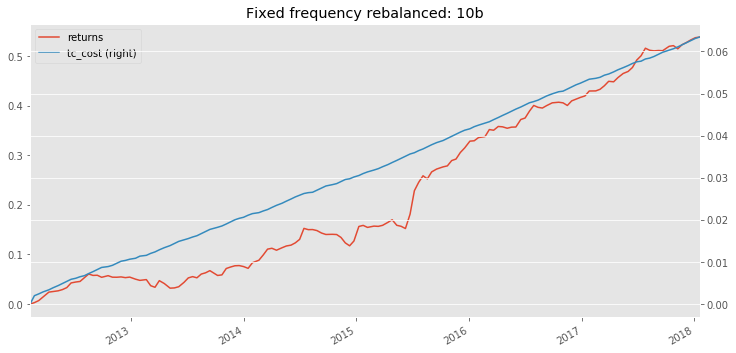

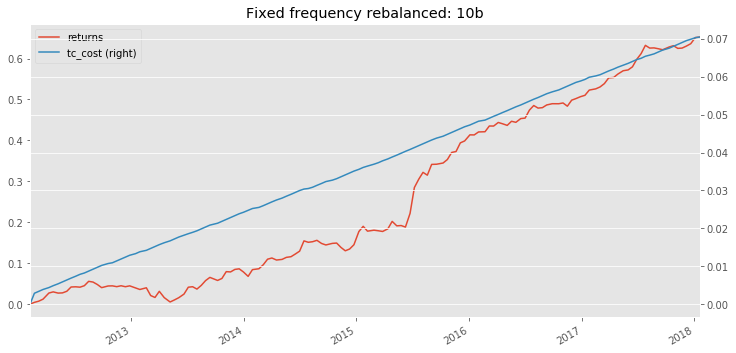

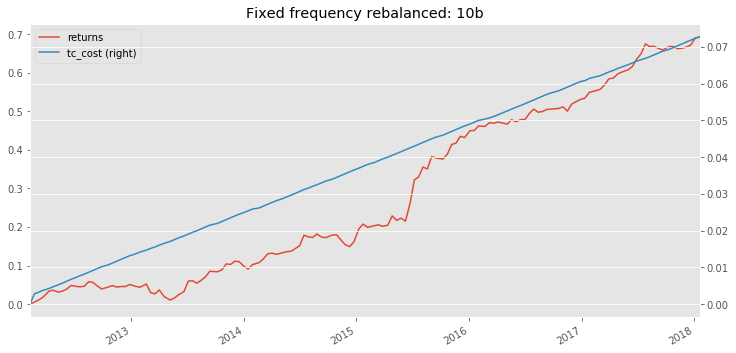

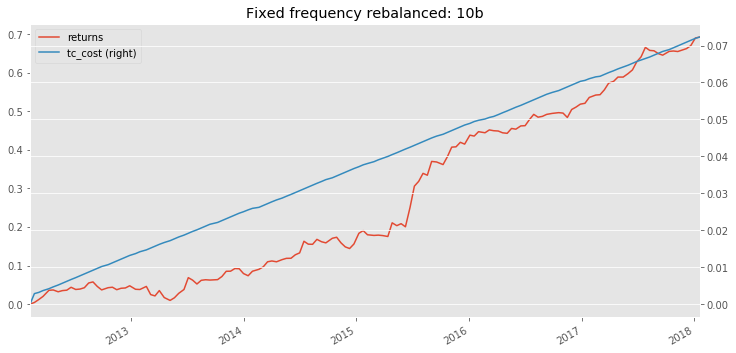

In [16]:
# Predicting and re-balance phase

weight_gaps = [0.01, 0.02, 0.03, 0.04]

model1_weight = 1.0
model2_weight = 0.5

factor_groups = const_model_factor_data.groupby('trade_date')
turn_over_target_base = 0.25
size_risk_lower = 0
size_risk_upper = 0
benchmark_total_lower = 0.8
benchmark_total_upper = 1.
industry_lower = 1.
industry_upper = 1.

for weight_gap in weight_gaps:
    print("start {0} weight gap simulation ...".format(weight_gap))

    rets = []
    turn_overs = []
    leverags = []
    previous_pos = pd.DataFrame()

    index_dates = []

    for i, value in enumerate(factor_groups):
        date = value[0]
        data = value[1]
        ref_date = date.strftime('%Y-%m-%d')

        total_data = data.fillna(data[const_features_keys].median())
        alpha_logger.info('{0}: {1}'.format(date, len(total_data)))
        risk_exp = total_data[neutralize_risk].values.astype(float)
        industry = total_data.industry_code.values
        benchmark_w = total_data.weight.values

        constraint_exp = total_data[constraint_risk].values
        risk_exp_expand = np.concatenate((constraint_exp, np.ones((len(risk_exp), 1))), axis=1).astype(float)

        risk_names = constraint_risk + ['total']
        risk_target = risk_exp_expand.T @ benchmark_w

        lbound = np.maximum(0., benchmark_w - weight_gap)  # np.zeros(len(total_data))
        ubound = weight_gap + benchmark_w

        is_in_benchmark = (benchmark_w > 0.).astype(float)

        risk_exp_expand = np.concatenate((risk_exp_expand, is_in_benchmark.reshape((-1, 1))), axis=1).astype(float)
        risk_names.append('benchmark_total')

        constraint = Constraints(risk_exp_expand, risk_names)

        for i, name in enumerate(risk_names):
            if name == 'total':
                constraint.set_constraints(name,
                                           lower_bound=risk_target[i],
                                           upper_bound=risk_target[i])
            elif name == 'SIZE':
                base_target = abs(risk_target[i])
                constraint.set_constraints(name,
                                           lower_bound=risk_target[i] + base_target * size_risk_lower,
                                           upper_bound=risk_target[i] + base_target * size_risk_upper)
            elif name == 'benchmark_total':
                base_target = benchmark_w.sum()
                constraint.set_constraints(name,
                                           lower_bound=benchmark_total_lower * base_target,
                                           upper_bound=benchmark_total_upper * base_target)
            else:
                constraint.set_constraints(name,
                                           lower_bound=risk_target[i] * industry_lower,
                                           upper_bound=risk_target[i] * industry_upper)
        
        factor_values = factor_processing(total_data[const_features_keys].values,
                                          pre_process=[winsorize_normal, standardize],
                                          risk_factors=risk_exp,
                                          post_process=[winsorize_normal, standardize])

        # const linear model
        er1 = const_model.predict(factor_values)
        
        try:
            model = models_series.ix[date]
        except KeyError:
            alpha_logger.info("model is not available. Omit this date")
            continue
            
        index_dates.append(date)

        x = predict_x[date]
        this_risk = predict_risk[date][:, 2:]
        this_predict_code = predict_code[date]
        
        new_x = cross_product(x, this_risk)
        er2 = model.predict(new_x)

        # combine model
        er1_table = pd.DataFrame({'er1': er1, 'code': total_data.code.values})
        er2_table = pd.DataFrame({'er2': er2, 'code': this_predict_code})
        er_table = pd.merge(er1_table, er2_table, on=['code'], how='left').fillna(0)

        er1 = er_table.er1.values
        er2 = er_table.er2.values
        
        if er2.std() > 0:
            print('using backbone model and alpha model')
            er = model1_weight * er1 / er1.std() +  model2_weight * er2 / er2.std()
        else:
            print('using only backbone modedl')
            er = model1_weight * er1
            
        codes = total_data['code'].values

        if previous_pos.empty:
            current_position = None
            turn_over_target = None
        else:
            previous_pos.set_index('code', inplace=True)
            remained_pos = previous_pos.loc[codes]

            remained_pos.fillna(0., inplace=True)
            turn_over_target = turn_over_target_base
            current_position = remained_pos.weight.values

        try:
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  turn_over_target=turn_over_target,
                                                  current_position=current_position,
                                                  lbound=lbound,
                                                  ubound=ubound)
        except ValueError:
            alpha_logger.info('{0} full re-balance'.format(date))
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  use_rank=use_rank,
                                                  lbound=lbound,
                                                  ubound=ubound)

        target_pos['code'] = total_data['code'].values

        turn_over, executed_pos = executor.execute(target_pos=target_pos)

        executed_codes = executed_pos.code.tolist()
        dx_returns = engine.fetch_dx_return(date, executed_codes, horizon=horizon, offset=1)

        result = pd.merge(executed_pos, total_data[['code', 'weight']], on=['code'], how='inner')
        result = pd.merge(result, dx_returns, on=['code'])

        leverage = result.weight_x.abs().sum()

        ret = result.weight_x.values @ (np.exp(result.dx.values) - 1.)
        rets.append(np.log(1. + ret))
        executor.set_current(executed_pos)
        turn_overs.append(turn_over)
        leverags.append(leverage)

        previous_pos = executed_pos
        alpha_logger.info('{0} is finished'.format(date))

    ret_df = pd.DataFrame({'returns': rets, 'turn_over': turn_overs, 'leverage': leverags}, index=index_dates)

    # index return
    index_return = engine.fetch_dx_return_index_range(benchmark_code, start_date, end_date, horizon=horizon,
                                                      offset=1).set_index('trade_date')
    ret_df['index'] = index_return['dx']

    ret_df.loc[advanceDateByCalendar('china.sse', ref_dates[-1], frequency)] = 0.
    ret_df = ret_df.shift(1)
    ret_df.iloc[0] = 0.
    ret_df['tc_cost'] = ret_df.turn_over * 0.002
    ret_df['returns'] = ret_df['leverage'] * (ret_df['returns'] - ret_df['index'])

    ret_df[['returns', 'tc_cost']].cumsum().plot(figsize=(12, 6),
                                                 title='Fixed frequency rebalanced: {0}'.format(frequency),
                                                 secondary_y='tc_cost')

    ret_df['ret_after_tc'] = ret_df['returns'] - ret_df['tc_cost']
    

    sharp_calc = MovingSharp(49)
    drawdown_calc = MovingMaxDrawdown(49)
    max_drawdown_calc = MovingMaxDrawdown(len(ret_df))

    res_df = pd.DataFrame(columns=['daily_return', 'cum_ret', 'sharp', 'drawdown', 'max_drawn', 'leverage'])

    total_returns = 0.

    for i, ret in enumerate(ret_df['ret_after_tc']):
        date = ret_df.index[i]
        total_returns += ret
        sharp_calc.push({'ret': ret, 'riskFree': 0.})
        drawdown_calc.push({'ret': ret})
        max_drawdown_calc.push({'ret': ret})

        res_df.loc[date, 'daily_return'] = ret
        res_df.loc[date, 'cum_ret'] = total_returns
        res_df.loc[date, 'drawdown'] = drawdown_calc.result()[0]
        res_df.loc[date, 'max_drawn'] = max_drawdown_calc.result()[0]
        res_df.loc[date, 'leverage'] = ret_df.loc[date, 'leverage']

        if i < 10:
            res_df.loc[date, 'sharp'] = 0.
        else:
            res_df.loc[date, 'sharp'] = sharp_calc.result() * np.sqrt(49)

    res_df.to_csv('hs300_rf2_{0}.csv'.format(int(weight_gap * 100)))

## Lasso Regression
----------

In [17]:
"""
Training phase
"""

models_series = pd.Series()
previous_model = None

for ref_date in ref_dates:
    x = train_x[ref_date]
    y = train_y[ref_date]
    risk = train_risk[ref_date][:, 2:]
    new_x = cross_product(x, risk)
    if len(x) > 5 * len(model_features_keys):
        model = LassoRegression(alpha=0.01, features=model_features_keys, fit_intercept=True) 
        model.fit(new_x, y)
        models_series.loc[ref_date] = model
        previous_model = copy.deepcopy(model)
    else:
        models_series.loc[ref_date] = previous_model
    
    alpha_logger.info('trade_date: {0} with {1} obs training finished'.format(ref_date, len(x)))

2018-01-11 16:10:48,636 - ALPHA_MIND - INFO - trade_date: 2012-02-08 00:00:00 with 10700 obs training finished
2018-01-11 16:10:48,711 - ALPHA_MIND - INFO - trade_date: 2012-02-22 00:00:00 with 10702 obs training finished
2018-01-11 16:10:48,781 - ALPHA_MIND - INFO - trade_date: 2012-03-07 00:00:00 with 10694 obs training finished
2018-01-11 16:10:48,854 - ALPHA_MIND - INFO - trade_date: 2012-03-21 00:00:00 with 10678 obs training finished
2018-01-11 16:10:48,930 - ALPHA_MIND - INFO - trade_date: 2012-04-09 00:00:00 with 10661 obs training finished
2018-01-11 16:10:49,006 - ALPHA_MIND - INFO - trade_date: 2012-04-23 00:00:00 with 10655 obs training finished
2018-01-11 16:10:49,081 - ALPHA_MIND - INFO - trade_date: 2012-05-09 00:00:00 with 11102 obs training finished
2018-01-11 16:10:49,162 - ALPHA_MIND - INFO - trade_date: 2012-05-23 00:00:00 with 11087 obs training finished
2018-01-11 16:10:49,245 - ALPHA_MIND - INFO - trade_date: 2012-06-06 00:00:00 with 11070 obs training finished
2

2018-01-11 16:10:54,206 - ALPHA_MIND - INFO - trade_date: 2015-02-27 00:00:00 with 10900 obs training finished
2018-01-11 16:10:54,280 - ALPHA_MIND - INFO - trade_date: 2015-03-13 00:00:00 with 10894 obs training finished
2018-01-11 16:10:54,353 - ALPHA_MIND - INFO - trade_date: 2015-03-27 00:00:00 with 10886 obs training finished
2018-01-11 16:10:54,430 - ALPHA_MIND - INFO - trade_date: 2015-04-13 00:00:00 with 10885 obs training finished
2018-01-11 16:10:54,510 - ALPHA_MIND - INFO - trade_date: 2015-04-27 00:00:00 with 10886 obs training finished
2018-01-11 16:10:54,583 - ALPHA_MIND - INFO - trade_date: 2015-05-12 00:00:00 with 10889 obs training finished
2018-01-11 16:10:54,665 - ALPHA_MIND - INFO - trade_date: 2015-05-26 00:00:00 with 10881 obs training finished
2018-01-11 16:10:54,736 - ALPHA_MIND - INFO - trade_date: 2015-06-09 00:00:00 with 10872 obs training finished
2018-01-11 16:10:54,812 - ALPHA_MIND - INFO - trade_date: 2015-06-24 00:00:00 with 10870 obs training finished
2

2018-01-11 16:11:01,009 - ALPHA_MIND - INFO - 2012-02-08 00:00:00: 800


start 0.01 weight gap simulation ...
using backbone model and alpha model


D:\ProgramData\IntelPython3_2018\lib\site-packages\ipykernel_launcher.py:76: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
2018-01-11 16:11:01,221 - ALPHA_MIND - INFO - 2012-02-08 00:00:00 is finished
2018-01-11 16:11:01,227 - ALPHA_MIND - INFO - 2012-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:01,547 - ALPHA_MIND - INFO - 2012-02-22 00:00:00 is finished
2018-01-11 16:11:01,552 - ALPHA_MIND - INFO - 2012-03-07 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:11:01,843 - ALPHA_MIND - INFO - 2012-03-07 00:00:00 is finished
2018-01-11 16:11:01,850 - ALPHA_MIND - INFO - 2012-03-21 00:00:00: 798


using backbone model and alpha model


2018-01-11 16:11:02,151 - ALPHA_MIND - INFO - 2012-03-21 00:00:00 is finished
2018-01-11 16:11:02,157 - ALPHA_MIND - INFO - 2012-04-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:02,464 - ALPHA_MIND - INFO - 2012-04-09 00:00:00 is finished
2018-01-11 16:11:02,471 - ALPHA_MIND - INFO - 2012-04-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:02,773 - ALPHA_MIND - INFO - 2012-04-23 00:00:00 is finished
2018-01-11 16:11:02,780 - ALPHA_MIND - INFO - 2012-05-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:03,100 - ALPHA_MIND - INFO - 2012-05-09 00:00:00 is finished
2018-01-11 16:11:03,107 - ALPHA_MIND - INFO - 2012-05-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:03,419 - ALPHA_MIND - INFO - 2012-05-23 00:00:00 is finished
2018-01-11 16:11:03,426 - ALPHA_MIND - INFO - 2012-06-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:03,733 - ALPHA_MIND - INFO - 2012-06-06 00:00:00 is finished
2018-01-11 16:11:03,740 - ALPHA_MIND - INFO - 2012-06-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:04,047 - ALPHA_MIND - INFO - 2012-06-20 00:00:00 is finished
2018-01-11 16:11:04,053 - ALPHA_MIND - INFO - 2012-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:05,255 - ALPHA_MIND - INFO - 2012-07-05 00:00:00 is finished
2018-01-11 16:11:05,262 - ALPHA_MIND - INFO - 2012-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:05,587 - ALPHA_MIND - INFO - 2012-07-19 00:00:00 is finished
2018-01-11 16:11:05,594 - ALPHA_MIND - INFO - 2012-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:05,919 - ALPHA_MIND - INFO - 2012-08-02 00:00:00 is finished
2018-01-11 16:11:05,926 - ALPHA_MIND - INFO - 2012-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:06,251 - ALPHA_MIND - INFO - 2012-08-16 00:00:00 is finished
2018-01-11 16:11:06,257 - ALPHA_MIND - INFO - 2012-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:06,595 - ALPHA_MIND - INFO - 2012-08-30 00:00:00 is finished
2018-01-11 16:11:06,603 - ALPHA_MIND - INFO - 2012-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:06,936 - ALPHA_MIND - INFO - 2012-09-13 00:00:00 is finished
2018-01-11 16:11:06,944 - ALPHA_MIND - INFO - 2012-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:07,268 - ALPHA_MIND - INFO - 2012-09-27 00:00:00 is finished
2018-01-11 16:11:07,274 - ALPHA_MIND - INFO - 2012-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:07,578 - ALPHA_MIND - INFO - 2012-10-18 00:00:00 is finished
2018-01-11 16:11:07,585 - ALPHA_MIND - INFO - 2012-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:07,894 - ALPHA_MIND - INFO - 2012-11-01 00:00:00 is finished
2018-01-11 16:11:07,901 - ALPHA_MIND - INFO - 2012-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:08,208 - ALPHA_MIND - INFO - 2012-11-15 00:00:00 is finished
2018-01-11 16:11:08,215 - ALPHA_MIND - INFO - 2012-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:08,530 - ALPHA_MIND - INFO - 2012-11-29 00:00:00 is finished
2018-01-11 16:11:08,536 - ALPHA_MIND - INFO - 2012-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:08,837 - ALPHA_MIND - INFO - 2012-12-13 00:00:00 is finished
2018-01-11 16:11:08,843 - ALPHA_MIND - INFO - 2012-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:09,152 - ALPHA_MIND - INFO - 2012-12-27 00:00:00 is finished
2018-01-11 16:11:09,158 - ALPHA_MIND - INFO - 2013-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:09,478 - ALPHA_MIND - INFO - 2013-01-15 00:00:00 is finished
2018-01-11 16:11:09,485 - ALPHA_MIND - INFO - 2013-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:09,786 - ALPHA_MIND - INFO - 2013-01-29 00:00:00 is finished
2018-01-11 16:11:09,793 - ALPHA_MIND - INFO - 2013-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:10,173 - ALPHA_MIND - INFO - 2013-02-19 00:00:00 is finished
2018-01-11 16:11:10,178 - ALPHA_MIND - INFO - 2013-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:10,464 - ALPHA_MIND - INFO - 2013-03-05 00:00:00 is finished
2018-01-11 16:11:10,469 - ALPHA_MIND - INFO - 2013-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:10,750 - ALPHA_MIND - INFO - 2013-03-19 00:00:00 is finished
2018-01-11 16:11:10,757 - ALPHA_MIND - INFO - 2013-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:11,072 - ALPHA_MIND - INFO - 2013-04-02 00:00:00 is finished
2018-01-11 16:11:11,077 - ALPHA_MIND - INFO - 2013-04-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:11,361 - ALPHA_MIND - INFO - 2013-04-18 00:00:00 is finished
2018-01-11 16:11:11,367 - ALPHA_MIND - INFO - 2013-05-07 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:11,638 - ALPHA_MIND - INFO - 2013-05-07 00:00:00 is finished
2018-01-11 16:11:11,644 - ALPHA_MIND - INFO - 2013-05-21 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:11,924 - ALPHA_MIND - INFO - 2013-05-21 00:00:00 is finished
2018-01-11 16:11:11,929 - ALPHA_MIND - INFO - 2013-06-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:12,237 - ALPHA_MIND - INFO - 2013-06-04 00:00:00 is finished
2018-01-11 16:11:12,247 - ALPHA_MIND - INFO - 2013-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:12,554 - ALPHA_MIND - INFO - 2013-06-21 00:00:00 is finished
2018-01-11 16:11:12,559 - ALPHA_MIND - INFO - 2013-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:12,845 - ALPHA_MIND - INFO - 2013-07-05 00:00:00 is finished
2018-01-11 16:11:12,851 - ALPHA_MIND - INFO - 2013-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:13,142 - ALPHA_MIND - INFO - 2013-07-19 00:00:00 is finished
2018-01-11 16:11:13,148 - ALPHA_MIND - INFO - 2013-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:13,452 - ALPHA_MIND - INFO - 2013-08-02 00:00:00 is finished
2018-01-11 16:11:13,458 - ALPHA_MIND - INFO - 2013-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:13,751 - ALPHA_MIND - INFO - 2013-08-16 00:00:00 is finished
2018-01-11 16:11:13,757 - ALPHA_MIND - INFO - 2013-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:14,052 - ALPHA_MIND - INFO - 2013-08-30 00:00:00 is finished
2018-01-11 16:11:14,058 - ALPHA_MIND - INFO - 2013-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:14,335 - ALPHA_MIND - INFO - 2013-09-13 00:00:00 is finished
2018-01-11 16:11:14,340 - ALPHA_MIND - INFO - 2013-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:14,737 - ALPHA_MIND - INFO - 2013-10-08 00:00:00 is finished
2018-01-11 16:11:14,743 - ALPHA_MIND - INFO - 2013-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:15,035 - ALPHA_MIND - INFO - 2013-10-22 00:00:00 is finished
2018-01-11 16:11:15,041 - ALPHA_MIND - INFO - 2013-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:15,354 - ALPHA_MIND - INFO - 2013-11-05 00:00:00 is finished
2018-01-11 16:11:15,360 - ALPHA_MIND - INFO - 2013-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:15,651 - ALPHA_MIND - INFO - 2013-11-19 00:00:00 is finished
2018-01-11 16:11:15,656 - ALPHA_MIND - INFO - 2013-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:15,936 - ALPHA_MIND - INFO - 2013-12-03 00:00:00 is finished
2018-01-11 16:11:15,942 - ALPHA_MIND - INFO - 2013-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:16,218 - ALPHA_MIND - INFO - 2013-12-17 00:00:00 is finished
2018-01-11 16:11:16,223 - ALPHA_MIND - INFO - 2013-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:16,507 - ALPHA_MIND - INFO - 2013-12-31 00:00:00 is finished
2018-01-11 16:11:16,512 - ALPHA_MIND - INFO - 2014-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:16,795 - ALPHA_MIND - INFO - 2014-01-15 00:00:00 is finished
2018-01-11 16:11:16,800 - ALPHA_MIND - INFO - 2014-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:17,088 - ALPHA_MIND - INFO - 2014-01-29 00:00:00 is finished
2018-01-11 16:11:17,093 - ALPHA_MIND - INFO - 2014-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:17,376 - ALPHA_MIND - INFO - 2014-02-19 00:00:00 is finished
2018-01-11 16:11:17,381 - ALPHA_MIND - INFO - 2014-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:17,660 - ALPHA_MIND - INFO - 2014-03-05 00:00:00 is finished
2018-01-11 16:11:17,666 - ALPHA_MIND - INFO - 2014-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:17,960 - ALPHA_MIND - INFO - 2014-03-19 00:00:00 is finished
2018-01-11 16:11:17,965 - ALPHA_MIND - INFO - 2014-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:18,278 - ALPHA_MIND - INFO - 2014-04-02 00:00:00 is finished
2018-01-11 16:11:18,284 - ALPHA_MIND - INFO - 2014-04-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:18,573 - ALPHA_MIND - INFO - 2014-04-17 00:00:00 is finished
2018-01-11 16:11:18,578 - ALPHA_MIND - INFO - 2014-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:18,853 - ALPHA_MIND - INFO - 2014-05-05 00:00:00 is finished
2018-01-11 16:11:18,857 - ALPHA_MIND - INFO - 2014-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:19,244 - ALPHA_MIND - INFO - 2014-05-19 00:00:00 is finished
2018-01-11 16:11:19,249 - ALPHA_MIND - INFO - 2014-06-03 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:19,549 - ALPHA_MIND - INFO - 2014-06-03 00:00:00 is finished
2018-01-11 16:11:19,554 - ALPHA_MIND - INFO - 2014-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:19,843 - ALPHA_MIND - INFO - 2014-06-17 00:00:00 is finished
2018-01-11 16:11:19,849 - ALPHA_MIND - INFO - 2014-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:20,154 - ALPHA_MIND - INFO - 2014-07-01 00:00:00 is finished
2018-01-11 16:11:20,161 - ALPHA_MIND - INFO - 2014-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:20,471 - ALPHA_MIND - INFO - 2014-07-15 00:00:00 is finished
2018-01-11 16:11:20,477 - ALPHA_MIND - INFO - 2014-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:20,768 - ALPHA_MIND - INFO - 2014-07-29 00:00:00 is finished
2018-01-11 16:11:20,774 - ALPHA_MIND - INFO - 2014-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:21,090 - ALPHA_MIND - INFO - 2014-08-12 00:00:00 is finished
2018-01-11 16:11:21,095 - ALPHA_MIND - INFO - 2014-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:21,399 - ALPHA_MIND - INFO - 2014-08-26 00:00:00 is finished
2018-01-11 16:11:21,405 - ALPHA_MIND - INFO - 2014-09-10 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:21,696 - ALPHA_MIND - INFO - 2014-09-10 00:00:00 is finished
2018-01-11 16:11:21,701 - ALPHA_MIND - INFO - 2014-09-24 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:21,983 - ALPHA_MIND - INFO - 2014-09-24 00:00:00 is finished
2018-01-11 16:11:21,989 - ALPHA_MIND - INFO - 2014-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:22,287 - ALPHA_MIND - INFO - 2014-10-15 00:00:00 is finished
2018-01-11 16:11:22,293 - ALPHA_MIND - INFO - 2014-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:22,598 - ALPHA_MIND - INFO - 2014-10-29 00:00:00 is finished
2018-01-11 16:11:22,604 - ALPHA_MIND - INFO - 2014-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:22,923 - ALPHA_MIND - INFO - 2014-11-12 00:00:00 is finished
2018-01-11 16:11:22,930 - ALPHA_MIND - INFO - 2014-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:23,232 - ALPHA_MIND - INFO - 2014-11-26 00:00:00 is finished
2018-01-11 16:11:23,237 - ALPHA_MIND - INFO - 2014-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:23,530 - ALPHA_MIND - INFO - 2014-12-10 00:00:00 is finished
2018-01-11 16:11:23,536 - ALPHA_MIND - INFO - 2014-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:23,949 - ALPHA_MIND - INFO - 2014-12-24 00:00:00 is finished
2018-01-11 16:11:23,954 - ALPHA_MIND - INFO - 2015-01-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:24,244 - ALPHA_MIND - INFO - 2015-01-09 00:00:00 is finished
2018-01-11 16:11:24,250 - ALPHA_MIND - INFO - 2015-01-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:24,568 - ALPHA_MIND - INFO - 2015-01-23 00:00:00 is finished
2018-01-11 16:11:24,575 - ALPHA_MIND - INFO - 2015-02-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:24,886 - ALPHA_MIND - INFO - 2015-02-06 00:00:00 is finished
2018-01-11 16:11:24,892 - ALPHA_MIND - INFO - 2015-02-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:25,193 - ALPHA_MIND - INFO - 2015-02-27 00:00:00 is finished
2018-01-11 16:11:25,198 - ALPHA_MIND - INFO - 2015-03-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:25,492 - ALPHA_MIND - INFO - 2015-03-13 00:00:00 is finished
2018-01-11 16:11:25,497 - ALPHA_MIND - INFO - 2015-03-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:25,785 - ALPHA_MIND - INFO - 2015-03-27 00:00:00 is finished
2018-01-11 16:11:25,792 - ALPHA_MIND - INFO - 2015-04-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:26,089 - ALPHA_MIND - INFO - 2015-04-13 00:00:00 is finished
2018-01-11 16:11:26,094 - ALPHA_MIND - INFO - 2015-04-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:26,393 - ALPHA_MIND - INFO - 2015-04-27 00:00:00 is finished
2018-01-11 16:11:26,399 - ALPHA_MIND - INFO - 2015-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:26,703 - ALPHA_MIND - INFO - 2015-05-12 00:00:00 is finished
2018-01-11 16:11:26,709 - ALPHA_MIND - INFO - 2015-05-26 00:00:00: 798


using backbone model and alpha model


2018-01-11 16:11:27,011 - ALPHA_MIND - INFO - 2015-05-26 00:00:00 is finished
2018-01-11 16:11:27,016 - ALPHA_MIND - INFO - 2015-06-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:27,311 - ALPHA_MIND - INFO - 2015-06-09 00:00:00 is finished
2018-01-11 16:11:27,315 - ALPHA_MIND - INFO - 2015-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:27,612 - ALPHA_MIND - INFO - 2015-06-24 00:00:00 is finished
2018-01-11 16:11:27,618 - ALPHA_MIND - INFO - 2015-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:27,909 - ALPHA_MIND - INFO - 2015-07-08 00:00:00 is finished
2018-01-11 16:11:27,914 - ALPHA_MIND - INFO - 2015-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:28,200 - ALPHA_MIND - INFO - 2015-07-22 00:00:00 is finished
2018-01-11 16:11:28,205 - ALPHA_MIND - INFO - 2015-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:28,577 - ALPHA_MIND - INFO - 2015-08-05 00:00:00 is finished
2018-01-11 16:11:28,582 - ALPHA_MIND - INFO - 2015-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:28,877 - ALPHA_MIND - INFO - 2015-08-19 00:00:00 is finished
2018-01-11 16:11:28,882 - ALPHA_MIND - INFO - 2015-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:29,188 - ALPHA_MIND - INFO - 2015-09-02 00:00:00 is finished
2018-01-11 16:11:29,194 - ALPHA_MIND - INFO - 2015-09-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:29,489 - ALPHA_MIND - INFO - 2015-09-18 00:00:00 is finished
2018-01-11 16:11:29,494 - ALPHA_MIND - INFO - 2015-10-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:29,805 - ALPHA_MIND - INFO - 2015-10-09 00:00:00 is finished
2018-01-11 16:11:29,809 - ALPHA_MIND - INFO - 2015-10-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:30,103 - ALPHA_MIND - INFO - 2015-10-23 00:00:00 is finished
2018-01-11 16:11:30,109 - ALPHA_MIND - INFO - 2015-11-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:30,422 - ALPHA_MIND - INFO - 2015-11-06 00:00:00 is finished
2018-01-11 16:11:30,429 - ALPHA_MIND - INFO - 2015-11-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:30,732 - ALPHA_MIND - INFO - 2015-11-20 00:00:00 is finished
2018-01-11 16:11:30,738 - ALPHA_MIND - INFO - 2015-12-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:31,041 - ALPHA_MIND - INFO - 2015-12-04 00:00:00 is finished
2018-01-11 16:11:31,047 - ALPHA_MIND - INFO - 2015-12-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:31,352 - ALPHA_MIND - INFO - 2015-12-18 00:00:00 is finished
2018-01-11 16:11:31,358 - ALPHA_MIND - INFO - 2016-01-04 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:11:31,630 - ALPHA_MIND - INFO - 2016-01-04 00:00:00 is finished
2018-01-11 16:11:31,635 - ALPHA_MIND - INFO - 2016-01-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:31,947 - ALPHA_MIND - INFO - 2016-01-18 00:00:00 is finished
2018-01-11 16:11:31,952 - ALPHA_MIND - INFO - 2016-02-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:32,262 - ALPHA_MIND - INFO - 2016-02-01 00:00:00 is finished
2018-01-11 16:11:32,266 - ALPHA_MIND - INFO - 2016-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:32,579 - ALPHA_MIND - INFO - 2016-02-22 00:00:00 is finished
2018-01-11 16:11:32,584 - ALPHA_MIND - INFO - 2016-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:32,877 - ALPHA_MIND - INFO - 2016-03-07 00:00:00 is finished
2018-01-11 16:11:32,883 - ALPHA_MIND - INFO - 2016-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:33,290 - ALPHA_MIND - INFO - 2016-03-21 00:00:00 is finished
2018-01-11 16:11:33,295 - ALPHA_MIND - INFO - 2016-04-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:33,609 - ALPHA_MIND - INFO - 2016-04-05 00:00:00 is finished
2018-01-11 16:11:33,613 - ALPHA_MIND - INFO - 2016-04-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:33,905 - ALPHA_MIND - INFO - 2016-04-19 00:00:00 is finished
2018-01-11 16:11:33,910 - ALPHA_MIND - INFO - 2016-05-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:34,215 - ALPHA_MIND - INFO - 2016-05-04 00:00:00 is finished
2018-01-11 16:11:34,219 - ALPHA_MIND - INFO - 2016-05-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:34,524 - ALPHA_MIND - INFO - 2016-05-18 00:00:00 is finished
2018-01-11 16:11:34,529 - ALPHA_MIND - INFO - 2016-06-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:34,834 - ALPHA_MIND - INFO - 2016-06-01 00:00:00 is finished
2018-01-11 16:11:34,840 - ALPHA_MIND - INFO - 2016-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:35,144 - ALPHA_MIND - INFO - 2016-06-17 00:00:00 is finished
2018-01-11 16:11:35,150 - ALPHA_MIND - INFO - 2016-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:35,453 - ALPHA_MIND - INFO - 2016-07-01 00:00:00 is finished
2018-01-11 16:11:35,459 - ALPHA_MIND - INFO - 2016-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:35,755 - ALPHA_MIND - INFO - 2016-07-15 00:00:00 is finished
2018-01-11 16:11:35,760 - ALPHA_MIND - INFO - 2016-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:36,054 - ALPHA_MIND - INFO - 2016-07-29 00:00:00 is finished
2018-01-11 16:11:36,059 - ALPHA_MIND - INFO - 2016-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:36,362 - ALPHA_MIND - INFO - 2016-08-12 00:00:00 is finished
2018-01-11 16:11:36,368 - ALPHA_MIND - INFO - 2016-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:36,671 - ALPHA_MIND - INFO - 2016-08-26 00:00:00 is finished
2018-01-11 16:11:36,676 - ALPHA_MIND - INFO - 2016-09-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:36,981 - ALPHA_MIND - INFO - 2016-09-09 00:00:00 is finished
2018-01-11 16:11:36,988 - ALPHA_MIND - INFO - 2016-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:37,289 - ALPHA_MIND - INFO - 2016-09-27 00:00:00 is finished
2018-01-11 16:11:37,294 - ALPHA_MIND - INFO - 2016-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:37,593 - ALPHA_MIND - INFO - 2016-10-18 00:00:00 is finished
2018-01-11 16:11:37,597 - ALPHA_MIND - INFO - 2016-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:38,015 - ALPHA_MIND - INFO - 2016-11-01 00:00:00 is finished
2018-01-11 16:11:38,021 - ALPHA_MIND - INFO - 2016-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:38,340 - ALPHA_MIND - INFO - 2016-11-15 00:00:00 is finished
2018-01-11 16:11:38,346 - ALPHA_MIND - INFO - 2016-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:38,656 - ALPHA_MIND - INFO - 2016-11-29 00:00:00 is finished
2018-01-11 16:11:38,662 - ALPHA_MIND - INFO - 2016-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:38,978 - ALPHA_MIND - INFO - 2016-12-13 00:00:00 is finished
2018-01-11 16:11:38,983 - ALPHA_MIND - INFO - 2016-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:39,294 - ALPHA_MIND - INFO - 2016-12-27 00:00:00 is finished
2018-01-11 16:11:39,301 - ALPHA_MIND - INFO - 2017-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:39,609 - ALPHA_MIND - INFO - 2017-01-11 00:00:00 is finished
2018-01-11 16:11:39,615 - ALPHA_MIND - INFO - 2017-01-25 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:11:39,890 - ALPHA_MIND - INFO - 2017-01-25 00:00:00 is finished
2018-01-11 16:11:39,896 - ALPHA_MIND - INFO - 2017-02-15 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:11:40,183 - ALPHA_MIND - INFO - 2017-02-15 00:00:00 is finished
2018-01-11 16:11:40,189 - ALPHA_MIND - INFO - 2017-03-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:40,491 - ALPHA_MIND - INFO - 2017-03-01 00:00:00 is finished
2018-01-11 16:11:40,496 - ALPHA_MIND - INFO - 2017-03-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:40,812 - ALPHA_MIND - INFO - 2017-03-15 00:00:00 is finished
2018-01-11 16:11:40,818 - ALPHA_MIND - INFO - 2017-03-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:41,126 - ALPHA_MIND - INFO - 2017-03-29 00:00:00 is finished
2018-01-11 16:11:41,132 - ALPHA_MIND - INFO - 2017-04-14 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:41,444 - ALPHA_MIND - INFO - 2017-04-14 00:00:00 is finished
2018-01-11 16:11:41,450 - ALPHA_MIND - INFO - 2017-04-28 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:41,747 - ALPHA_MIND - INFO - 2017-04-28 00:00:00 is finished
2018-01-11 16:11:41,753 - ALPHA_MIND - INFO - 2017-05-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:42,058 - ALPHA_MIND - INFO - 2017-05-15 00:00:00 is finished
2018-01-11 16:11:42,063 - ALPHA_MIND - INFO - 2017-05-31 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:42,365 - ALPHA_MIND - INFO - 2017-05-31 00:00:00 is finished
2018-01-11 16:11:42,370 - ALPHA_MIND - INFO - 2017-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:42,782 - ALPHA_MIND - INFO - 2017-06-14 00:00:00 is finished
2018-01-11 16:11:42,787 - ALPHA_MIND - INFO - 2017-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:43,091 - ALPHA_MIND - INFO - 2017-06-28 00:00:00 is finished
2018-01-11 16:11:43,096 - ALPHA_MIND - INFO - 2017-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:43,399 - ALPHA_MIND - INFO - 2017-07-12 00:00:00 is finished
2018-01-11 16:11:43,405 - ALPHA_MIND - INFO - 2017-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:43,698 - ALPHA_MIND - INFO - 2017-07-26 00:00:00 is finished
2018-01-11 16:11:43,705 - ALPHA_MIND - INFO - 2017-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:44,022 - ALPHA_MIND - INFO - 2017-08-09 00:00:00 is finished
2018-01-11 16:11:44,027 - ALPHA_MIND - INFO - 2017-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:44,334 - ALPHA_MIND - INFO - 2017-08-23 00:00:00 is finished
2018-01-11 16:11:44,339 - ALPHA_MIND - INFO - 2017-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:44,662 - ALPHA_MIND - INFO - 2017-09-06 00:00:00 is finished
2018-01-11 16:11:44,668 - ALPHA_MIND - INFO - 2017-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:44,962 - ALPHA_MIND - INFO - 2017-09-20 00:00:00 is finished
2018-01-11 16:11:44,967 - ALPHA_MIND - INFO - 2017-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:45,277 - ALPHA_MIND - INFO - 2017-10-11 00:00:00 is finished
2018-01-11 16:11:45,283 - ALPHA_MIND - INFO - 2017-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:45,595 - ALPHA_MIND - INFO - 2017-10-25 00:00:00 is finished
2018-01-11 16:11:45,601 - ALPHA_MIND - INFO - 2017-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:45,899 - ALPHA_MIND - INFO - 2017-11-08 00:00:00 is finished
2018-01-11 16:11:45,905 - ALPHA_MIND - INFO - 2017-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:46,210 - ALPHA_MIND - INFO - 2017-11-22 00:00:00 is finished
2018-01-11 16:11:46,216 - ALPHA_MIND - INFO - 2017-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:46,525 - ALPHA_MIND - INFO - 2017-12-06 00:00:00 is finished
2018-01-11 16:11:46,529 - ALPHA_MIND - INFO - 2017-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:46,833 - ALPHA_MIND - INFO - 2017-12-20 00:00:00 is finished
2018-01-11 16:11:46,839 - ALPHA_MIND - INFO - 2018-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:47,077 - ALPHA_MIND - INFO - 2018-01-04 00:00:00 is finished
2018-01-11 16:11:47,751 - ALPHA_MIND - INFO - 2012-02-08 00:00:00: 800


start 0.02 weight gap simulation ...
using backbone model and alpha model


2018-01-11 16:11:47,953 - ALPHA_MIND - INFO - 2012-02-08 00:00:00 is finished
2018-01-11 16:11:47,960 - ALPHA_MIND - INFO - 2012-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:48,240 - ALPHA_MIND - INFO - 2012-02-22 00:00:00 is finished
2018-01-11 16:11:48,244 - ALPHA_MIND - INFO - 2012-03-07 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:11:48,526 - ALPHA_MIND - INFO - 2012-03-07 00:00:00 is finished
2018-01-11 16:11:48,532 - ALPHA_MIND - INFO - 2012-03-21 00:00:00: 798


using backbone model and alpha model


2018-01-11 16:11:48,822 - ALPHA_MIND - INFO - 2012-03-21 00:00:00 is finished
2018-01-11 16:11:48,826 - ALPHA_MIND - INFO - 2012-04-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:49,132 - ALPHA_MIND - INFO - 2012-04-09 00:00:00 is finished
2018-01-11 16:11:49,138 - ALPHA_MIND - INFO - 2012-04-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:49,431 - ALPHA_MIND - INFO - 2012-04-23 00:00:00 is finished
2018-01-11 16:11:49,437 - ALPHA_MIND - INFO - 2012-05-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:49,727 - ALPHA_MIND - INFO - 2012-05-09 00:00:00 is finished
2018-01-11 16:11:49,733 - ALPHA_MIND - INFO - 2012-05-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:50,033 - ALPHA_MIND - INFO - 2012-05-23 00:00:00 is finished
2018-01-11 16:11:50,039 - ALPHA_MIND - INFO - 2012-06-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:50,336 - ALPHA_MIND - INFO - 2012-06-06 00:00:00 is finished
2018-01-11 16:11:50,342 - ALPHA_MIND - INFO - 2012-06-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:50,645 - ALPHA_MIND - INFO - 2012-06-20 00:00:00 is finished
2018-01-11 16:11:50,651 - ALPHA_MIND - INFO - 2012-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:50,951 - ALPHA_MIND - INFO - 2012-07-05 00:00:00 is finished
2018-01-11 16:11:50,957 - ALPHA_MIND - INFO - 2012-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:51,259 - ALPHA_MIND - INFO - 2012-07-19 00:00:00 is finished
2018-01-11 16:11:51,266 - ALPHA_MIND - INFO - 2012-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:51,565 - ALPHA_MIND - INFO - 2012-08-02 00:00:00 is finished
2018-01-11 16:11:51,570 - ALPHA_MIND - INFO - 2012-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:51,973 - ALPHA_MIND - INFO - 2012-08-16 00:00:00 is finished
2018-01-11 16:11:51,979 - ALPHA_MIND - INFO - 2012-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:52,280 - ALPHA_MIND - INFO - 2012-08-30 00:00:00 is finished
2018-01-11 16:11:52,287 - ALPHA_MIND - INFO - 2012-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:52,584 - ALPHA_MIND - INFO - 2012-09-13 00:00:00 is finished
2018-01-11 16:11:52,590 - ALPHA_MIND - INFO - 2012-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:52,890 - ALPHA_MIND - INFO - 2012-09-27 00:00:00 is finished
2018-01-11 16:11:52,896 - ALPHA_MIND - INFO - 2012-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:53,178 - ALPHA_MIND - INFO - 2012-10-18 00:00:00 is finished
2018-01-11 16:11:53,185 - ALPHA_MIND - INFO - 2012-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:53,489 - ALPHA_MIND - INFO - 2012-11-01 00:00:00 is finished
2018-01-11 16:11:53,494 - ALPHA_MIND - INFO - 2012-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:53,796 - ALPHA_MIND - INFO - 2012-11-15 00:00:00 is finished
2018-01-11 16:11:53,802 - ALPHA_MIND - INFO - 2012-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:54,090 - ALPHA_MIND - INFO - 2012-11-29 00:00:00 is finished
2018-01-11 16:11:54,096 - ALPHA_MIND - INFO - 2012-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:54,389 - ALPHA_MIND - INFO - 2012-12-13 00:00:00 is finished
2018-01-11 16:11:54,394 - ALPHA_MIND - INFO - 2012-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:54,689 - ALPHA_MIND - INFO - 2012-12-27 00:00:00 is finished
2018-01-11 16:11:54,694 - ALPHA_MIND - INFO - 2013-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:54,977 - ALPHA_MIND - INFO - 2013-01-15 00:00:00 is finished
2018-01-11 16:11:54,982 - ALPHA_MIND - INFO - 2013-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:55,275 - ALPHA_MIND - INFO - 2013-01-29 00:00:00 is finished
2018-01-11 16:11:55,280 - ALPHA_MIND - INFO - 2013-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:55,572 - ALPHA_MIND - INFO - 2013-02-19 00:00:00 is finished
2018-01-11 16:11:55,577 - ALPHA_MIND - INFO - 2013-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:55,878 - ALPHA_MIND - INFO - 2013-03-05 00:00:00 is finished
2018-01-11 16:11:55,884 - ALPHA_MIND - INFO - 2013-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:56,170 - ALPHA_MIND - INFO - 2013-03-19 00:00:00 is finished
2018-01-11 16:11:56,175 - ALPHA_MIND - INFO - 2013-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:56,582 - ALPHA_MIND - INFO - 2013-04-02 00:00:00 is finished
2018-01-11 16:11:56,586 - ALPHA_MIND - INFO - 2013-04-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:56,865 - ALPHA_MIND - INFO - 2013-04-18 00:00:00 is finished
2018-01-11 16:11:56,871 - ALPHA_MIND - INFO - 2013-05-07 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:57,184 - ALPHA_MIND - INFO - 2013-05-07 00:00:00 is finished
2018-01-11 16:11:57,190 - ALPHA_MIND - INFO - 2013-05-21 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:57,488 - ALPHA_MIND - INFO - 2013-05-21 00:00:00 is finished
2018-01-11 16:11:57,495 - ALPHA_MIND - INFO - 2013-06-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:57,798 - ALPHA_MIND - INFO - 2013-06-04 00:00:00 is finished
2018-01-11 16:11:57,804 - ALPHA_MIND - INFO - 2013-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:58,094 - ALPHA_MIND - INFO - 2013-06-21 00:00:00 is finished
2018-01-11 16:11:58,099 - ALPHA_MIND - INFO - 2013-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:58,397 - ALPHA_MIND - INFO - 2013-07-05 00:00:00 is finished
2018-01-11 16:11:58,403 - ALPHA_MIND - INFO - 2013-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:58,707 - ALPHA_MIND - INFO - 2013-07-19 00:00:00 is finished
2018-01-11 16:11:58,712 - ALPHA_MIND - INFO - 2013-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:59,008 - ALPHA_MIND - INFO - 2013-08-02 00:00:00 is finished
2018-01-11 16:11:59,014 - ALPHA_MIND - INFO - 2013-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:59,324 - ALPHA_MIND - INFO - 2013-08-16 00:00:00 is finished
2018-01-11 16:11:59,330 - ALPHA_MIND - INFO - 2013-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:59,641 - ALPHA_MIND - INFO - 2013-08-30 00:00:00 is finished
2018-01-11 16:11:59,647 - ALPHA_MIND - INFO - 2013-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:11:59,935 - ALPHA_MIND - INFO - 2013-09-13 00:00:00 is finished
2018-01-11 16:11:59,941 - ALPHA_MIND - INFO - 2013-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:00,241 - ALPHA_MIND - INFO - 2013-10-08 00:00:00 is finished
2018-01-11 16:12:00,246 - ALPHA_MIND - INFO - 2013-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:00,551 - ALPHA_MIND - INFO - 2013-10-22 00:00:00 is finished
2018-01-11 16:12:00,558 - ALPHA_MIND - INFO - 2013-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:00,868 - ALPHA_MIND - INFO - 2013-11-05 00:00:00 is finished
2018-01-11 16:12:00,874 - ALPHA_MIND - INFO - 2013-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:01,264 - ALPHA_MIND - INFO - 2013-11-19 00:00:00 is finished
2018-01-11 16:12:01,270 - ALPHA_MIND - INFO - 2013-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:01,560 - ALPHA_MIND - INFO - 2013-12-03 00:00:00 is finished
2018-01-11 16:12:01,565 - ALPHA_MIND - INFO - 2013-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:01,873 - ALPHA_MIND - INFO - 2013-12-17 00:00:00 is finished
2018-01-11 16:12:01,878 - ALPHA_MIND - INFO - 2013-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:02,178 - ALPHA_MIND - INFO - 2013-12-31 00:00:00 is finished
2018-01-11 16:12:02,183 - ALPHA_MIND - INFO - 2014-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:02,476 - ALPHA_MIND - INFO - 2014-01-15 00:00:00 is finished
2018-01-11 16:12:02,482 - ALPHA_MIND - INFO - 2014-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:02,779 - ALPHA_MIND - INFO - 2014-01-29 00:00:00 is finished
2018-01-11 16:12:02,786 - ALPHA_MIND - INFO - 2014-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:03,087 - ALPHA_MIND - INFO - 2014-02-19 00:00:00 is finished
2018-01-11 16:12:03,093 - ALPHA_MIND - INFO - 2014-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:03,383 - ALPHA_MIND - INFO - 2014-03-05 00:00:00 is finished
2018-01-11 16:12:03,389 - ALPHA_MIND - INFO - 2014-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:03,699 - ALPHA_MIND - INFO - 2014-03-19 00:00:00 is finished
2018-01-11 16:12:03,704 - ALPHA_MIND - INFO - 2014-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:03,997 - ALPHA_MIND - INFO - 2014-04-02 00:00:00 is finished
2018-01-11 16:12:04,002 - ALPHA_MIND - INFO - 2014-04-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:04,300 - ALPHA_MIND - INFO - 2014-04-17 00:00:00 is finished
2018-01-11 16:12:04,305 - ALPHA_MIND - INFO - 2014-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:04,602 - ALPHA_MIND - INFO - 2014-05-05 00:00:00 is finished
2018-01-11 16:12:04,608 - ALPHA_MIND - INFO - 2014-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:04,911 - ALPHA_MIND - INFO - 2014-05-19 00:00:00 is finished
2018-01-11 16:12:04,916 - ALPHA_MIND - INFO - 2014-06-03 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:05,209 - ALPHA_MIND - INFO - 2014-06-03 00:00:00 is finished
2018-01-11 16:12:05,214 - ALPHA_MIND - INFO - 2014-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:05,513 - ALPHA_MIND - INFO - 2014-06-17 00:00:00 is finished
2018-01-11 16:12:05,519 - ALPHA_MIND - INFO - 2014-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:05,934 - ALPHA_MIND - INFO - 2014-07-01 00:00:00 is finished
2018-01-11 16:12:05,942 - ALPHA_MIND - INFO - 2014-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:06,242 - ALPHA_MIND - INFO - 2014-07-15 00:00:00 is finished
2018-01-11 16:12:06,247 - ALPHA_MIND - INFO - 2014-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:06,562 - ALPHA_MIND - INFO - 2014-07-29 00:00:00 is finished
2018-01-11 16:12:06,568 - ALPHA_MIND - INFO - 2014-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:06,872 - ALPHA_MIND - INFO - 2014-08-12 00:00:00 is finished
2018-01-11 16:12:06,878 - ALPHA_MIND - INFO - 2014-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:07,185 - ALPHA_MIND - INFO - 2014-08-26 00:00:00 is finished
2018-01-11 16:12:07,191 - ALPHA_MIND - INFO - 2014-09-10 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:07,480 - ALPHA_MIND - INFO - 2014-09-10 00:00:00 is finished
2018-01-11 16:12:07,486 - ALPHA_MIND - INFO - 2014-09-24 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:07,784 - ALPHA_MIND - INFO - 2014-09-24 00:00:00 is finished
2018-01-11 16:12:07,789 - ALPHA_MIND - INFO - 2014-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:08,084 - ALPHA_MIND - INFO - 2014-10-15 00:00:00 is finished
2018-01-11 16:12:08,089 - ALPHA_MIND - INFO - 2014-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:08,393 - ALPHA_MIND - INFO - 2014-10-29 00:00:00 is finished
2018-01-11 16:12:08,399 - ALPHA_MIND - INFO - 2014-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:08,703 - ALPHA_MIND - INFO - 2014-11-12 00:00:00 is finished
2018-01-11 16:12:08,709 - ALPHA_MIND - INFO - 2014-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:09,010 - ALPHA_MIND - INFO - 2014-11-26 00:00:00 is finished
2018-01-11 16:12:09,014 - ALPHA_MIND - INFO - 2014-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:09,313 - ALPHA_MIND - INFO - 2014-12-10 00:00:00 is finished
2018-01-11 16:12:09,318 - ALPHA_MIND - INFO - 2014-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:09,615 - ALPHA_MIND - INFO - 2014-12-24 00:00:00 is finished
2018-01-11 16:12:09,620 - ALPHA_MIND - INFO - 2015-01-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:09,925 - ALPHA_MIND - INFO - 2015-01-09 00:00:00 is finished
2018-01-11 16:12:09,931 - ALPHA_MIND - INFO - 2015-01-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:10,230 - ALPHA_MIND - INFO - 2015-01-23 00:00:00 is finished
2018-01-11 16:12:10,236 - ALPHA_MIND - INFO - 2015-02-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:10,647 - ALPHA_MIND - INFO - 2015-02-06 00:00:00 is finished
2018-01-11 16:12:10,653 - ALPHA_MIND - INFO - 2015-02-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:10,958 - ALPHA_MIND - INFO - 2015-02-27 00:00:00 is finished
2018-01-11 16:12:10,963 - ALPHA_MIND - INFO - 2015-03-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:11,269 - ALPHA_MIND - INFO - 2015-03-13 00:00:00 is finished
2018-01-11 16:12:11,275 - ALPHA_MIND - INFO - 2015-03-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:11,596 - ALPHA_MIND - INFO - 2015-03-27 00:00:00 is finished
2018-01-11 16:12:11,601 - ALPHA_MIND - INFO - 2015-04-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:11,907 - ALPHA_MIND - INFO - 2015-04-13 00:00:00 is finished
2018-01-11 16:12:11,913 - ALPHA_MIND - INFO - 2015-04-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:12,219 - ALPHA_MIND - INFO - 2015-04-27 00:00:00 is finished
2018-01-11 16:12:12,225 - ALPHA_MIND - INFO - 2015-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:12,532 - ALPHA_MIND - INFO - 2015-05-12 00:00:00 is finished
2018-01-11 16:12:12,538 - ALPHA_MIND - INFO - 2015-05-26 00:00:00: 798


using backbone model and alpha model


2018-01-11 16:12:12,846 - ALPHA_MIND - INFO - 2015-05-26 00:00:00 is finished
2018-01-11 16:12:12,852 - ALPHA_MIND - INFO - 2015-06-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:13,158 - ALPHA_MIND - INFO - 2015-06-09 00:00:00 is finished
2018-01-11 16:12:13,165 - ALPHA_MIND - INFO - 2015-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:13,470 - ALPHA_MIND - INFO - 2015-06-24 00:00:00 is finished
2018-01-11 16:12:13,476 - ALPHA_MIND - INFO - 2015-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:13,782 - ALPHA_MIND - INFO - 2015-07-08 00:00:00 is finished
2018-01-11 16:12:13,786 - ALPHA_MIND - INFO - 2015-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:14,094 - ALPHA_MIND - INFO - 2015-07-22 00:00:00 is finished
2018-01-11 16:12:14,099 - ALPHA_MIND - INFO - 2015-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:14,398 - ALPHA_MIND - INFO - 2015-08-05 00:00:00 is finished
2018-01-11 16:12:14,404 - ALPHA_MIND - INFO - 2015-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:14,697 - ALPHA_MIND - INFO - 2015-08-19 00:00:00 is finished
2018-01-11 16:12:14,702 - ALPHA_MIND - INFO - 2015-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:15,001 - ALPHA_MIND - INFO - 2015-09-02 00:00:00 is finished
2018-01-11 16:12:15,007 - ALPHA_MIND - INFO - 2015-09-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:15,408 - ALPHA_MIND - INFO - 2015-09-18 00:00:00 is finished
2018-01-11 16:12:15,414 - ALPHA_MIND - INFO - 2015-10-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:15,700 - ALPHA_MIND - INFO - 2015-10-09 00:00:00 is finished
2018-01-11 16:12:15,705 - ALPHA_MIND - INFO - 2015-10-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:16,001 - ALPHA_MIND - INFO - 2015-10-23 00:00:00 is finished
2018-01-11 16:12:16,007 - ALPHA_MIND - INFO - 2015-11-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:16,308 - ALPHA_MIND - INFO - 2015-11-06 00:00:00 is finished
2018-01-11 16:12:16,313 - ALPHA_MIND - INFO - 2015-11-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:16,611 - ALPHA_MIND - INFO - 2015-11-20 00:00:00 is finished
2018-01-11 16:12:16,617 - ALPHA_MIND - INFO - 2015-12-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:16,919 - ALPHA_MIND - INFO - 2015-12-04 00:00:00 is finished
2018-01-11 16:12:16,926 - ALPHA_MIND - INFO - 2015-12-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:17,232 - ALPHA_MIND - INFO - 2015-12-18 00:00:00 is finished
2018-01-11 16:12:17,238 - ALPHA_MIND - INFO - 2016-01-04 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:12:17,533 - ALPHA_MIND - INFO - 2016-01-04 00:00:00 is finished
2018-01-11 16:12:17,539 - ALPHA_MIND - INFO - 2016-01-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:17,842 - ALPHA_MIND - INFO - 2016-01-18 00:00:00 is finished
2018-01-11 16:12:17,849 - ALPHA_MIND - INFO - 2016-02-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:18,154 - ALPHA_MIND - INFO - 2016-02-01 00:00:00 is finished
2018-01-11 16:12:18,160 - ALPHA_MIND - INFO - 2016-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:18,488 - ALPHA_MIND - INFO - 2016-02-22 00:00:00 is finished
2018-01-11 16:12:18,495 - ALPHA_MIND - INFO - 2016-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:18,804 - ALPHA_MIND - INFO - 2016-03-07 00:00:00 is finished
2018-01-11 16:12:18,810 - ALPHA_MIND - INFO - 2016-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:19,126 - ALPHA_MIND - INFO - 2016-03-21 00:00:00 is finished
2018-01-11 16:12:19,131 - ALPHA_MIND - INFO - 2016-04-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:19,445 - ALPHA_MIND - INFO - 2016-04-05 00:00:00 is finished
2018-01-11 16:12:19,452 - ALPHA_MIND - INFO - 2016-04-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:19,761 - ALPHA_MIND - INFO - 2016-04-19 00:00:00 is finished
2018-01-11 16:12:19,768 - ALPHA_MIND - INFO - 2016-05-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:20,201 - ALPHA_MIND - INFO - 2016-05-04 00:00:00 is finished
2018-01-11 16:12:20,209 - ALPHA_MIND - INFO - 2016-05-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:20,525 - ALPHA_MIND - INFO - 2016-05-18 00:00:00 is finished
2018-01-11 16:12:20,530 - ALPHA_MIND - INFO - 2016-06-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:20,854 - ALPHA_MIND - INFO - 2016-06-01 00:00:00 is finished
2018-01-11 16:12:20,859 - ALPHA_MIND - INFO - 2016-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:21,172 - ALPHA_MIND - INFO - 2016-06-17 00:00:00 is finished
2018-01-11 16:12:21,178 - ALPHA_MIND - INFO - 2016-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:21,494 - ALPHA_MIND - INFO - 2016-07-01 00:00:00 is finished
2018-01-11 16:12:21,499 - ALPHA_MIND - INFO - 2016-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:21,807 - ALPHA_MIND - INFO - 2016-07-15 00:00:00 is finished
2018-01-11 16:12:21,812 - ALPHA_MIND - INFO - 2016-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:22,125 - ALPHA_MIND - INFO - 2016-07-29 00:00:00 is finished
2018-01-11 16:12:22,132 - ALPHA_MIND - INFO - 2016-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:22,464 - ALPHA_MIND - INFO - 2016-08-12 00:00:00 is finished
2018-01-11 16:12:22,470 - ALPHA_MIND - INFO - 2016-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:22,790 - ALPHA_MIND - INFO - 2016-08-26 00:00:00 is finished
2018-01-11 16:12:22,796 - ALPHA_MIND - INFO - 2016-09-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:23,111 - ALPHA_MIND - INFO - 2016-09-09 00:00:00 is finished
2018-01-11 16:12:23,117 - ALPHA_MIND - INFO - 2016-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:23,446 - ALPHA_MIND - INFO - 2016-09-27 00:00:00 is finished
2018-01-11 16:12:23,452 - ALPHA_MIND - INFO - 2016-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:23,757 - ALPHA_MIND - INFO - 2016-10-18 00:00:00 is finished
2018-01-11 16:12:23,762 - ALPHA_MIND - INFO - 2016-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:24,067 - ALPHA_MIND - INFO - 2016-11-01 00:00:00 is finished
2018-01-11 16:12:24,071 - ALPHA_MIND - INFO - 2016-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:24,369 - ALPHA_MIND - INFO - 2016-11-15 00:00:00 is finished
2018-01-11 16:12:24,374 - ALPHA_MIND - INFO - 2016-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:24,685 - ALPHA_MIND - INFO - 2016-11-29 00:00:00 is finished
2018-01-11 16:12:24,691 - ALPHA_MIND - INFO - 2016-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:25,107 - ALPHA_MIND - INFO - 2016-12-13 00:00:00 is finished
2018-01-11 16:12:25,112 - ALPHA_MIND - INFO - 2016-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:25,416 - ALPHA_MIND - INFO - 2016-12-27 00:00:00 is finished
2018-01-11 16:12:25,422 - ALPHA_MIND - INFO - 2017-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:25,729 - ALPHA_MIND - INFO - 2017-01-11 00:00:00 is finished
2018-01-11 16:12:25,734 - ALPHA_MIND - INFO - 2017-01-25 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:12:26,030 - ALPHA_MIND - INFO - 2017-01-25 00:00:00 is finished
2018-01-11 16:12:26,036 - ALPHA_MIND - INFO - 2017-02-15 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:12:26,336 - ALPHA_MIND - INFO - 2017-02-15 00:00:00 is finished
2018-01-11 16:12:26,342 - ALPHA_MIND - INFO - 2017-03-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:26,649 - ALPHA_MIND - INFO - 2017-03-01 00:00:00 is finished
2018-01-11 16:12:26,656 - ALPHA_MIND - INFO - 2017-03-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:26,964 - ALPHA_MIND - INFO - 2017-03-15 00:00:00 is finished
2018-01-11 16:12:26,971 - ALPHA_MIND - INFO - 2017-03-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:27,269 - ALPHA_MIND - INFO - 2017-03-29 00:00:00 is finished
2018-01-11 16:12:27,275 - ALPHA_MIND - INFO - 2017-04-14 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:27,584 - ALPHA_MIND - INFO - 2017-04-14 00:00:00 is finished
2018-01-11 16:12:27,589 - ALPHA_MIND - INFO - 2017-04-28 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:27,878 - ALPHA_MIND - INFO - 2017-04-28 00:00:00 is finished
2018-01-11 16:12:27,882 - ALPHA_MIND - INFO - 2017-05-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:28,179 - ALPHA_MIND - INFO - 2017-05-15 00:00:00 is finished
2018-01-11 16:12:28,185 - ALPHA_MIND - INFO - 2017-05-31 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:28,492 - ALPHA_MIND - INFO - 2017-05-31 00:00:00 is finished
2018-01-11 16:12:28,499 - ALPHA_MIND - INFO - 2017-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:28,806 - ALPHA_MIND - INFO - 2017-06-14 00:00:00 is finished
2018-01-11 16:12:28,811 - ALPHA_MIND - INFO - 2017-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:29,127 - ALPHA_MIND - INFO - 2017-06-28 00:00:00 is finished
2018-01-11 16:12:29,132 - ALPHA_MIND - INFO - 2017-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:29,430 - ALPHA_MIND - INFO - 2017-07-12 00:00:00 is finished
2018-01-11 16:12:29,436 - ALPHA_MIND - INFO - 2017-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:29,877 - ALPHA_MIND - INFO - 2017-07-26 00:00:00 is finished
2018-01-11 16:12:29,881 - ALPHA_MIND - INFO - 2017-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:30,183 - ALPHA_MIND - INFO - 2017-08-09 00:00:00 is finished
2018-01-11 16:12:30,189 - ALPHA_MIND - INFO - 2017-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:30,519 - ALPHA_MIND - INFO - 2017-08-23 00:00:00 is finished
2018-01-11 16:12:30,525 - ALPHA_MIND - INFO - 2017-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:30,849 - ALPHA_MIND - INFO - 2017-09-06 00:00:00 is finished
2018-01-11 16:12:30,854 - ALPHA_MIND - INFO - 2017-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:31,157 - ALPHA_MIND - INFO - 2017-09-20 00:00:00 is finished
2018-01-11 16:12:31,162 - ALPHA_MIND - INFO - 2017-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:31,482 - ALPHA_MIND - INFO - 2017-10-11 00:00:00 is finished
2018-01-11 16:12:31,488 - ALPHA_MIND - INFO - 2017-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:31,788 - ALPHA_MIND - INFO - 2017-10-25 00:00:00 is finished
2018-01-11 16:12:31,793 - ALPHA_MIND - INFO - 2017-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:32,098 - ALPHA_MIND - INFO - 2017-11-08 00:00:00 is finished
2018-01-11 16:12:32,103 - ALPHA_MIND - INFO - 2017-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:32,417 - ALPHA_MIND - INFO - 2017-11-22 00:00:00 is finished
2018-01-11 16:12:32,423 - ALPHA_MIND - INFO - 2017-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:32,731 - ALPHA_MIND - INFO - 2017-12-06 00:00:00 is finished
2018-01-11 16:12:32,737 - ALPHA_MIND - INFO - 2017-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:33,050 - ALPHA_MIND - INFO - 2017-12-20 00:00:00 is finished
2018-01-11 16:12:33,059 - ALPHA_MIND - INFO - 2018-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:33,308 - ALPHA_MIND - INFO - 2018-01-04 00:00:00 is finished
2018-01-11 16:12:33,930 - ALPHA_MIND - INFO - 2012-02-08 00:00:00: 800


start 0.03 weight gap simulation ...
using backbone model and alpha model


2018-01-11 16:12:34,128 - ALPHA_MIND - INFO - 2012-02-08 00:00:00 is finished
2018-01-11 16:12:34,135 - ALPHA_MIND - INFO - 2012-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:34,546 - ALPHA_MIND - INFO - 2012-02-22 00:00:00 is finished
2018-01-11 16:12:34,553 - ALPHA_MIND - INFO - 2012-03-07 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:12:34,821 - ALPHA_MIND - INFO - 2012-03-07 00:00:00 is finished
2018-01-11 16:12:34,827 - ALPHA_MIND - INFO - 2012-03-21 00:00:00: 798


using backbone model and alpha model


2018-01-11 16:12:35,113 - ALPHA_MIND - INFO - 2012-03-21 00:00:00 is finished
2018-01-11 16:12:35,118 - ALPHA_MIND - INFO - 2012-04-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:35,401 - ALPHA_MIND - INFO - 2012-04-09 00:00:00 is finished
2018-01-11 16:12:35,407 - ALPHA_MIND - INFO - 2012-04-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:35,696 - ALPHA_MIND - INFO - 2012-04-23 00:00:00 is finished
2018-01-11 16:12:35,702 - ALPHA_MIND - INFO - 2012-05-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:35,984 - ALPHA_MIND - INFO - 2012-05-09 00:00:00 is finished
2018-01-11 16:12:35,989 - ALPHA_MIND - INFO - 2012-05-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:36,263 - ALPHA_MIND - INFO - 2012-05-23 00:00:00 is finished
2018-01-11 16:12:36,271 - ALPHA_MIND - INFO - 2012-06-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:36,566 - ALPHA_MIND - INFO - 2012-06-06 00:00:00 is finished
2018-01-11 16:12:36,571 - ALPHA_MIND - INFO - 2012-06-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:36,870 - ALPHA_MIND - INFO - 2012-06-20 00:00:00 is finished
2018-01-11 16:12:36,875 - ALPHA_MIND - INFO - 2012-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:37,160 - ALPHA_MIND - INFO - 2012-07-05 00:00:00 is finished
2018-01-11 16:12:37,165 - ALPHA_MIND - INFO - 2012-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:37,460 - ALPHA_MIND - INFO - 2012-07-19 00:00:00 is finished
2018-01-11 16:12:37,466 - ALPHA_MIND - INFO - 2012-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:37,755 - ALPHA_MIND - INFO - 2012-08-02 00:00:00 is finished
2018-01-11 16:12:37,761 - ALPHA_MIND - INFO - 2012-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:38,056 - ALPHA_MIND - INFO - 2012-08-16 00:00:00 is finished
2018-01-11 16:12:38,061 - ALPHA_MIND - INFO - 2012-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:38,349 - ALPHA_MIND - INFO - 2012-08-30 00:00:00 is finished
2018-01-11 16:12:38,356 - ALPHA_MIND - INFO - 2012-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:38,663 - ALPHA_MIND - INFO - 2012-09-13 00:00:00 is finished
2018-01-11 16:12:38,670 - ALPHA_MIND - INFO - 2012-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:38,969 - ALPHA_MIND - INFO - 2012-09-27 00:00:00 is finished
2018-01-11 16:12:38,975 - ALPHA_MIND - INFO - 2012-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:39,383 - ALPHA_MIND - INFO - 2012-10-18 00:00:00 is finished
2018-01-11 16:12:39,388 - ALPHA_MIND - INFO - 2012-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:39,690 - ALPHA_MIND - INFO - 2012-11-01 00:00:00 is finished
2018-01-11 16:12:39,697 - ALPHA_MIND - INFO - 2012-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:39,997 - ALPHA_MIND - INFO - 2012-11-15 00:00:00 is finished
2018-01-11 16:12:40,002 - ALPHA_MIND - INFO - 2012-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:40,303 - ALPHA_MIND - INFO - 2012-11-29 00:00:00 is finished
2018-01-11 16:12:40,310 - ALPHA_MIND - INFO - 2012-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:40,631 - ALPHA_MIND - INFO - 2012-12-13 00:00:00 is finished
2018-01-11 16:12:40,636 - ALPHA_MIND - INFO - 2012-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:40,935 - ALPHA_MIND - INFO - 2012-12-27 00:00:00 is finished
2018-01-11 16:12:40,942 - ALPHA_MIND - INFO - 2013-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:41,248 - ALPHA_MIND - INFO - 2013-01-15 00:00:00 is finished
2018-01-11 16:12:41,254 - ALPHA_MIND - INFO - 2013-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:41,562 - ALPHA_MIND - INFO - 2013-01-29 00:00:00 is finished
2018-01-11 16:12:41,568 - ALPHA_MIND - INFO - 2013-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:41,880 - ALPHA_MIND - INFO - 2013-02-19 00:00:00 is finished
2018-01-11 16:12:41,887 - ALPHA_MIND - INFO - 2013-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:42,183 - ALPHA_MIND - INFO - 2013-03-05 00:00:00 is finished
2018-01-11 16:12:42,188 - ALPHA_MIND - INFO - 2013-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:42,484 - ALPHA_MIND - INFO - 2013-03-19 00:00:00 is finished
2018-01-11 16:12:42,493 - ALPHA_MIND - INFO - 2013-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:42,789 - ALPHA_MIND - INFO - 2013-04-02 00:00:00 is finished
2018-01-11 16:12:42,794 - ALPHA_MIND - INFO - 2013-04-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:43,093 - ALPHA_MIND - INFO - 2013-04-18 00:00:00 is finished
2018-01-11 16:12:43,100 - ALPHA_MIND - INFO - 2013-05-07 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:43,423 - ALPHA_MIND - INFO - 2013-05-07 00:00:00 is finished
2018-01-11 16:12:43,429 - ALPHA_MIND - INFO - 2013-05-21 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:43,732 - ALPHA_MIND - INFO - 2013-05-21 00:00:00 is finished
2018-01-11 16:12:43,739 - ALPHA_MIND - INFO - 2013-06-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:44,145 - ALPHA_MIND - INFO - 2013-06-04 00:00:00 is finished
2018-01-11 16:12:44,151 - ALPHA_MIND - INFO - 2013-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:44,452 - ALPHA_MIND - INFO - 2013-06-21 00:00:00 is finished
2018-01-11 16:12:44,457 - ALPHA_MIND - INFO - 2013-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:44,757 - ALPHA_MIND - INFO - 2013-07-05 00:00:00 is finished
2018-01-11 16:12:44,762 - ALPHA_MIND - INFO - 2013-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:45,079 - ALPHA_MIND - INFO - 2013-07-19 00:00:00 is finished
2018-01-11 16:12:45,085 - ALPHA_MIND - INFO - 2013-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:45,399 - ALPHA_MIND - INFO - 2013-08-02 00:00:00 is finished
2018-01-11 16:12:45,406 - ALPHA_MIND - INFO - 2013-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:45,725 - ALPHA_MIND - INFO - 2013-08-16 00:00:00 is finished
2018-01-11 16:12:45,731 - ALPHA_MIND - INFO - 2013-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:46,044 - ALPHA_MIND - INFO - 2013-08-30 00:00:00 is finished
2018-01-11 16:12:46,052 - ALPHA_MIND - INFO - 2013-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:46,360 - ALPHA_MIND - INFO - 2013-09-13 00:00:00 is finished
2018-01-11 16:12:46,367 - ALPHA_MIND - INFO - 2013-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:46,669 - ALPHA_MIND - INFO - 2013-10-08 00:00:00 is finished
2018-01-11 16:12:46,676 - ALPHA_MIND - INFO - 2013-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:46,973 - ALPHA_MIND - INFO - 2013-10-22 00:00:00 is finished
2018-01-11 16:12:46,978 - ALPHA_MIND - INFO - 2013-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:47,278 - ALPHA_MIND - INFO - 2013-11-05 00:00:00 is finished
2018-01-11 16:12:47,284 - ALPHA_MIND - INFO - 2013-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:47,601 - ALPHA_MIND - INFO - 2013-11-19 00:00:00 is finished
2018-01-11 16:12:47,607 - ALPHA_MIND - INFO - 2013-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:47,925 - ALPHA_MIND - INFO - 2013-12-03 00:00:00 is finished
2018-01-11 16:12:47,931 - ALPHA_MIND - INFO - 2013-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:48,232 - ALPHA_MIND - INFO - 2013-12-17 00:00:00 is finished
2018-01-11 16:12:48,239 - ALPHA_MIND - INFO - 2013-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:48,553 - ALPHA_MIND - INFO - 2013-12-31 00:00:00 is finished
2018-01-11 16:12:48,559 - ALPHA_MIND - INFO - 2014-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:48,876 - ALPHA_MIND - INFO - 2014-01-15 00:00:00 is finished
2018-01-11 16:12:48,884 - ALPHA_MIND - INFO - 2014-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:49,314 - ALPHA_MIND - INFO - 2014-01-29 00:00:00 is finished
2018-01-11 16:12:49,319 - ALPHA_MIND - INFO - 2014-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:49,640 - ALPHA_MIND - INFO - 2014-02-19 00:00:00 is finished
2018-01-11 16:12:49,645 - ALPHA_MIND - INFO - 2014-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:49,960 - ALPHA_MIND - INFO - 2014-03-05 00:00:00 is finished
2018-01-11 16:12:49,965 - ALPHA_MIND - INFO - 2014-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:50,279 - ALPHA_MIND - INFO - 2014-03-19 00:00:00 is finished
2018-01-11 16:12:50,285 - ALPHA_MIND - INFO - 2014-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:50,597 - ALPHA_MIND - INFO - 2014-04-02 00:00:00 is finished
2018-01-11 16:12:50,604 - ALPHA_MIND - INFO - 2014-04-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:50,916 - ALPHA_MIND - INFO - 2014-04-17 00:00:00 is finished
2018-01-11 16:12:50,923 - ALPHA_MIND - INFO - 2014-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:51,240 - ALPHA_MIND - INFO - 2014-05-05 00:00:00 is finished
2018-01-11 16:12:51,246 - ALPHA_MIND - INFO - 2014-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:51,552 - ALPHA_MIND - INFO - 2014-05-19 00:00:00 is finished
2018-01-11 16:12:51,558 - ALPHA_MIND - INFO - 2014-06-03 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:51,857 - ALPHA_MIND - INFO - 2014-06-03 00:00:00 is finished
2018-01-11 16:12:51,865 - ALPHA_MIND - INFO - 2014-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:52,170 - ALPHA_MIND - INFO - 2014-06-17 00:00:00 is finished
2018-01-11 16:12:52,177 - ALPHA_MIND - INFO - 2014-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:52,478 - ALPHA_MIND - INFO - 2014-07-01 00:00:00 is finished
2018-01-11 16:12:52,484 - ALPHA_MIND - INFO - 2014-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:52,788 - ALPHA_MIND - INFO - 2014-07-15 00:00:00 is finished
2018-01-11 16:12:52,794 - ALPHA_MIND - INFO - 2014-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:53,110 - ALPHA_MIND - INFO - 2014-07-29 00:00:00 is finished
2018-01-11 16:12:53,116 - ALPHA_MIND - INFO - 2014-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:53,428 - ALPHA_MIND - INFO - 2014-08-12 00:00:00 is finished
2018-01-11 16:12:53,435 - ALPHA_MIND - INFO - 2014-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:53,748 - ALPHA_MIND - INFO - 2014-08-26 00:00:00 is finished
2018-01-11 16:12:53,755 - ALPHA_MIND - INFO - 2014-09-10 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:54,065 - ALPHA_MIND - INFO - 2014-09-10 00:00:00 is finished
2018-01-11 16:12:54,072 - ALPHA_MIND - INFO - 2014-09-24 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:54,504 - ALPHA_MIND - INFO - 2014-09-24 00:00:00 is finished
2018-01-11 16:12:54,511 - ALPHA_MIND - INFO - 2014-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:54,826 - ALPHA_MIND - INFO - 2014-10-15 00:00:00 is finished
2018-01-11 16:12:54,832 - ALPHA_MIND - INFO - 2014-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:55,124 - ALPHA_MIND - INFO - 2014-10-29 00:00:00 is finished
2018-01-11 16:12:55,129 - ALPHA_MIND - INFO - 2014-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:55,424 - ALPHA_MIND - INFO - 2014-11-12 00:00:00 is finished
2018-01-11 16:12:55,430 - ALPHA_MIND - INFO - 2014-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:55,739 - ALPHA_MIND - INFO - 2014-11-26 00:00:00 is finished
2018-01-11 16:12:55,745 - ALPHA_MIND - INFO - 2014-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:56,044 - ALPHA_MIND - INFO - 2014-12-10 00:00:00 is finished
2018-01-11 16:12:56,050 - ALPHA_MIND - INFO - 2014-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:56,371 - ALPHA_MIND - INFO - 2014-12-24 00:00:00 is finished
2018-01-11 16:12:56,378 - ALPHA_MIND - INFO - 2015-01-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:56,696 - ALPHA_MIND - INFO - 2015-01-09 00:00:00 is finished
2018-01-11 16:12:56,703 - ALPHA_MIND - INFO - 2015-01-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:57,011 - ALPHA_MIND - INFO - 2015-01-23 00:00:00 is finished
2018-01-11 16:12:57,017 - ALPHA_MIND - INFO - 2015-02-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:57,337 - ALPHA_MIND - INFO - 2015-02-06 00:00:00 is finished
2018-01-11 16:12:57,345 - ALPHA_MIND - INFO - 2015-02-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:57,663 - ALPHA_MIND - INFO - 2015-02-27 00:00:00 is finished
2018-01-11 16:12:57,670 - ALPHA_MIND - INFO - 2015-03-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:58,001 - ALPHA_MIND - INFO - 2015-03-13 00:00:00 is finished
2018-01-11 16:12:58,008 - ALPHA_MIND - INFO - 2015-03-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:58,322 - ALPHA_MIND - INFO - 2015-03-27 00:00:00 is finished
2018-01-11 16:12:58,328 - ALPHA_MIND - INFO - 2015-04-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:58,654 - ALPHA_MIND - INFO - 2015-04-13 00:00:00 is finished
2018-01-11 16:12:58,661 - ALPHA_MIND - INFO - 2015-04-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:58,983 - ALPHA_MIND - INFO - 2015-04-27 00:00:00 is finished
2018-01-11 16:12:58,990 - ALPHA_MIND - INFO - 2015-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:12:59,305 - ALPHA_MIND - INFO - 2015-05-12 00:00:00 is finished
2018-01-11 16:12:59,310 - ALPHA_MIND - INFO - 2015-05-26 00:00:00: 798


using backbone model and alpha model


2018-01-11 16:12:59,768 - ALPHA_MIND - INFO - 2015-05-26 00:00:00 is finished
2018-01-11 16:12:59,774 - ALPHA_MIND - INFO - 2015-06-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:00,102 - ALPHA_MIND - INFO - 2015-06-09 00:00:00 is finished
2018-01-11 16:13:00,109 - ALPHA_MIND - INFO - 2015-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:00,429 - ALPHA_MIND - INFO - 2015-06-24 00:00:00 is finished
2018-01-11 16:13:00,437 - ALPHA_MIND - INFO - 2015-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:00,761 - ALPHA_MIND - INFO - 2015-07-08 00:00:00 is finished
2018-01-11 16:13:00,770 - ALPHA_MIND - INFO - 2015-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:01,103 - ALPHA_MIND - INFO - 2015-07-22 00:00:00 is finished
2018-01-11 16:13:01,109 - ALPHA_MIND - INFO - 2015-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:01,425 - ALPHA_MIND - INFO - 2015-08-05 00:00:00 is finished
2018-01-11 16:13:01,431 - ALPHA_MIND - INFO - 2015-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:01,745 - ALPHA_MIND - INFO - 2015-08-19 00:00:00 is finished
2018-01-11 16:13:01,752 - ALPHA_MIND - INFO - 2015-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:02,080 - ALPHA_MIND - INFO - 2015-09-02 00:00:00 is finished
2018-01-11 16:13:02,086 - ALPHA_MIND - INFO - 2015-09-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:02,404 - ALPHA_MIND - INFO - 2015-09-18 00:00:00 is finished
2018-01-11 16:13:02,409 - ALPHA_MIND - INFO - 2015-10-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:02,740 - ALPHA_MIND - INFO - 2015-10-09 00:00:00 is finished
2018-01-11 16:13:02,745 - ALPHA_MIND - INFO - 2015-10-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:03,065 - ALPHA_MIND - INFO - 2015-10-23 00:00:00 is finished
2018-01-11 16:13:03,071 - ALPHA_MIND - INFO - 2015-11-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:03,390 - ALPHA_MIND - INFO - 2015-11-06 00:00:00 is finished
2018-01-11 16:13:03,395 - ALPHA_MIND - INFO - 2015-11-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:03,704 - ALPHA_MIND - INFO - 2015-11-20 00:00:00 is finished
2018-01-11 16:13:03,712 - ALPHA_MIND - INFO - 2015-12-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:04,016 - ALPHA_MIND - INFO - 2015-12-04 00:00:00 is finished
2018-01-11 16:13:04,022 - ALPHA_MIND - INFO - 2015-12-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:04,329 - ALPHA_MIND - INFO - 2015-12-18 00:00:00 is finished
2018-01-11 16:13:04,334 - ALPHA_MIND - INFO - 2016-01-04 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:13:04,640 - ALPHA_MIND - INFO - 2016-01-04 00:00:00 is finished
2018-01-11 16:13:04,645 - ALPHA_MIND - INFO - 2016-01-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:05,064 - ALPHA_MIND - INFO - 2016-01-18 00:00:00 is finished
2018-01-11 16:13:05,071 - ALPHA_MIND - INFO - 2016-02-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:05,394 - ALPHA_MIND - INFO - 2016-02-01 00:00:00 is finished
2018-01-11 16:13:05,401 - ALPHA_MIND - INFO - 2016-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:05,704 - ALPHA_MIND - INFO - 2016-02-22 00:00:00 is finished
2018-01-11 16:13:05,710 - ALPHA_MIND - INFO - 2016-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:06,021 - ALPHA_MIND - INFO - 2016-03-07 00:00:00 is finished
2018-01-11 16:13:06,028 - ALPHA_MIND - INFO - 2016-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:06,333 - ALPHA_MIND - INFO - 2016-03-21 00:00:00 is finished
2018-01-11 16:13:06,340 - ALPHA_MIND - INFO - 2016-04-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:06,655 - ALPHA_MIND - INFO - 2016-04-05 00:00:00 is finished
2018-01-11 16:13:06,660 - ALPHA_MIND - INFO - 2016-04-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:06,965 - ALPHA_MIND - INFO - 2016-04-19 00:00:00 is finished
2018-01-11 16:13:06,971 - ALPHA_MIND - INFO - 2016-05-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:07,281 - ALPHA_MIND - INFO - 2016-05-04 00:00:00 is finished
2018-01-11 16:13:07,286 - ALPHA_MIND - INFO - 2016-05-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:07,587 - ALPHA_MIND - INFO - 2016-05-18 00:00:00 is finished
2018-01-11 16:13:07,592 - ALPHA_MIND - INFO - 2016-06-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:07,891 - ALPHA_MIND - INFO - 2016-06-01 00:00:00 is finished
2018-01-11 16:13:07,897 - ALPHA_MIND - INFO - 2016-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:08,209 - ALPHA_MIND - INFO - 2016-06-17 00:00:00 is finished
2018-01-11 16:13:08,215 - ALPHA_MIND - INFO - 2016-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:08,519 - ALPHA_MIND - INFO - 2016-07-01 00:00:00 is finished
2018-01-11 16:13:08,525 - ALPHA_MIND - INFO - 2016-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:08,832 - ALPHA_MIND - INFO - 2016-07-15 00:00:00 is finished
2018-01-11 16:13:08,838 - ALPHA_MIND - INFO - 2016-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:09,145 - ALPHA_MIND - INFO - 2016-07-29 00:00:00 is finished
2018-01-11 16:13:09,151 - ALPHA_MIND - INFO - 2016-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:09,454 - ALPHA_MIND - INFO - 2016-08-12 00:00:00 is finished
2018-01-11 16:13:09,459 - ALPHA_MIND - INFO - 2016-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:09,759 - ALPHA_MIND - INFO - 2016-08-26 00:00:00 is finished
2018-01-11 16:13:09,764 - ALPHA_MIND - INFO - 2016-09-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:10,192 - ALPHA_MIND - INFO - 2016-09-09 00:00:00 is finished
2018-01-11 16:13:10,198 - ALPHA_MIND - INFO - 2016-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:10,500 - ALPHA_MIND - INFO - 2016-09-27 00:00:00 is finished
2018-01-11 16:13:10,506 - ALPHA_MIND - INFO - 2016-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:10,815 - ALPHA_MIND - INFO - 2016-10-18 00:00:00 is finished
2018-01-11 16:13:10,820 - ALPHA_MIND - INFO - 2016-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:11,145 - ALPHA_MIND - INFO - 2016-11-01 00:00:00 is finished
2018-01-11 16:13:11,151 - ALPHA_MIND - INFO - 2016-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:11,471 - ALPHA_MIND - INFO - 2016-11-15 00:00:00 is finished
2018-01-11 16:13:11,475 - ALPHA_MIND - INFO - 2016-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:11,797 - ALPHA_MIND - INFO - 2016-11-29 00:00:00 is finished
2018-01-11 16:13:11,804 - ALPHA_MIND - INFO - 2016-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:12,133 - ALPHA_MIND - INFO - 2016-12-13 00:00:00 is finished
2018-01-11 16:13:12,142 - ALPHA_MIND - INFO - 2016-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:12,447 - ALPHA_MIND - INFO - 2016-12-27 00:00:00 is finished
2018-01-11 16:13:12,453 - ALPHA_MIND - INFO - 2017-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:12,765 - ALPHA_MIND - INFO - 2017-01-11 00:00:00 is finished
2018-01-11 16:13:12,772 - ALPHA_MIND - INFO - 2017-01-25 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:13:13,067 - ALPHA_MIND - INFO - 2017-01-25 00:00:00 is finished
2018-01-11 16:13:13,073 - ALPHA_MIND - INFO - 2017-02-15 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:13:13,386 - ALPHA_MIND - INFO - 2017-02-15 00:00:00 is finished
2018-01-11 16:13:13,392 - ALPHA_MIND - INFO - 2017-03-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:13,709 - ALPHA_MIND - INFO - 2017-03-01 00:00:00 is finished
2018-01-11 16:13:13,714 - ALPHA_MIND - INFO - 2017-03-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:14,041 - ALPHA_MIND - INFO - 2017-03-15 00:00:00 is finished
2018-01-11 16:13:14,047 - ALPHA_MIND - INFO - 2017-03-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:14,371 - ALPHA_MIND - INFO - 2017-03-29 00:00:00 is finished
2018-01-11 16:13:14,378 - ALPHA_MIND - INFO - 2017-04-14 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:14,706 - ALPHA_MIND - INFO - 2017-04-14 00:00:00 is finished
2018-01-11 16:13:14,712 - ALPHA_MIND - INFO - 2017-04-28 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:15,025 - ALPHA_MIND - INFO - 2017-04-28 00:00:00 is finished
2018-01-11 16:13:15,031 - ALPHA_MIND - INFO - 2017-05-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:15,472 - ALPHA_MIND - INFO - 2017-05-15 00:00:00 is finished
2018-01-11 16:13:15,477 - ALPHA_MIND - INFO - 2017-05-31 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:15,797 - ALPHA_MIND - INFO - 2017-05-31 00:00:00 is finished
2018-01-11 16:13:15,803 - ALPHA_MIND - INFO - 2017-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:16,136 - ALPHA_MIND - INFO - 2017-06-14 00:00:00 is finished
2018-01-11 16:13:16,142 - ALPHA_MIND - INFO - 2017-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:16,467 - ALPHA_MIND - INFO - 2017-06-28 00:00:00 is finished
2018-01-11 16:13:16,473 - ALPHA_MIND - INFO - 2017-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:16,794 - ALPHA_MIND - INFO - 2017-07-12 00:00:00 is finished
2018-01-11 16:13:16,800 - ALPHA_MIND - INFO - 2017-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:17,114 - ALPHA_MIND - INFO - 2017-07-26 00:00:00 is finished
2018-01-11 16:13:17,121 - ALPHA_MIND - INFO - 2017-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:17,441 - ALPHA_MIND - INFO - 2017-08-09 00:00:00 is finished
2018-01-11 16:13:17,447 - ALPHA_MIND - INFO - 2017-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:17,762 - ALPHA_MIND - INFO - 2017-08-23 00:00:00 is finished
2018-01-11 16:13:17,768 - ALPHA_MIND - INFO - 2017-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:18,095 - ALPHA_MIND - INFO - 2017-09-06 00:00:00 is finished
2018-01-11 16:13:18,099 - ALPHA_MIND - INFO - 2017-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:18,403 - ALPHA_MIND - INFO - 2017-09-20 00:00:00 is finished
2018-01-11 16:13:18,408 - ALPHA_MIND - INFO - 2017-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:18,734 - ALPHA_MIND - INFO - 2017-10-11 00:00:00 is finished
2018-01-11 16:13:18,740 - ALPHA_MIND - INFO - 2017-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:19,058 - ALPHA_MIND - INFO - 2017-10-25 00:00:00 is finished
2018-01-11 16:13:19,063 - ALPHA_MIND - INFO - 2017-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:19,360 - ALPHA_MIND - INFO - 2017-11-08 00:00:00 is finished
2018-01-11 16:13:19,365 - ALPHA_MIND - INFO - 2017-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:19,683 - ALPHA_MIND - INFO - 2017-11-22 00:00:00 is finished
2018-01-11 16:13:19,688 - ALPHA_MIND - INFO - 2017-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:20,005 - ALPHA_MIND - INFO - 2017-12-06 00:00:00 is finished
2018-01-11 16:13:20,013 - ALPHA_MIND - INFO - 2017-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:20,324 - ALPHA_MIND - INFO - 2017-12-20 00:00:00 is finished
2018-01-11 16:13:20,330 - ALPHA_MIND - INFO - 2018-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:20,711 - ALPHA_MIND - INFO - 2018-01-04 00:00:00 is finished
2018-01-11 16:13:21,328 - ALPHA_MIND - INFO - 2012-02-08 00:00:00: 800


start 0.04 weight gap simulation ...
using backbone model and alpha model


2018-01-11 16:13:21,539 - ALPHA_MIND - INFO - 2012-02-08 00:00:00 is finished
2018-01-11 16:13:21,546 - ALPHA_MIND - INFO - 2012-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:21,846 - ALPHA_MIND - INFO - 2012-02-22 00:00:00 is finished
2018-01-11 16:13:21,851 - ALPHA_MIND - INFO - 2012-03-07 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:13:22,125 - ALPHA_MIND - INFO - 2012-03-07 00:00:00 is finished
2018-01-11 16:13:22,131 - ALPHA_MIND - INFO - 2012-03-21 00:00:00: 798


using backbone model and alpha model


2018-01-11 16:13:22,432 - ALPHA_MIND - INFO - 2012-03-21 00:00:00 is finished
2018-01-11 16:13:22,439 - ALPHA_MIND - INFO - 2012-04-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:22,735 - ALPHA_MIND - INFO - 2012-04-09 00:00:00 is finished
2018-01-11 16:13:22,742 - ALPHA_MIND - INFO - 2012-04-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:23,046 - ALPHA_MIND - INFO - 2012-04-23 00:00:00 is finished
2018-01-11 16:13:23,053 - ALPHA_MIND - INFO - 2012-05-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:23,364 - ALPHA_MIND - INFO - 2012-05-09 00:00:00 is finished
2018-01-11 16:13:23,371 - ALPHA_MIND - INFO - 2012-05-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:23,680 - ALPHA_MIND - INFO - 2012-05-23 00:00:00 is finished
2018-01-11 16:13:23,686 - ALPHA_MIND - INFO - 2012-06-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:23,985 - ALPHA_MIND - INFO - 2012-06-06 00:00:00 is finished
2018-01-11 16:13:23,991 - ALPHA_MIND - INFO - 2012-06-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:24,298 - ALPHA_MIND - INFO - 2012-06-20 00:00:00 is finished
2018-01-11 16:13:24,304 - ALPHA_MIND - INFO - 2012-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:24,611 - ALPHA_MIND - INFO - 2012-07-05 00:00:00 is finished
2018-01-11 16:13:24,617 - ALPHA_MIND - INFO - 2012-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:24,920 - ALPHA_MIND - INFO - 2012-07-19 00:00:00 is finished
2018-01-11 16:13:24,926 - ALPHA_MIND - INFO - 2012-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:25,339 - ALPHA_MIND - INFO - 2012-08-02 00:00:00 is finished
2018-01-11 16:13:25,346 - ALPHA_MIND - INFO - 2012-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:25,641 - ALPHA_MIND - INFO - 2012-08-16 00:00:00 is finished
2018-01-11 16:13:25,645 - ALPHA_MIND - INFO - 2012-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:25,944 - ALPHA_MIND - INFO - 2012-08-30 00:00:00 is finished
2018-01-11 16:13:25,950 - ALPHA_MIND - INFO - 2012-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:26,250 - ALPHA_MIND - INFO - 2012-09-13 00:00:00 is finished
2018-01-11 16:13:26,257 - ALPHA_MIND - INFO - 2012-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:26,558 - ALPHA_MIND - INFO - 2012-09-27 00:00:00 is finished
2018-01-11 16:13:26,563 - ALPHA_MIND - INFO - 2012-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:26,890 - ALPHA_MIND - INFO - 2012-10-18 00:00:00 is finished
2018-01-11 16:13:26,896 - ALPHA_MIND - INFO - 2012-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:27,200 - ALPHA_MIND - INFO - 2012-11-01 00:00:00 is finished
2018-01-11 16:13:27,207 - ALPHA_MIND - INFO - 2012-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:27,501 - ALPHA_MIND - INFO - 2012-11-15 00:00:00 is finished
2018-01-11 16:13:27,508 - ALPHA_MIND - INFO - 2012-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:27,799 - ALPHA_MIND - INFO - 2012-11-29 00:00:00 is finished
2018-01-11 16:13:27,804 - ALPHA_MIND - INFO - 2012-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:28,102 - ALPHA_MIND - INFO - 2012-12-13 00:00:00 is finished
2018-01-11 16:13:28,108 - ALPHA_MIND - INFO - 2012-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:28,408 - ALPHA_MIND - INFO - 2012-12-27 00:00:00 is finished
2018-01-11 16:13:28,414 - ALPHA_MIND - INFO - 2013-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:28,718 - ALPHA_MIND - INFO - 2013-01-15 00:00:00 is finished
2018-01-11 16:13:28,724 - ALPHA_MIND - INFO - 2013-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:29,038 - ALPHA_MIND - INFO - 2013-01-29 00:00:00 is finished
2018-01-11 16:13:29,045 - ALPHA_MIND - INFO - 2013-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:29,339 - ALPHA_MIND - INFO - 2013-02-19 00:00:00 is finished
2018-01-11 16:13:29,346 - ALPHA_MIND - INFO - 2013-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:29,655 - ALPHA_MIND - INFO - 2013-03-05 00:00:00 is finished
2018-01-11 16:13:29,661 - ALPHA_MIND - INFO - 2013-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:29,955 - ALPHA_MIND - INFO - 2013-03-19 00:00:00 is finished
2018-01-11 16:13:29,961 - ALPHA_MIND - INFO - 2013-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:30,392 - ALPHA_MIND - INFO - 2013-04-02 00:00:00 is finished
2018-01-11 16:13:30,396 - ALPHA_MIND - INFO - 2013-04-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:30,711 - ALPHA_MIND - INFO - 2013-04-18 00:00:00 is finished
2018-01-11 16:13:30,718 - ALPHA_MIND - INFO - 2013-05-07 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:31,022 - ALPHA_MIND - INFO - 2013-05-07 00:00:00 is finished
2018-01-11 16:13:31,029 - ALPHA_MIND - INFO - 2013-05-21 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:31,340 - ALPHA_MIND - INFO - 2013-05-21 00:00:00 is finished
2018-01-11 16:13:31,345 - ALPHA_MIND - INFO - 2013-06-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:31,653 - ALPHA_MIND - INFO - 2013-06-04 00:00:00 is finished
2018-01-11 16:13:31,657 - ALPHA_MIND - INFO - 2013-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:31,961 - ALPHA_MIND - INFO - 2013-06-21 00:00:00 is finished
2018-01-11 16:13:31,967 - ALPHA_MIND - INFO - 2013-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:32,263 - ALPHA_MIND - INFO - 2013-07-05 00:00:00 is finished
2018-01-11 16:13:32,270 - ALPHA_MIND - INFO - 2013-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:32,568 - ALPHA_MIND - INFO - 2013-07-19 00:00:00 is finished
2018-01-11 16:13:32,575 - ALPHA_MIND - INFO - 2013-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:32,878 - ALPHA_MIND - INFO - 2013-08-02 00:00:00 is finished
2018-01-11 16:13:32,885 - ALPHA_MIND - INFO - 2013-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:33,185 - ALPHA_MIND - INFO - 2013-08-16 00:00:00 is finished
2018-01-11 16:13:33,192 - ALPHA_MIND - INFO - 2013-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:33,497 - ALPHA_MIND - INFO - 2013-08-30 00:00:00 is finished
2018-01-11 16:13:33,502 - ALPHA_MIND - INFO - 2013-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:33,797 - ALPHA_MIND - INFO - 2013-09-13 00:00:00 is finished
2018-01-11 16:13:33,804 - ALPHA_MIND - INFO - 2013-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:34,090 - ALPHA_MIND - INFO - 2013-10-08 00:00:00 is finished
2018-01-11 16:13:34,096 - ALPHA_MIND - INFO - 2013-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:34,395 - ALPHA_MIND - INFO - 2013-10-22 00:00:00 is finished
2018-01-11 16:13:34,401 - ALPHA_MIND - INFO - 2013-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:34,695 - ALPHA_MIND - INFO - 2013-11-05 00:00:00 is finished
2018-01-11 16:13:34,702 - ALPHA_MIND - INFO - 2013-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:35,000 - ALPHA_MIND - INFO - 2013-11-19 00:00:00 is finished
2018-01-11 16:13:35,007 - ALPHA_MIND - INFO - 2013-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:35,440 - ALPHA_MIND - INFO - 2013-12-03 00:00:00 is finished
2018-01-11 16:13:35,446 - ALPHA_MIND - INFO - 2013-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:35,740 - ALPHA_MIND - INFO - 2013-12-17 00:00:00 is finished
2018-01-11 16:13:35,747 - ALPHA_MIND - INFO - 2013-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:36,048 - ALPHA_MIND - INFO - 2013-12-31 00:00:00 is finished
2018-01-11 16:13:36,053 - ALPHA_MIND - INFO - 2014-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:36,346 - ALPHA_MIND - INFO - 2014-01-15 00:00:00 is finished
2018-01-11 16:13:36,353 - ALPHA_MIND - INFO - 2014-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:36,657 - ALPHA_MIND - INFO - 2014-01-29 00:00:00 is finished
2018-01-11 16:13:36,663 - ALPHA_MIND - INFO - 2014-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:36,964 - ALPHA_MIND - INFO - 2014-02-19 00:00:00 is finished
2018-01-11 16:13:36,970 - ALPHA_MIND - INFO - 2014-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:37,277 - ALPHA_MIND - INFO - 2014-03-05 00:00:00 is finished
2018-01-11 16:13:37,283 - ALPHA_MIND - INFO - 2014-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:37,590 - ALPHA_MIND - INFO - 2014-03-19 00:00:00 is finished
2018-01-11 16:13:37,595 - ALPHA_MIND - INFO - 2014-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:37,898 - ALPHA_MIND - INFO - 2014-04-02 00:00:00 is finished
2018-01-11 16:13:37,905 - ALPHA_MIND - INFO - 2014-04-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:38,204 - ALPHA_MIND - INFO - 2014-04-17 00:00:00 is finished
2018-01-11 16:13:38,209 - ALPHA_MIND - INFO - 2014-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:38,504 - ALPHA_MIND - INFO - 2014-05-05 00:00:00 is finished
2018-01-11 16:13:38,511 - ALPHA_MIND - INFO - 2014-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:38,798 - ALPHA_MIND - INFO - 2014-05-19 00:00:00 is finished
2018-01-11 16:13:38,804 - ALPHA_MIND - INFO - 2014-06-03 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:39,102 - ALPHA_MIND - INFO - 2014-06-03 00:00:00 is finished
2018-01-11 16:13:39,108 - ALPHA_MIND - INFO - 2014-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:39,419 - ALPHA_MIND - INFO - 2014-06-17 00:00:00 is finished
2018-01-11 16:13:39,425 - ALPHA_MIND - INFO - 2014-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:39,733 - ALPHA_MIND - INFO - 2014-07-01 00:00:00 is finished
2018-01-11 16:13:39,739 - ALPHA_MIND - INFO - 2014-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:40,046 - ALPHA_MIND - INFO - 2014-07-15 00:00:00 is finished
2018-01-11 16:13:40,055 - ALPHA_MIND - INFO - 2014-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:40,484 - ALPHA_MIND - INFO - 2014-07-29 00:00:00 is finished
2018-01-11 16:13:40,489 - ALPHA_MIND - INFO - 2014-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:40,794 - ALPHA_MIND - INFO - 2014-08-12 00:00:00 is finished
2018-01-11 16:13:40,799 - ALPHA_MIND - INFO - 2014-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:41,106 - ALPHA_MIND - INFO - 2014-08-26 00:00:00 is finished
2018-01-11 16:13:41,112 - ALPHA_MIND - INFO - 2014-09-10 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:41,415 - ALPHA_MIND - INFO - 2014-09-10 00:00:00 is finished
2018-01-11 16:13:41,422 - ALPHA_MIND - INFO - 2014-09-24 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:41,713 - ALPHA_MIND - INFO - 2014-09-24 00:00:00 is finished
2018-01-11 16:13:41,719 - ALPHA_MIND - INFO - 2014-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:42,029 - ALPHA_MIND - INFO - 2014-10-15 00:00:00 is finished
2018-01-11 16:13:42,038 - ALPHA_MIND - INFO - 2014-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:42,340 - ALPHA_MIND - INFO - 2014-10-29 00:00:00 is finished
2018-01-11 16:13:42,344 - ALPHA_MIND - INFO - 2014-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:42,650 - ALPHA_MIND - INFO - 2014-11-12 00:00:00 is finished
2018-01-11 16:13:42,658 - ALPHA_MIND - INFO - 2014-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:42,967 - ALPHA_MIND - INFO - 2014-11-26 00:00:00 is finished
2018-01-11 16:13:42,971 - ALPHA_MIND - INFO - 2014-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:43,270 - ALPHA_MIND - INFO - 2014-12-10 00:00:00 is finished
2018-01-11 16:13:43,274 - ALPHA_MIND - INFO - 2014-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:43,573 - ALPHA_MIND - INFO - 2014-12-24 00:00:00 is finished
2018-01-11 16:13:43,578 - ALPHA_MIND - INFO - 2015-01-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:43,887 - ALPHA_MIND - INFO - 2015-01-09 00:00:00 is finished
2018-01-11 16:13:43,894 - ALPHA_MIND - INFO - 2015-01-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:44,191 - ALPHA_MIND - INFO - 2015-01-23 00:00:00 is finished
2018-01-11 16:13:44,197 - ALPHA_MIND - INFO - 2015-02-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:44,501 - ALPHA_MIND - INFO - 2015-02-06 00:00:00 is finished
2018-01-11 16:13:44,505 - ALPHA_MIND - INFO - 2015-02-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:44,814 - ALPHA_MIND - INFO - 2015-02-27 00:00:00 is finished
2018-01-11 16:13:44,821 - ALPHA_MIND - INFO - 2015-03-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:45,119 - ALPHA_MIND - INFO - 2015-03-13 00:00:00 is finished
2018-01-11 16:13:45,124 - ALPHA_MIND - INFO - 2015-03-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:45,554 - ALPHA_MIND - INFO - 2015-03-27 00:00:00 is finished
2018-01-11 16:13:45,561 - ALPHA_MIND - INFO - 2015-04-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:45,872 - ALPHA_MIND - INFO - 2015-04-13 00:00:00 is finished
2018-01-11 16:13:45,879 - ALPHA_MIND - INFO - 2015-04-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:46,185 - ALPHA_MIND - INFO - 2015-04-27 00:00:00 is finished
2018-01-11 16:13:46,191 - ALPHA_MIND - INFO - 2015-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:46,491 - ALPHA_MIND - INFO - 2015-05-12 00:00:00 is finished
2018-01-11 16:13:46,497 - ALPHA_MIND - INFO - 2015-05-26 00:00:00: 798


using backbone model and alpha model


2018-01-11 16:13:46,796 - ALPHA_MIND - INFO - 2015-05-26 00:00:00 is finished
2018-01-11 16:13:46,802 - ALPHA_MIND - INFO - 2015-06-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:47,116 - ALPHA_MIND - INFO - 2015-06-09 00:00:00 is finished
2018-01-11 16:13:47,122 - ALPHA_MIND - INFO - 2015-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:47,435 - ALPHA_MIND - INFO - 2015-06-24 00:00:00 is finished
2018-01-11 16:13:47,441 - ALPHA_MIND - INFO - 2015-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:47,760 - ALPHA_MIND - INFO - 2015-07-08 00:00:00 is finished
2018-01-11 16:13:47,768 - ALPHA_MIND - INFO - 2015-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:48,078 - ALPHA_MIND - INFO - 2015-07-22 00:00:00 is finished
2018-01-11 16:13:48,083 - ALPHA_MIND - INFO - 2015-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:48,403 - ALPHA_MIND - INFO - 2015-08-05 00:00:00 is finished
2018-01-11 16:13:48,408 - ALPHA_MIND - INFO - 2015-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:48,706 - ALPHA_MIND - INFO - 2015-08-19 00:00:00 is finished
2018-01-11 16:13:48,711 - ALPHA_MIND - INFO - 2015-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:49,020 - ALPHA_MIND - INFO - 2015-09-02 00:00:00 is finished
2018-01-11 16:13:49,028 - ALPHA_MIND - INFO - 2015-09-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:49,330 - ALPHA_MIND - INFO - 2015-09-18 00:00:00 is finished
2018-01-11 16:13:49,336 - ALPHA_MIND - INFO - 2015-10-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:49,650 - ALPHA_MIND - INFO - 2015-10-09 00:00:00 is finished
2018-01-11 16:13:49,656 - ALPHA_MIND - INFO - 2015-10-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:49,966 - ALPHA_MIND - INFO - 2015-10-23 00:00:00 is finished
2018-01-11 16:13:49,971 - ALPHA_MIND - INFO - 2015-11-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:50,291 - ALPHA_MIND - INFO - 2015-11-06 00:00:00 is finished
2018-01-11 16:13:50,298 - ALPHA_MIND - INFO - 2015-11-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:50,747 - ALPHA_MIND - INFO - 2015-11-20 00:00:00 is finished
2018-01-11 16:13:50,753 - ALPHA_MIND - INFO - 2015-12-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:51,071 - ALPHA_MIND - INFO - 2015-12-04 00:00:00 is finished
2018-01-11 16:13:51,076 - ALPHA_MIND - INFO - 2015-12-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:51,392 - ALPHA_MIND - INFO - 2015-12-18 00:00:00 is finished
2018-01-11 16:13:51,399 - ALPHA_MIND - INFO - 2016-01-04 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:13:51,685 - ALPHA_MIND - INFO - 2016-01-04 00:00:00 is finished
2018-01-11 16:13:51,692 - ALPHA_MIND - INFO - 2016-01-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:52,002 - ALPHA_MIND - INFO - 2016-01-18 00:00:00 is finished
2018-01-11 16:13:52,008 - ALPHA_MIND - INFO - 2016-02-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:52,331 - ALPHA_MIND - INFO - 2016-02-01 00:00:00 is finished
2018-01-11 16:13:52,337 - ALPHA_MIND - INFO - 2016-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:52,647 - ALPHA_MIND - INFO - 2016-02-22 00:00:00 is finished
2018-01-11 16:13:52,654 - ALPHA_MIND - INFO - 2016-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:52,956 - ALPHA_MIND - INFO - 2016-03-07 00:00:00 is finished
2018-01-11 16:13:52,963 - ALPHA_MIND - INFO - 2016-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:53,261 - ALPHA_MIND - INFO - 2016-03-21 00:00:00 is finished
2018-01-11 16:13:53,266 - ALPHA_MIND - INFO - 2016-04-05 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:53,570 - ALPHA_MIND - INFO - 2016-04-05 00:00:00 is finished
2018-01-11 16:13:53,576 - ALPHA_MIND - INFO - 2016-04-19 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:53,888 - ALPHA_MIND - INFO - 2016-04-19 00:00:00 is finished
2018-01-11 16:13:53,893 - ALPHA_MIND - INFO - 2016-05-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:54,210 - ALPHA_MIND - INFO - 2016-05-04 00:00:00 is finished
2018-01-11 16:13:54,217 - ALPHA_MIND - INFO - 2016-05-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:54,528 - ALPHA_MIND - INFO - 2016-05-18 00:00:00 is finished
2018-01-11 16:13:54,533 - ALPHA_MIND - INFO - 2016-06-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:54,839 - ALPHA_MIND - INFO - 2016-06-01 00:00:00 is finished
2018-01-11 16:13:54,846 - ALPHA_MIND - INFO - 2016-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:55,152 - ALPHA_MIND - INFO - 2016-06-17 00:00:00 is finished
2018-01-11 16:13:55,158 - ALPHA_MIND - INFO - 2016-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:55,469 - ALPHA_MIND - INFO - 2016-07-01 00:00:00 is finished
2018-01-11 16:13:55,477 - ALPHA_MIND - INFO - 2016-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:55,915 - ALPHA_MIND - INFO - 2016-07-15 00:00:00 is finished
2018-01-11 16:13:55,923 - ALPHA_MIND - INFO - 2016-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:56,231 - ALPHA_MIND - INFO - 2016-07-29 00:00:00 is finished
2018-01-11 16:13:56,237 - ALPHA_MIND - INFO - 2016-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:56,555 - ALPHA_MIND - INFO - 2016-08-12 00:00:00 is finished
2018-01-11 16:13:56,561 - ALPHA_MIND - INFO - 2016-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:56,878 - ALPHA_MIND - INFO - 2016-08-26 00:00:00 is finished
2018-01-11 16:13:56,884 - ALPHA_MIND - INFO - 2016-09-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:57,202 - ALPHA_MIND - INFO - 2016-09-09 00:00:00 is finished
2018-01-11 16:13:57,210 - ALPHA_MIND - INFO - 2016-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:57,532 - ALPHA_MIND - INFO - 2016-09-27 00:00:00 is finished
2018-01-11 16:13:57,538 - ALPHA_MIND - INFO - 2016-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:57,859 - ALPHA_MIND - INFO - 2016-10-18 00:00:00 is finished
2018-01-11 16:13:57,865 - ALPHA_MIND - INFO - 2016-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:58,185 - ALPHA_MIND - INFO - 2016-11-01 00:00:00 is finished
2018-01-11 16:13:58,190 - ALPHA_MIND - INFO - 2016-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:58,497 - ALPHA_MIND - INFO - 2016-11-15 00:00:00 is finished
2018-01-11 16:13:58,503 - ALPHA_MIND - INFO - 2016-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:58,812 - ALPHA_MIND - INFO - 2016-11-29 00:00:00 is finished
2018-01-11 16:13:58,819 - ALPHA_MIND - INFO - 2016-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:59,129 - ALPHA_MIND - INFO - 2016-12-13 00:00:00 is finished
2018-01-11 16:13:59,135 - ALPHA_MIND - INFO - 2016-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:59,449 - ALPHA_MIND - INFO - 2016-12-27 00:00:00 is finished
2018-01-11 16:13:59,454 - ALPHA_MIND - INFO - 2017-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:13:59,767 - ALPHA_MIND - INFO - 2017-01-11 00:00:00 is finished
2018-01-11 16:13:59,773 - ALPHA_MIND - INFO - 2017-01-25 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:14:00,071 - ALPHA_MIND - INFO - 2017-01-25 00:00:00 is finished
2018-01-11 16:14:00,077 - ALPHA_MIND - INFO - 2017-02-15 00:00:00: 799


using backbone model and alpha model


2018-01-11 16:14:00,377 - ALPHA_MIND - INFO - 2017-02-15 00:00:00 is finished
2018-01-11 16:14:00,383 - ALPHA_MIND - INFO - 2017-03-01 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:14:00,701 - ALPHA_MIND - INFO - 2017-03-01 00:00:00 is finished
2018-01-11 16:14:00,706 - ALPHA_MIND - INFO - 2017-03-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:14:01,144 - ALPHA_MIND - INFO - 2017-03-15 00:00:00 is finished
2018-01-11 16:14:01,151 - ALPHA_MIND - INFO - 2017-03-29 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:14:01,455 - ALPHA_MIND - INFO - 2017-03-29 00:00:00 is finished
2018-01-11 16:14:01,461 - ALPHA_MIND - INFO - 2017-04-14 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:14:01,787 - ALPHA_MIND - INFO - 2017-04-14 00:00:00 is finished
2018-01-11 16:14:01,793 - ALPHA_MIND - INFO - 2017-04-28 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:14:02,091 - ALPHA_MIND - INFO - 2017-04-28 00:00:00 is finished
2018-01-11 16:14:02,098 - ALPHA_MIND - INFO - 2017-05-15 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:14:02,410 - ALPHA_MIND - INFO - 2017-05-15 00:00:00 is finished
2018-01-11 16:14:02,415 - ALPHA_MIND - INFO - 2017-05-31 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:14:02,723 - ALPHA_MIND - INFO - 2017-05-31 00:00:00 is finished
2018-01-11 16:14:02,729 - ALPHA_MIND - INFO - 2017-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:14:03,049 - ALPHA_MIND - INFO - 2017-06-14 00:00:00 is finished
2018-01-11 16:14:03,055 - ALPHA_MIND - INFO - 2017-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:14:03,380 - ALPHA_MIND - INFO - 2017-06-28 00:00:00 is finished
2018-01-11 16:14:03,387 - ALPHA_MIND - INFO - 2017-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:14:03,703 - ALPHA_MIND - INFO - 2017-07-12 00:00:00 is finished
2018-01-11 16:14:03,708 - ALPHA_MIND - INFO - 2017-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:14:04,022 - ALPHA_MIND - INFO - 2017-07-26 00:00:00 is finished
2018-01-11 16:14:04,029 - ALPHA_MIND - INFO - 2017-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:14:04,340 - ALPHA_MIND - INFO - 2017-08-09 00:00:00 is finished
2018-01-11 16:14:04,346 - ALPHA_MIND - INFO - 2017-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:14:04,665 - ALPHA_MIND - INFO - 2017-08-23 00:00:00 is finished
2018-01-11 16:14:04,670 - ALPHA_MIND - INFO - 2017-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:14:04,990 - ALPHA_MIND - INFO - 2017-09-06 00:00:00 is finished
2018-01-11 16:14:04,996 - ALPHA_MIND - INFO - 2017-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:14:05,297 - ALPHA_MIND - INFO - 2017-09-20 00:00:00 is finished
2018-01-11 16:14:05,303 - ALPHA_MIND - INFO - 2017-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:14:05,624 - ALPHA_MIND - INFO - 2017-10-11 00:00:00 is finished
2018-01-11 16:14:05,631 - ALPHA_MIND - INFO - 2017-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:14:05,950 - ALPHA_MIND - INFO - 2017-10-25 00:00:00 is finished
2018-01-11 16:14:05,958 - ALPHA_MIND - INFO - 2017-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:14:06,385 - ALPHA_MIND - INFO - 2017-11-08 00:00:00 is finished
2018-01-11 16:14:06,392 - ALPHA_MIND - INFO - 2017-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:14:06,710 - ALPHA_MIND - INFO - 2017-11-22 00:00:00 is finished
2018-01-11 16:14:06,716 - ALPHA_MIND - INFO - 2017-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:14:07,037 - ALPHA_MIND - INFO - 2017-12-06 00:00:00 is finished
2018-01-11 16:14:07,041 - ALPHA_MIND - INFO - 2017-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:14:07,370 - ALPHA_MIND - INFO - 2017-12-20 00:00:00 is finished
2018-01-11 16:14:07,376 - ALPHA_MIND - INFO - 2018-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-11 16:14:07,621 - ALPHA_MIND - INFO - 2018-01-04 00:00:00 is finished


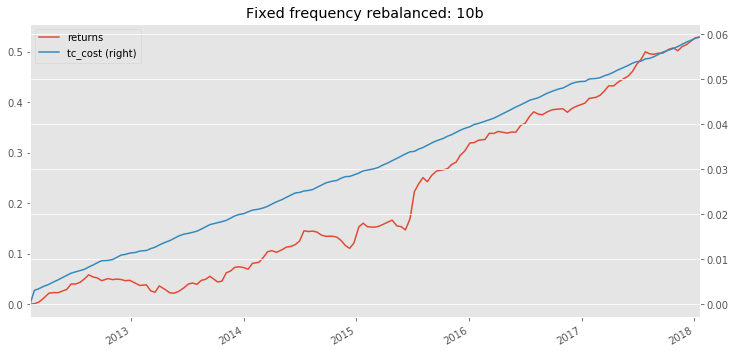

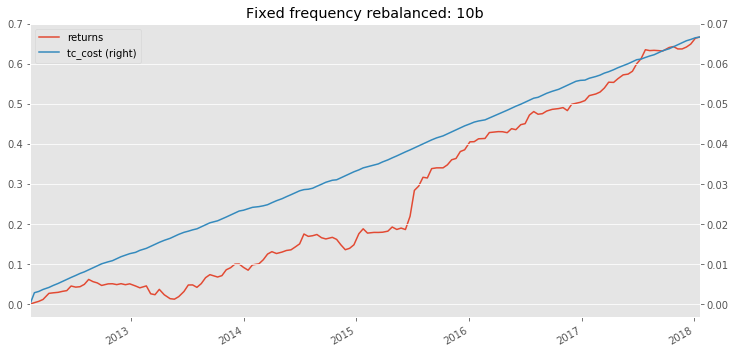

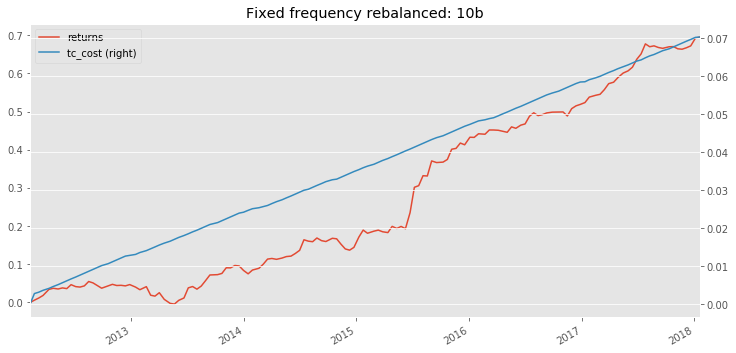

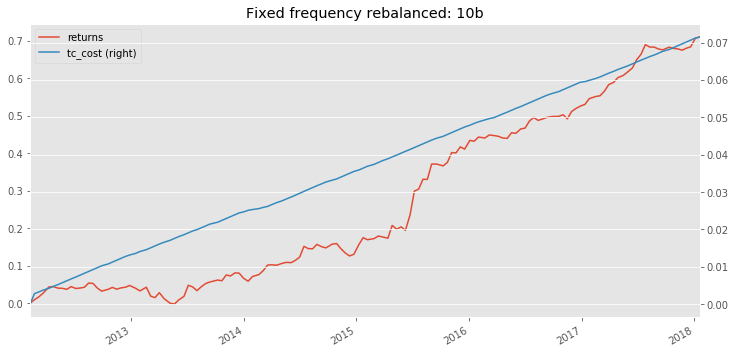

In [18]:
# Predicting and re-balance phase

weight_gaps = [0.01, 0.02, 0.03, 0.04]

model1_weight = 1.0
model2_weight = 0.5

factor_groups = const_model_factor_data.groupby('trade_date')

for weight_gap in weight_gaps:
    print("start {0} weight gap simulation ...".format(weight_gap))

    rets = []
    turn_overs = []
    leverags = []
    previous_pos = pd.DataFrame()

    index_dates = []

    for i, value in enumerate(factor_groups):
        date = value[0]
        data = value[1]
        ref_date = date.strftime('%Y-%m-%d')

        total_data = data.fillna(data[const_features_keys].median())
        alpha_logger.info('{0}: {1}'.format(date, len(total_data)))
        risk_exp = total_data[neutralize_risk].values.astype(float)
        industry = total_data.industry_code.values
        benchmark_w = total_data.weight.values

        constraint_exp = total_data[constraint_risk].values
        risk_exp_expand = np.concatenate((constraint_exp, np.ones((len(risk_exp), 1))), axis=1).astype(float)

        risk_names = constraint_risk + ['total']
        risk_target = risk_exp_expand.T @ benchmark_w

        lbound = np.maximum(0., benchmark_w - weight_gap)  # np.zeros(len(total_data))
        ubound = weight_gap + benchmark_w

        is_in_benchmark = (benchmark_w > 0.).astype(float)

        risk_exp_expand = np.concatenate((risk_exp_expand, is_in_benchmark.reshape((-1, 1))), axis=1).astype(float)
        risk_names.append('benchmark_total')

        constraint = Constraints(risk_exp_expand, risk_names)

        for i, name in enumerate(risk_names):
            if name == 'total':
                constraint.set_constraints(name,
                                           lower_bound=risk_target[i],
                                           upper_bound=risk_target[i])
            elif name == 'SIZE':
                base_target = abs(risk_target[i])
                constraint.set_constraints(name,
                                           lower_bound=risk_target[i] + base_target * size_risk_lower,
                                           upper_bound=risk_target[i] + base_target * size_risk_upper)
            elif name == 'benchmark_total':
                base_target = benchmark_w.sum()
                constraint.set_constraints(name,
                                           lower_bound=benchmark_total_lower * base_target,
                                           upper_bound=benchmark_total_upper * base_target)
            else:
                constraint.set_constraints(name,
                                           lower_bound=risk_target[i] * industry_lower,
                                           upper_bound=risk_target[i] * industry_upper)
        
        factor_values = factor_processing(total_data[const_features_keys].values,
                                          pre_process=[winsorize_normal, standardize],
                                          risk_factors=risk_exp,
                                          post_process=[winsorize_normal, standardize])

        # const linear model
        er1 = const_model.predict(factor_values)
        
        try:
            model = models_series.ix[date]
        except KeyError:
            alpha_logger.info("model is not available. Omit this date")
            continue
            
        index_dates.append(date)

        x = predict_x[date]
        this_risk = predict_risk[date][:, 2:]
        this_predict_code = predict_code[date]
        
        new_x = cross_product(x, this_risk)
        er2 = model.predict(new_x)

        # combine model
        er1_table = pd.DataFrame({'er1': er1, 'code': total_data.code.values})
        er2_table = pd.DataFrame({'er2': er2, 'code': this_predict_code})
        er_table = pd.merge(er1_table, er2_table, on=['code'], how='left').fillna(0)

        er1 = er_table.er1.values
        er2 = er_table.er2.values
        
        if er2.std() > 0:
            print('using backbone model and alpha model')
            er = model1_weight * er1 / er1.std() +  model2_weight * er2 / er2.std()
        else:
            print('using only backbone modedl')
            er = model1_weight * er1
            
        codes = total_data['code'].values

        if previous_pos.empty:
            current_position = None
            turn_over_target = None
        else:
            previous_pos.set_index('code', inplace=True)
            remained_pos = previous_pos.loc[codes]

            remained_pos.fillna(0., inplace=True)
            turn_over_target = turn_over_target_base
            current_position = remained_pos.weight.values

        try:
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  turn_over_target=turn_over_target,
                                                  current_position=current_position,
                                                  lbound=lbound,
                                                  ubound=ubound)
        except ValueError:
            alpha_logger.info('{0} full re-balance'.format(date))
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  use_rank=use_rank,
                                                  lbound=lbound,
                                                  ubound=ubound)

        target_pos['code'] = total_data['code'].values

        turn_over, executed_pos = executor.execute(target_pos=target_pos)

        executed_codes = executed_pos.code.tolist()
        dx_returns = engine.fetch_dx_return(date, executed_codes, horizon=horizon, offset=1)

        result = pd.merge(executed_pos, total_data[['code', 'weight']], on=['code'], how='inner')
        result = pd.merge(result, dx_returns, on=['code'])

        leverage = result.weight_x.abs().sum()

        ret = result.weight_x.values @ (np.exp(result.dx.values) - 1.)
        rets.append(np.log(1. + ret))
        executor.set_current(executed_pos)
        turn_overs.append(turn_over)
        leverags.append(leverage)

        previous_pos = executed_pos
        alpha_logger.info('{0} is finished'.format(date))

    ret_df = pd.DataFrame({'returns': rets, 'turn_over': turn_overs, 'leverage': leverags}, index=index_dates)

    # index return
    index_return = engine.fetch_dx_return_index_range(benchmark_code, start_date, end_date, horizon=horizon,
                                                      offset=1).set_index('trade_date')
    ret_df['index'] = index_return['dx']

    ret_df.loc[advanceDateByCalendar('china.sse', ref_dates[-1], frequency)] = 0.
    ret_df = ret_df.shift(1)
    ret_df.iloc[0] = 0.
    ret_df['tc_cost'] = ret_df.turn_over * 0.002
    ret_df['returns'] = ret_df['leverage'] * (ret_df['returns'] - ret_df['index'])

    ret_df[['returns', 'tc_cost']].cumsum().plot(figsize=(12, 6),
                                                 title='Fixed frequency rebalanced: {0}'.format(frequency),
                                                 secondary_y='tc_cost')

    ret_df['ret_after_tc'] = ret_df['returns'] - ret_df['tc_cost']
    

    sharp_calc = MovingSharp(49)
    drawdown_calc = MovingMaxDrawdown(49)
    max_drawdown_calc = MovingMaxDrawdown(len(ret_df))

    res_df = pd.DataFrame(columns=['daily_return', 'cum_ret', 'sharp', 'drawdown', 'max_drawn', 'leverage'])

    total_returns = 0.

    for i, ret in enumerate(ret_df['ret_after_tc']):
        date = ret_df.index[i]
        total_returns += ret
        sharp_calc.push({'ret': ret, 'riskFree': 0.})
        drawdown_calc.push({'ret': ret})
        max_drawdown_calc.push({'ret': ret})

        res_df.loc[date, 'daily_return'] = ret
        res_df.loc[date, 'cum_ret'] = total_returns
        res_df.loc[date, 'drawdown'] = drawdown_calc.result()[0]
        res_df.loc[date, 'max_drawn'] = max_drawdown_calc.result()[0]
        res_df.loc[date, 'leverage'] = ret_df.loc[date, 'leverage']

        if i < 10:
            res_df.loc[date, 'sharp'] = 0.
        else:
            res_df.loc[date, 'sharp'] = sharp_calc.result() * np.sqrt(49)

    res_df.to_csv('hs300_rf_{0}.csv'.format(int(weight_gap * 100)))